## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


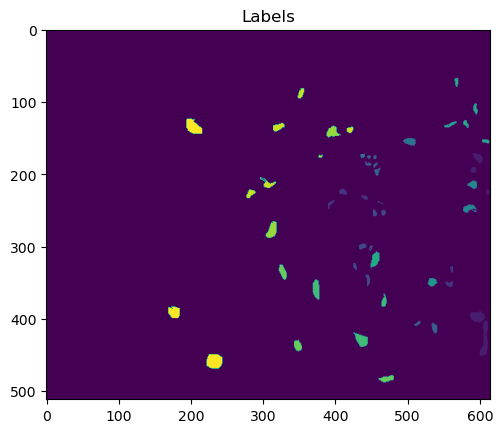

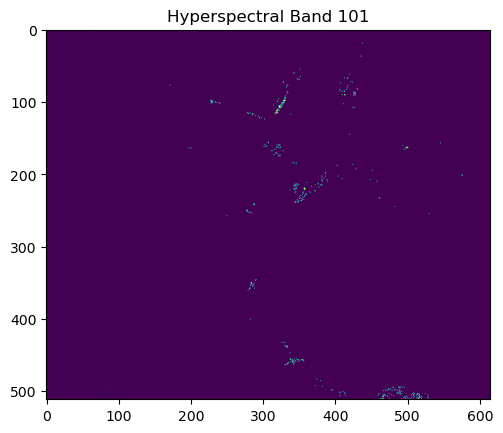

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(520, 5, 5, 176)
(65, 5, 5, 176)
(4626, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 260
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2518, PSNR: 5.9899


Epoch [1/50] Training Loss: 0.2422, PSNR: 6.1595
	[Val]   Batch [1/17] Loss: 0.2303, PSNR: 6.3772
	[Val]   Batch [10/17] Loss: 0.2306, PSNR: 6.3713
Epoch [1/50] Validation Loss: 0.2304, PSNR: 6.3750

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2228, PSNR: 6.5205


Epoch [2/50] Training Loss: 0.2074, PSNR: 6.8383
	[Val]   Batch [1/17] Loss: 0.1846, PSNR: 7.3370
	[Val]   Batch [10/17] Loss: 0.1864, PSNR: 7.2945
Epoch [2/50] Validation Loss: 0.1858, PSNR: 7.3102

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1850, PSNR: 7.3287


Epoch [3/50] Training Loss: 0.1697, PSNR: 7.7100
	[Val]   Batch [1/17] Loss: 0.1485, PSNR: 8.2814
	[Val]   Batch [10/17] Loss: 0.1516, PSNR: 8.1924
Epoch [3/50] Validation Loss: 0.1507, PSNR: 8.2191

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1495, PSNR: 8.2525


Epoch [4/50] Training Loss: 0.1366, PSNR: 8.6520
	[Val]   Batch [1/17] Loss: 0.1189, PSNR: 9.2476
	[Val]   Batch [10/17] Loss: 0.1208, PSNR: 9.1799
Epoch [4/50] Validation Loss: 0.1201, PSNR: 9.2045

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1188, PSNR: 9.2522


Epoch [5/50] Training Loss: 0.1088, PSNR: 9.6430
	[Val]   Batch [1/17] Loss: 0.0959, PSNR: 10.1821
	[Val]   Batch [10/17] Loss: 0.0977, PSNR: 10.1014
Epoch [5/50] Validation Loss: 0.0970, PSNR: 10.1326

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0947, PSNR: 10.2367


Epoch [6/50] Training Loss: 0.0865, PSNR: 10.6371
	[Val]   Batch [1/17] Loss: 0.0773, PSNR: 11.1182
	[Val]   Batch [10/17] Loss: 0.0784, PSNR: 11.0560
Epoch [6/50] Validation Loss: 0.0780, PSNR: 11.0783

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0755, PSNR: 11.2219


Epoch [7/50] Training Loss: 0.0696, PSNR: 11.5802
	[Val]   Batch [1/17] Loss: 0.0633, PSNR: 11.9873
	[Val]   Batch [10/17] Loss: 0.0635, PSNR: 11.9742
Epoch [7/50] Validation Loss: 0.0634, PSNR: 11.9787

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0615, PSNR: 12.1142


Epoch [8/50] Training Loss: 0.0568, PSNR: 12.4594
	[Val]   Batch [1/17] Loss: 0.0521, PSNR: 12.8300
	[Val]   Batch [10/17] Loss: 0.0524, PSNR: 12.8033
Epoch [8/50] Validation Loss: 0.0523, PSNR: 12.8153

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0503, PSNR: 12.9824


Epoch [9/50] Training Loss: 0.0472, PSNR: 12.6029
	[Val]   Batch [1/17] Loss: 0.0439, PSNR: 13.5718
	[Val]   Batch [10/17] Loss: 0.0445, PSNR: 13.5208
Epoch [9/50] Validation Loss: 0.0443, PSNR: 13.5353

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0422, PSNR: 13.7446


Epoch [10/50] Training Loss: 0.0397, PSNR: 13.3341
	[Val]   Batch [1/17] Loss: 0.0377, PSNR: 14.2359
	[Val]   Batch [10/17] Loss: 0.0378, PSNR: 14.2256
Epoch [10/50] Validation Loss: 0.0378, PSNR: 14.2246

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0361, PSNR: 14.4292


Epoch [11/50] Training Loss: 0.0340, PSNR: 14.6917
	[Val]   Batch [1/17] Loss: 0.0322, PSNR: 14.9216
	[Val]   Batch [10/17] Loss: 0.0322, PSNR: 14.9168
Epoch [11/50] Validation Loss: 0.0323, PSNR: 14.9127

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0307, PSNR: 15.1246


Epoch [12/50] Training Loss: 0.0295, PSNR: 15.3109
	[Val]   Batch [1/17] Loss: 0.0283, PSNR: 15.4805
	[Val]   Batch [10/17] Loss: 0.0284, PSNR: 15.4609
Epoch [12/50] Validation Loss: 0.0284, PSNR: 15.4610

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0272, PSNR: 15.6513


Epoch [13/50] Training Loss: 0.0258, PSNR: 15.8859
	[Val]   Batch [1/17] Loss: 0.0248, PSNR: 16.0538
	[Val]   Batch [10/17] Loss: 0.0249, PSNR: 16.0320
Epoch [13/50] Validation Loss: 0.0249, PSNR: 16.0318

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0239, PSNR: 16.2201


Epoch [14/50] Training Loss: 0.0228, PSNR: 15.7398
	[Val]   Batch [1/17] Loss: 0.0222, PSNR: 16.5399
	[Val]   Batch [10/17] Loss: 0.0223, PSNR: 16.5179
Epoch [14/50] Validation Loss: 0.0223, PSNR: 16.5186

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0213, PSNR: 16.7117


Epoch [15/50] Training Loss: 0.0203, PSNR: 16.9231
	[Val]   Batch [1/17] Loss: 0.0198, PSNR: 17.0241
	[Val]   Batch [10/17] Loss: 0.0200, PSNR: 16.9950
Epoch [15/50] Validation Loss: 0.0200, PSNR: 17.0003

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0190, PSNR: 17.2123


Epoch [16/50] Training Loss: 0.0183, PSNR: 17.3879
	[Val]   Batch [1/17] Loss: 0.0179, PSNR: 17.4733
	[Val]   Batch [10/17] Loss: 0.0180, PSNR: 17.4569
Epoch [16/50] Validation Loss: 0.0180, PSNR: 17.4557

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0172, PSNR: 17.6564


Epoch [17/50] Training Loss: 0.0165, PSNR: 17.8266
	[Val]   Batch [1/17] Loss: 0.0162, PSNR: 17.9036
	[Val]   Batch [10/17] Loss: 0.0163, PSNR: 17.8734
Epoch [17/50] Validation Loss: 0.0163, PSNR: 17.8757

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0155, PSNR: 18.0908


Epoch [18/50] Training Loss: 0.0150, PSNR: 17.5672
	[Val]   Batch [1/17] Loss: 0.0148, PSNR: 18.3033
	[Val]   Batch [10/17] Loss: 0.0149, PSNR: 18.2664
Epoch [18/50] Validation Loss: 0.0149, PSNR: 18.2720

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0143, PSNR: 18.4467


Epoch [19/50] Training Loss: 0.0137, PSNR: 18.6335
	[Val]   Batch [1/17] Loss: 0.0135, PSNR: 18.7016
	[Val]   Batch [10/17] Loss: 0.0136, PSNR: 18.6612
Epoch [19/50] Validation Loss: 0.0136, PSNR: 18.6708

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0128, PSNR: 18.9159


Epoch [20/50] Training Loss: 0.0126, PSNR: 18.3394
	[Val]   Batch [1/17] Loss: 0.0124, PSNR: 19.0574
	[Val]   Batch [10/17] Loss: 0.0126, PSNR: 19.0114
Epoch [20/50] Validation Loss: 0.0125, PSNR: 19.0219

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0119, PSNR: 19.2514


Epoch [21/50] Training Loss: 0.0116, PSNR: 18.6706
	[Val]   Batch [1/17] Loss: 0.0116, PSNR: 19.3524
	[Val]   Batch [10/17] Loss: 0.0117, PSNR: 19.3012
Epoch [21/50] Validation Loss: 0.0117, PSNR: 19.3112

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0111, PSNR: 19.5368


Epoch [22/50] Training Loss: 0.0107, PSNR: 19.6961
	[Val]   Batch [1/17] Loss: 0.0106, PSNR: 19.7328
	[Val]   Batch [10/17] Loss: 0.0107, PSNR: 19.6980
Epoch [22/50] Validation Loss: 0.0107, PSNR: 19.7039

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0107, PSNR: 19.7228


Epoch [23/50] Training Loss: 0.0100, PSNR: 20.0183
	[Val]   Batch [1/17] Loss: 0.0099, PSNR: 20.0625
	[Val]   Batch [10/17] Loss: 0.0100, PSNR: 19.9961
Epoch [23/50] Validation Loss: 0.0100, PSNR: 20.0138

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0095, PSNR: 20.2056


Epoch [24/50] Training Loss: 0.0093, PSNR: 20.3221
	[Val]   Batch [1/17] Loss: 0.0092, PSNR: 20.3448
	[Val]   Batch [10/17] Loss: 0.0093, PSNR: 20.2950
Epoch [24/50] Validation Loss: 0.0093, PSNR: 20.3066

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0089, PSNR: 20.5046


Epoch [25/50] Training Loss: 0.0087, PSNR: 20.6129
	[Val]   Batch [1/17] Loss: 0.0087, PSNR: 20.6292
	[Val]   Batch [10/17] Loss: 0.0088, PSNR: 20.5574
Epoch [25/50] Validation Loss: 0.0088, PSNR: 20.5790

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0083, PSNR: 20.8220


Epoch [26/50] Training Loss: 0.0081, PSNR: 20.2109
	[Val]   Batch [1/17] Loss: 0.0081, PSNR: 20.9219
	[Val]   Batch [10/17] Loss: 0.0082, PSNR: 20.8445
Epoch [26/50] Validation Loss: 0.0082, PSNR: 20.8623

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0078, PSNR: 21.0525


Epoch [27/50] Training Loss: 0.0077, PSNR: 21.1586
	[Val]   Batch [1/17] Loss: 0.0076, PSNR: 21.2057
	[Val]   Batch [10/17] Loss: 0.0077, PSNR: 21.1296
Epoch [27/50] Validation Loss: 0.0077, PSNR: 21.1504

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0076, PSNR: 21.2186


Epoch [28/50] Training Loss: 0.0072, PSNR: 21.4187
	[Val]   Batch [1/17] Loss: 0.0072, PSNR: 21.4305
	[Val]   Batch [10/17] Loss: 0.0074, PSNR: 21.3332
Epoch [28/50] Validation Loss: 0.0073, PSNR: 21.3629

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0069, PSNR: 21.5986


Epoch [29/50] Training Loss: 0.0068, PSNR: 21.6796
	[Val]   Batch [1/17] Loss: 0.0067, PSNR: 21.7129
	[Val]   Batch [10/17] Loss: 0.0069, PSNR: 21.6186
Epoch [29/50] Validation Loss: 0.0068, PSNR: 21.6455

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0065, PSNR: 21.8902


Epoch [30/50] Training Loss: 0.0064, PSNR: 21.9205
	[Val]   Batch [1/17] Loss: 0.0064, PSNR: 21.9456
	[Val]   Batch [10/17] Loss: 0.0065, PSNR: 21.8659
Epoch [30/50] Validation Loss: 0.0065, PSNR: 21.8883

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0062, PSNR: 22.0838


Epoch [31/50] Training Loss: 0.0061, PSNR: 22.1526
	[Val]   Batch [1/17] Loss: 0.0061, PSNR: 22.1798
	[Val]   Batch [10/17] Loss: 0.0062, PSNR: 22.0610
Epoch [31/50] Validation Loss: 0.0062, PSNR: 22.0986

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0061, PSNR: 22.1274


Epoch [32/50] Training Loss: 0.0058, PSNR: 22.3968
	[Val]   Batch [1/17] Loss: 0.0057, PSNR: 22.4322
	[Val]   Batch [10/17] Loss: 0.0058, PSNR: 22.3381
Epoch [32/50] Validation Loss: 0.0058, PSNR: 22.3652

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0056, PSNR: 22.4972


Epoch [33/50] Training Loss: 0.0055, PSNR: 21.9365
	[Val]   Batch [1/17] Loss: 0.0055, PSNR: 22.5856
	[Val]   Batch [10/17] Loss: 0.0057, PSNR: 22.4783
Epoch [33/50] Validation Loss: 0.0056, PSNR: 22.5066

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0052, PSNR: 22.8375


Epoch [34/50] Training Loss: 0.0052, PSNR: 22.8148
	[Val]   Batch [1/17] Loss: 0.0052, PSNR: 22.8272
	[Val]   Batch [10/17] Loss: 0.0054, PSNR: 22.7055
Epoch [34/50] Validation Loss: 0.0053, PSNR: 22.7439

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0053, PSNR: 22.7883


Epoch [35/50] Training Loss: 0.0050, PSNR: 23.0315
	[Val]   Batch [1/17] Loss: 0.0049, PSNR: 23.0593
	[Val]   Batch [10/17] Loss: 0.0051, PSNR: 22.9421
Epoch [35/50] Validation Loss: 0.0050, PSNR: 22.9770

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0047, PSNR: 23.2585


Epoch [36/50] Training Loss: 0.0048, PSNR: 23.2340
	[Val]   Batch [1/17] Loss: 0.0047, PSNR: 23.2719
	[Val]   Batch [10/17] Loss: 0.0048, PSNR: 23.1452
Epoch [36/50] Validation Loss: 0.0048, PSNR: 23.1856

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0046, PSNR: 23.3856


Epoch [37/50] Training Loss: 0.0045, PSNR: 22.7426
	[Val]   Batch [1/17] Loss: 0.0045, PSNR: 23.4531
	[Val]   Batch [10/17] Loss: 0.0047, PSNR: 23.3191
Epoch [37/50] Validation Loss: 0.0046, PSNR: 23.3594

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0044, PSNR: 23.5849


Epoch [38/50] Training Loss: 0.0043, PSNR: 23.6222
	[Val]   Batch [1/17] Loss: 0.0043, PSNR: 23.6200
	[Val]   Batch [10/17] Loss: 0.0045, PSNR: 23.4723
Epoch [38/50] Validation Loss: 0.0044, PSNR: 23.5180

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0043, PSNR: 23.6799


Epoch [39/50] Training Loss: 0.0041, PSNR: 23.8221
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.8143
	[Val]   Batch [10/17] Loss: 0.0043, PSNR: 23.6595
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.7049

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 23.9934


Epoch [40/50] Training Loss: 0.0040, PSNR: 24.0050
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.0375
	[Val]   Batch [10/17] Loss: 0.0041, PSNR: 23.8815
Epoch [40/50] Validation Loss: 0.0040, PSNR: 23.9329

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.0419


Epoch [41/50] Training Loss: 0.0038, PSNR: 24.1616
	[Val]   Batch [1/17] Loss: 0.0038, PSNR: 24.1742
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 24.0010
Epoch [41/50] Validation Loss: 0.0039, PSNR: 24.0597

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0037, PSNR: 24.2945


Epoch [42/50] Training Loss: 0.0037, PSNR: 24.3629
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.4075
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.2336
Epoch [42/50] Validation Loss: 0.0037, PSNR: 24.2896

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.3907


Epoch [43/50] Training Loss: 0.0035, PSNR: 24.5329
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.5787
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4004
Epoch [43/50] Validation Loss: 0.0036, PSNR: 24.4566

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.6998


Epoch [44/50] Training Loss: 0.0034, PSNR: 24.6897
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.7393
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.5516
Epoch [44/50] Validation Loss: 0.0035, PSNR: 24.6119

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9634


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.8596
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9188
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.7259
Epoch [45/50] Validation Loss: 0.0033, PSNR: 24.7875

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9298


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.3361
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9821
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.7959
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8513

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.7273


Epoch [47/50] Training Loss: 0.0030, PSNR: 24.5007
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1541
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.9449
Epoch [47/50] Validation Loss: 0.0032, PSNR: 25.0084

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3181


Epoch [48/50] Training Loss: 0.0029, PSNR: 25.3226
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3716
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.1612
Epoch [48/50] Validation Loss: 0.0030, PSNR: 25.2284

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0027, PSNR: 25.6424


Epoch [49/50] Training Loss: 0.0028, PSNR: 25.4581
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5225
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3094
Epoch [49/50] Validation Loss: 0.0029, PSNR: 25.3811

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0027, PSNR: 25.6285


Epoch [50/50] Training Loss: 0.0028, PSNR: 25.6077
	[Val]   Batch [1/17] Loss: 0.0027, PSNR: 25.6434
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.4271
Epoch [50/50] Validation Loss: 0.0028, PSNR: 25.4963


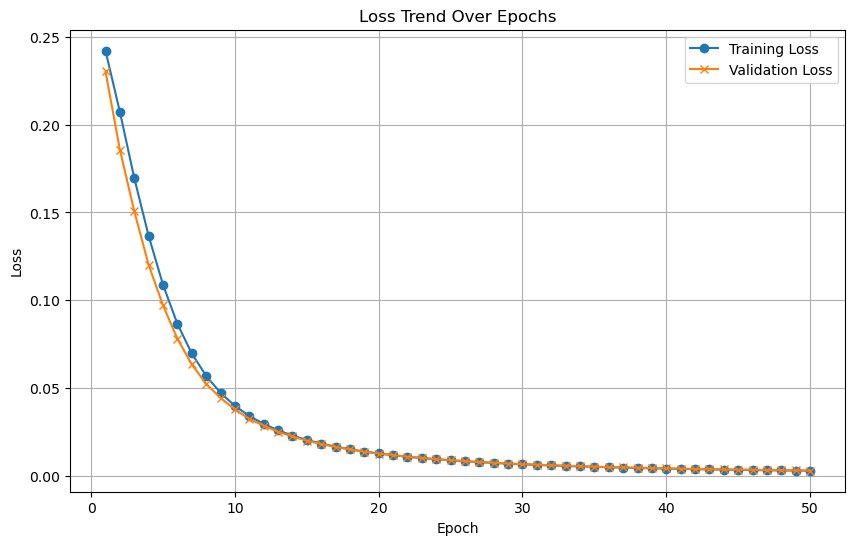

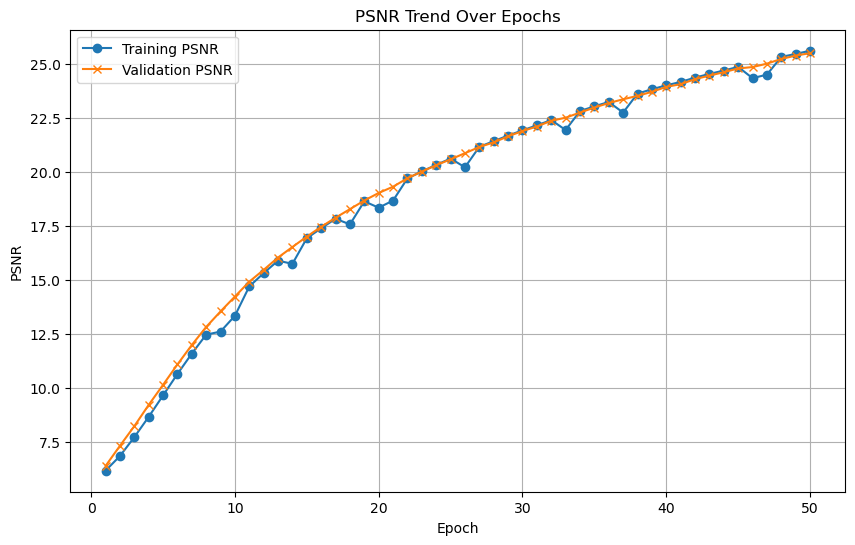

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/19 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5554
    Validation Batch [1/1], Loss: 2.5697
Validation Loss: 2.5697, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5697. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5388
    Validation Batch [1/1], Loss: 2.5697
Validation Loss: 2.5697, Validation Accuracy: 7.69%
Validation loss improved from 2.5697 to 2.5697. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5293
    Validation Batch [1/1], Loss: 2.5696
Validation Loss: 2.5696, Validation Accuracy: 7.69%
Validation loss improved from 2.5697 to 2.5696. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5079
    Validation Batch [1/1], Loss: 2.5696
Validation Loss: 2.5696, Validation Accuracy: 7.69%
Validation loss improved from 2.5696 to 2.5696. Saving model...

LOG: Epoch [5/1000] - 

    Validation Batch [1/1], Loss: 2.5696
Validation Loss: 2.5696, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.4427
    Validation Batch [1/1], Loss: 2.5698
Validation Loss: 2.5698, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.4422
    Validation Batch [1/1], Loss: 2.5701
Validation Loss: 2.5701, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.4273
    Validation Batch [1/1], Loss: 2.5705
Validation Loss: 2.5705, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 2.4201
    Validation Batch [1/1], Loss: 2.5709
Validation Loss: 2.5709, Valida

Epoch [25/1000] completed, Average Training Loss: 2.2652
    Validation Batch [1/1], Loss: 2.5805
Validation Loss: 2.5805, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.2616
    Validation Batch [1/1], Loss: 2.5817
Validation Loss: 2.5817, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.2484
    Validation Batch [1/1], Loss: 2.5821
Validation Loss: 2.5821, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 2.2338
    Validation Batch [1/1], Loss: 2.5811
Validation Loss: 2.5811, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [29/1000] - Training
Epoch [29/1000] completed, Average Training Loss: 2.2122
    Validat

    Validation Batch [1/1], Loss: 2.3971
Validation Loss: 2.3971, Validation Accuracy: 20.00%
Validation loss improved from 2.4409 to 2.3971. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.0212
    Validation Batch [1/1], Loss: 2.3592
Validation Loss: 2.3592, Validation Accuracy: 20.00%
Validation loss improved from 2.3971 to 2.3592. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 1.9992
    Validation Batch [1/1], Loss: 2.3116
Validation Loss: 2.3116, Validation Accuracy: 24.62%
Validation loss improved from 2.3592 to 2.3116. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 1.9800
    Validation Batch [1/1], Loss: 2.2716
Validation Loss: 2.2716, Validation Accuracy: 26.15%
Validation loss improved from 2.3116 to 2.2716. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 1.9742
    Vali

Epoch [55/1000] completed, Average Training Loss: 1.7515
    Validation Batch [1/1], Loss: 1.9721
Validation Loss: 1.9721, Validation Accuracy: 44.62%
Validation loss improved from 1.9846 to 1.9721. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.7578
    Validation Batch [1/1], Loss: 1.9510
Validation Loss: 1.9510, Validation Accuracy: 46.15%
Validation loss improved from 1.9721 to 1.9510. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.7066
    Validation Batch [1/1], Loss: 1.9373
Validation Loss: 1.9373, Validation Accuracy: 44.62%
Validation loss improved from 1.9510 to 1.9373. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.6990
    Validation Batch [1/1], Loss: 1.9265
Validation Loss: 1.9265, Validation Accuracy: 46.15%
Validation loss improved from 1.9373 to 1.9265. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [5

Epoch [69/1000] completed, Average Training Loss: 1.5312
    Validation Batch [1/1], Loss: 1.7768
Validation Loss: 1.7768, Validation Accuracy: 55.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.4873
    Validation Batch [1/1], Loss: 1.7645
Validation Loss: 1.7645, Validation Accuracy: 53.85%
Validation loss improved from 1.7708 to 1.7645. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.4800
    Validation Batch [1/1], Loss: 1.7244
Validation Loss: 1.7244, Validation Accuracy: 58.46%
Validation loss improved from 1.7645 to 1.7244. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 1.4707
    Validation Batch [1/1], Loss: 1.7016
Validation Loss: 1.7016, Validation Accuracy: 61.54%
Validation loss improved from 1.7244 to 1.7016. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] complet

Epoch [85/1000] completed, Average Training Loss: 1.2569
    Validation Batch [1/1], Loss: 1.5118
Validation Loss: 1.5118, Validation Accuracy: 63.08%
Validation loss improved from 1.5569 to 1.5118. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.2505
    Validation Batch [1/1], Loss: 1.5011
Validation Loss: 1.5011, Validation Accuracy: 63.08%
Validation loss improved from 1.5118 to 1.5011. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.2081
    Validation Batch [1/1], Loss: 1.5079
Validation Loss: 1.5079, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.2030
    Validation Batch [1/1], Loss: 1.4892
Validation Loss: 1.4892, Validation Accuracy: 63.08%
Validation loss improved from 1.5011 to 1.4892. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] complet

Epoch [100/1000] completed, Average Training Loss: 1.0311
    Validation Batch [1/1], Loss: 1.3098
Validation Loss: 1.3098, Validation Accuracy: 66.15%
Validation loss improved from 1.3362 to 1.3098. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 0.9884
    Validation Batch [1/1], Loss: 1.3031
Validation Loss: 1.3031, Validation Accuracy: 66.15%
Validation loss improved from 1.3098 to 1.3031. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 0.9951
    Validation Batch [1/1], Loss: 1.3061
Validation Loss: 1.3061, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 0.9816
    Validation Batch [1/1], Loss: 1.2877
Validation Loss: 1.2877, Validation Accuracy: 67.69%
Validation loss improved from 1.3031 to 1.2877. Saving model...

LOG: Epoch [104/1000] - Training
Epoch [104/1000

Epoch [115/1000] completed, Average Training Loss: 0.8375
    Validation Batch [1/1], Loss: 1.1737
Validation Loss: 1.1737, Validation Accuracy: 70.77%
Validation loss improved from 1.1857 to 1.1737. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 0.8286
    Validation Batch [1/1], Loss: 1.1490
Validation Loss: 1.1490, Validation Accuracy: 70.77%
Validation loss improved from 1.1737 to 1.1490. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 0.8397
    Validation Batch [1/1], Loss: 1.1674
Validation Loss: 1.1674, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 0.7927
    Validation Batch [1/1], Loss: 1.1586
Validation Loss: 1.1586, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Av

Epoch [130/1000] completed, Average Training Loss: 0.6637
    Validation Batch [1/1], Loss: 1.0346
Validation Loss: 1.0346, Validation Accuracy: 72.31%
Validation loss improved from 1.0446 to 1.0346. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 0.6352
    Validation Batch [1/1], Loss: 1.0305
Validation Loss: 1.0305, Validation Accuracy: 72.31%
Validation loss improved from 1.0346 to 1.0305. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 0.5987
    Validation Batch [1/1], Loss: 1.0051
Validation Loss: 1.0051, Validation Accuracy: 72.31%
Validation loss improved from 1.0305 to 1.0051. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 0.6352
    Validation Batch [1/1], Loss: 0.9903
Validation Loss: 0.9903, Validation Accuracy: 72.31%
Validation loss improved from 1.0051 to 0.9903. Saving model...

LOG: Epoch [134/1000] - Training


Epoch [145/1000] completed, Average Training Loss: 0.5091
    Validation Batch [1/1], Loss: 0.9233
Validation Loss: 0.9233, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 0.4885
    Validation Batch [1/1], Loss: 0.9154
Validation Loss: 0.9154, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 0.4837
    Validation Batch [1/1], Loss: 0.8925
Validation Loss: 0.8925, Validation Accuracy: 75.38%
Validation loss improved from 0.9064 to 0.8925. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.4783
    Validation Batch [1/1], Loss: 0.8934
Validation Loss: 0.8934, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training 

Epoch [161/1000] completed, Average Training Loss: 0.3717
    Validation Batch [1/1], Loss: 0.8370
Validation Loss: 0.8370, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.3491
    Validation Batch [1/1], Loss: 0.8428
Validation Loss: 0.8428, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 0.3563
    Validation Batch [1/1], Loss: 0.8012
Validation Loss: 0.8012, Validation Accuracy: 81.54%
Validation loss improved from 0.8304 to 0.8012. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 0.3464
    Validation Batch [1/1], Loss: 0.8077
Validation Loss: 0.8077, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.8250
Validation Loss: 0.8250, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.2757
    Validation Batch [1/1], Loss: 0.8162
Validation Loss: 0.8162, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.2883
    Validation Batch [1/1], Loss: 0.7522
Validation Loss: 0.7522, Validation Accuracy: 78.46%
Validation loss improved from 0.7637 to 0.7522. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.2790
    Validation Batch [1/1], Loss: 0.7527
Validation Loss: 0.7527, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.2596
    Validation Batch [1/1], Loss: 0.7587
Vali

Epoch [190/1000] completed, Average Training Loss: 0.2071
    Validation Batch [1/1], Loss: 0.7440
Validation Loss: 0.7440, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.2184
    Validation Batch [1/1], Loss: 0.7422
Validation Loss: 0.7422, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.1904
    Validation Batch [1/1], Loss: 0.7737
Validation Loss: 0.7737, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.2229
    Validation Batch [1/1], Loss: 0.7312
Validation Loss: 0.7312, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.1891
 

Epoch [204/1000] completed, Average Training Loss: 0.1731
    Validation Batch [1/1], Loss: 0.7237
Validation Loss: 0.7237, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [205/1000] - Training
Epoch [205/1000] completed, Average Training Loss: 0.1633
    Validation Batch [1/1], Loss: 0.7157
Validation Loss: 0.7157, Validation Accuracy: 80.00%
Validation loss improved from 0.7195 to 0.7157. Saving model...

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.1588
    Validation Batch [1/1], Loss: 0.7152
Validation Loss: 0.7152, Validation Accuracy: 80.00%
Validation loss improved from 0.7157 to 0.7152. Saving model...

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.1589
    Validation Batch [1/1], Loss: 0.7026
Validation Loss: 0.7026, Validation Accuracy: 81.54%
Validation loss improved from 0.7152 to 0.7026. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000

Epoch [213/1000] completed, Average Training Loss: 0.1366
    Validation Batch [1/1], Loss: 0.7625
Validation Loss: 0.7625, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Average Training Loss: 0.1459
    Validation Batch [1/1], Loss: 0.7617
Validation Loss: 0.7617, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.1482
    Validation Batch [1/1], Loss: 0.7387
Validation Loss: 0.7387, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.1328
    Validation Batch [1/1], Loss: 0.7158
Validation Loss: 0.7158, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.1343
  

Epoch [228/1000] completed, Average Training Loss: 0.1235
    Validation Batch [1/1], Loss: 0.7279
Validation Loss: 0.7279, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.1060
    Validation Batch [1/1], Loss: 0.7983
Validation Loss: 0.7983, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.1115
    Validation Batch [1/1], Loss: 0.8264
Validation Loss: 0.8264, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.1112
    Validation Batch [1/1], Loss: 0.7577
Validation Loss: 0.7577, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.107

    Validation Batch [1/1], Loss: 0.7219
Validation Loss: 0.7219, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.0849
    Validation Batch [1/1], Loss: 0.6973
Validation Loss: 0.6973, Validation Accuracy: 81.54%
Validation loss improved from 0.7009 to 0.6973. Saving model...

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.0910
    Validation Batch [1/1], Loss: 0.7070
Validation Loss: 0.7070, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.0992
    Validation Batch [1/1], Loss: 0.7021
Validation Loss: 0.7021, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.0862
    Validation Batch [1/1], Loss: 0.7069
Vali

Epoch [258/1000] completed, Average Training Loss: 0.0806
    Validation Batch [1/1], Loss: 0.7170
Validation Loss: 0.7170, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.0734
    Validation Batch [1/1], Loss: 0.7165
Validation Loss: 0.7165, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.0742
    Validation Batch [1/1], Loss: 0.7457
Validation Loss: 0.7457, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.0744
    Validation Batch [1/1], Loss: 0.7708
Validation Loss: 0.7708, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.0753
 

Epoch [273/1000] completed, Average Training Loss: 0.0647
    Validation Batch [1/1], Loss: 0.7405
Validation Loss: 0.7405, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.0598
    Validation Batch [1/1], Loss: 0.7671
Validation Loss: 0.7671, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.0673
    Validation Batch [1/1], Loss: 0.7579
Validation Loss: 0.7579, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.0575
    Validation Batch [1/1], Loss: 0.7325
Validation Loss: 0.7325, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.058

Epoch [288/1000] completed, Average Training Loss: 0.0587
    Validation Batch [1/1], Loss: 0.7628
Validation Loss: 0.7628, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.0528
    Validation Batch [1/1], Loss: 0.7609
Validation Loss: 0.7609, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.0568
    Validation Batch [1/1], Loss: 0.7961
Validation Loss: 0.7961, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.0476
    Validation Batch [1/1], Loss: 0.8250
Validation Loss: 0.8250, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.055

Epoch [303/1000] completed, Average Training Loss: 0.0534
    Validation Batch [1/1], Loss: 0.8369
Validation Loss: 0.8369, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.0519
    Validation Batch [1/1], Loss: 0.7620
Validation Loss: 0.7620, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.0475
    Validation Batch [1/1], Loss: 0.7696
Validation Loss: 0.7696, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.0434
    Validation Batch [1/1], Loss: 0.8178
Validation Loss: 0.8178, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.040

Epoch [318/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.8098
Validation Loss: 0.8098, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 67/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.0383
    Validation Batch [1/1], Loss: 0.7946
Validation Loss: 0.7946, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.0429
    Validation Batch [1/1], Loss: 0.7663
Validation Loss: 0.7663, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.0398
    Validation Batch [1/1], Loss: 0.7547
Validation Loss: 0.7547, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.039

Epoch [333/1000] completed, Average Training Loss: 0.0374
    Validation Batch [1/1], Loss: 0.7507
Validation Loss: 0.7507, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.7582
Validation Loss: 0.7582, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [335/1000] - Training
Epoch [335/1000] completed, Average Training Loss: 0.0395
    Validation Batch [1/1], Loss: 0.7411
Validation Loss: 0.7411, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.0397
    Validation Batch [1/1], Loss: 0.7551
Validation Loss: 0.7551, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.037

Epoch [348/1000] completed, Average Training Loss: 0.0296
    Validation Batch [1/1], Loss: 0.7665
Validation Loss: 0.7665, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 97/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.0330
    Validation Batch [1/1], Loss: 0.7819
Validation Loss: 0.7819, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 98/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.0325
    Validation Batch [1/1], Loss: 0.7838
Validation Loss: 0.7838, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 99/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.0323
    Validation Batch [1/1], Loss: 0.7673
Validation Loss: 0.7673, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 351. No improvement for 100 epochs.
Loading the best mo

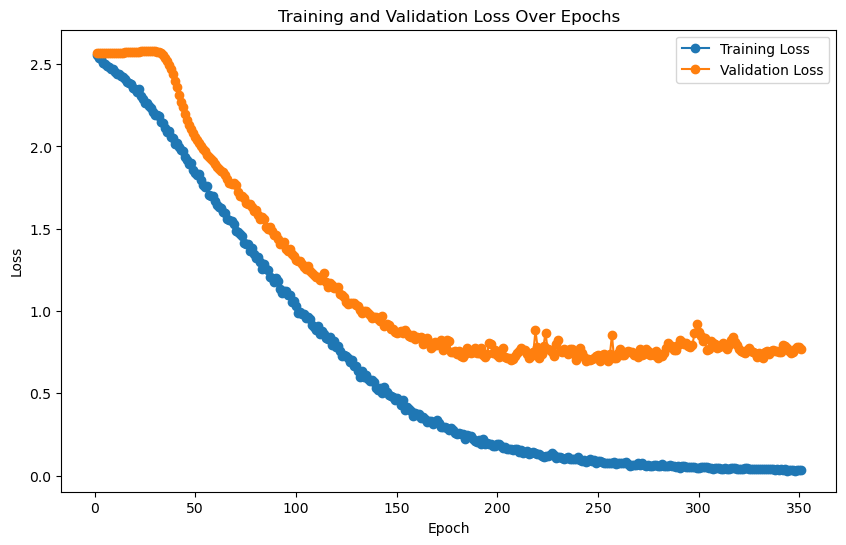

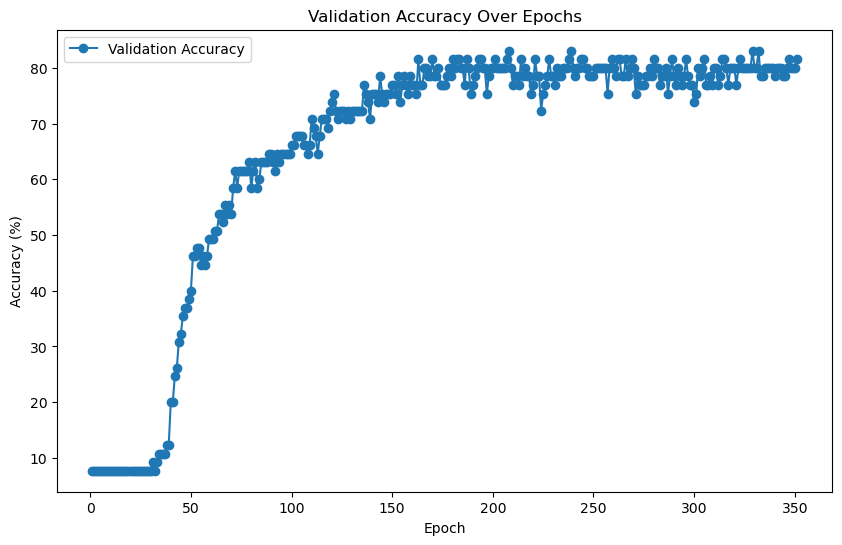


Evaluating on the test set...
    Test Batch [1/19], Loss: 0.4059

Final Test Loss: 0.5229, Test Accuracy: 87.74%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/19 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)

LOG: Training features shape: (520, 64), Training labels shape: (520,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (4626, 64), Test labels shape: (4626,)

LOG: Training Logistic Regression model...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 46.15%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.20      0.20      0.20         5
           2       0.33      0.40      0.36         5
           3       0.00      0.00      0.00         5
           4       1.00      0.20      0.33         5
           5       0.75      0.60      0.67         5
           6       0.18      0.40      0.25         5
           7       0.23      0.60      0.33         5
           8       0.71      1.00      0.83         5
           9       1.00      0.20      0.33         5
          10       1.00      1.00      1.00         5
          11       0.33      0.20      0.25         5
          12       0.67      0.80      0.73         5

    accuracy                           0.46        65
   macro avg       0.57      0.46     

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)
Train reps shape: (520, 64)
Train labels shape: (520,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (4626, 64)
Test labels shape: (4626,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6122  |  Val Loss: 2.5415
Validation loss improved from inf to 2.5415.
[Epoch 2/1000] Train Loss: 2.4999  |  Val Loss: 2.5066
Validation loss improved from 2.5415 to 2.5066.
[Epoch 3/1000] Train Loss: 2.4654  |  Val Loss: 2.4785
Validation loss improved from 2.5066 to 2.4785.
[Epoch 4/1000] Train Loss: 2.4466  |  Val Loss: 2.4595
Validation loss improved from 2.4785 to 2.4595.
[Epoch 5/1000] Train Loss: 2.4243  |  Val Loss: 2.4451
Validation loss improved from 2.4595 to 2.4451.
[Epoch 6/1000] Train Loss: 2.4014  |  Val Loss: 2.4402
Validation loss improved from 2.4451 to 2.4402.
[Epoch 7/1000] Train Loss: 2.3850  |  Val Loss: 2.4333
Validation loss improved from 2.4402 to 2.4333.


[Epoch 8/1000] Train Loss: 2.3818  |  Val Loss: 2.4377
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 9/1000] Train Loss: 2.3710  |  Val Loss: 2.4453
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 10/1000] Train Loss: 2.3636  |  Val Loss: 2.4435
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 11/1000] Train Loss: 2.3688  |  Val Loss: 2.4469
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 12/1000] Train Loss: 2.3539  |  Val Loss: 2.4562
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 13/1000] Train Loss: 2.3504  |  Val Loss: 2.4472
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 14/1000] Train Loss: 2.3400  |  Val Loss: 2.4523
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 15/1000] Train Loss: 2.3329  |  Val Loss: 2.4558
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 16/1000] Train Loss: 2.3325  |  Val Loss: 2.4569
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 17/1000] Train Loss: 2.3236  |  Val Loss: 2.4581
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 18/1000] Train Loss: 2.3252  |  Val Loss: 2.4704
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 19/1000] Train Loss: 2.3139  |  Val Loss: 2.4786
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 20/1000] Train Loss: 2.3118  |  Val Loss: 2.4782
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 21/1000] Train Loss: 2.3088  |  Val Loss: 2.4750
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 22/1000] Train Loss: 2.3183  |  Val Loss: 2.4768
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 23/1000] Train Loss: 2.2931  |  Val Loss: 2.4687
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 24/1000] Train Loss: 2.2926  |  Val Loss: 2.4727
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 25/1000] Train Loss: 2.2914  |  Val Loss: 2.4801
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 26/1000] Train Loss: 2.2922  |  Val Loss: 2.4748
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 27/1000] Train Loss: 2.2951  |  Val Loss: 2.4955
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 28/1000] Train Loss: 2.2943  |  Val Loss: 2.4920
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 29/1000] Train Loss: 2.2771  |  Val Loss: 2.4678
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 30/1000] Train Loss: 2.2602  |  Val Loss: 2.4711
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 31/1000] Train Loss: 2.2609  |  Val Loss: 2.4810
!! Validation loss did NOT improve !! Patience: 24/100


[Epoch 32/1000] Train Loss: 2.2701  |  Val Loss: 2.4720
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 33/1000] Train Loss: 2.2610  |  Val Loss: 2.4440
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 34/1000] Train Loss: 2.2466  |  Val Loss: 2.4590
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 35/1000] Train Loss: 2.2328  |  Val Loss: 2.4743
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 36/1000] Train Loss: 2.2230  |  Val Loss: 2.4674
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 37/1000] Train Loss: 2.2217  |  Val Loss: 2.4672
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 38/1000] Train Loss: 2.2448  |  Val Loss: 2.4913
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 39/1000] Train Loss: 2.2308  |  Val Loss: 2.4749
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 40/1000] Train Loss: 2.2069  |  Val Loss: 2.4829
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 41/1000] Train Loss: 2.2151  |  Val Loss: 2.4905
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 42/1000] Train Loss: 2.1901  |  Val Loss: 2.4669
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 43/1000] Train Loss: 2.1761  |  Val Loss: 2.4588
!! Validation loss did NOT improve !! Patience: 36/100


[Epoch 44/1000] Train Loss: 2.1584  |  Val Loss: 2.4681
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 45/1000] Train Loss: 2.1561  |  Val Loss: 2.4489
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 46/1000] Train Loss: 2.1405  |  Val Loss: 2.4714
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 47/1000] Train Loss: 2.1446  |  Val Loss: 2.4315
Validation loss improved from 2.4333 to 2.4315.
[Epoch 48/1000] Train Loss: 2.1139  |  Val Loss: 2.4616
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 49/1000] Train Loss: 2.1091  |  Val Loss: 2.4473
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 50/1000] Train Loss: 2.1043  |  Val Loss: 2.4611
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 51/1000] Train Loss: 2.0864  |  Val Loss: 2.4322
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 52/1000] Train Loss: 2.0559  |  Val Loss: 2.4270
Validation loss improved from 2.4315 to 2.4270.
[Epoch 53/1000] Train Loss: 2.0573  |  Val Loss: 2.4215
Validation loss improved from 2.4270 to 2.4215.
[Epoch 54/1000] Train Loss: 2.0388  |  Val Loss: 2.4236
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 2.0096  |  Val Loss: 2.3849
Validation loss improved from 2.4215 to 2.3849.


[Epoch 56/1000] Train Loss: 2.0060  |  Val Loss: 2.3815
Validation loss improved from 2.3849 to 2.3815.
[Epoch 57/1000] Train Loss: 1.9853  |  Val Loss: 2.4359
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 2.0054  |  Val Loss: 2.3523
Validation loss improved from 2.3815 to 2.3523.
[Epoch 59/1000] Train Loss: 1.9373  |  Val Loss: 2.3436
Validation loss improved from 2.3523 to 2.3436.
[Epoch 60/1000] Train Loss: 1.9248  |  Val Loss: 2.3762
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 61/1000] Train Loss: 1.9445  |  Val Loss: 2.3849
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 62/1000] Train Loss: 1.9187  |  Val Loss: 2.3340
Validation loss improved from 2.3436 to 2.3340.


[Epoch 63/1000] Train Loss: 1.9257  |  Val Loss: 2.3803
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 1.9029  |  Val Loss: 2.3231
Validation loss improved from 2.3340 to 2.3231.
[Epoch 65/1000] Train Loss: 1.8653  |  Val Loss: 2.3412
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 1.8672  |  Val Loss: 2.2994
Validation loss improved from 2.3231 to 2.2994.
[Epoch 67/1000] Train Loss: 1.8296  |  Val Loss: 2.2860
Validation loss improved from 2.2994 to 2.2860.
[Epoch 68/1000] Train Loss: 1.8152  |  Val Loss: 2.2934
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 69/1000] Train Loss: 1.8009  |  Val Loss: 2.3234
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 70/1000] Train Loss: 1.8102  |  Val Loss: 2.3467
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 71/1000] Train Loss: 1.7986  |  Val Loss: 2.3056
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 72/1000] Train Loss: 1.7847  |  Val Loss: 2.2708
Validation loss improved from 2.2860 to 2.2708.
[Epoch 73/1000] Train Loss: 1.7655  |  Val Loss: 2.2363
Validation loss improved from 2.2708 to 2.2363.
[Epoch 74/1000] Train Loss: 1.7387  |  Val Loss: 2.2650
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 75/1000] Train Loss: 1.7343  |  Val Loss: 2.2535
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 76/1000] Train Loss: 1.7189  |  Val Loss: 2.2754
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 77/1000] Train Loss: 1.7002  |  Val Loss: 2.2812
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 78/1000] Train Loss: 1.7202  |  Val Loss: 2.2376
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 79/1000] Train Loss: 1.6821  |  Val Loss: 2.3794
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 80/1000] Train Loss: 1.7248  |  Val Loss: 2.2484
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 81/1000] Train Loss: 1.7234  |  Val Loss: 2.3210
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 82/1000] Train Loss: 1.7227  |  Val Loss: 2.2677
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 83/1000] Train Loss: 1.6663  |  Val Loss: 2.2362
Validation loss improved from 2.2363 to 2.2362.
[Epoch 84/1000] Train Loss: 1.6574  |  Val Loss: 2.2315
Validation loss improved from 2.2362 to 2.2315.
[Epoch 85/1000] Train Loss: 1.6685  |  Val Loss: 2.2045
Validation loss improved from 2.2315 to 2.2045.
[Epoch 86/1000] Train Loss: 1.6271  |  Val Loss: 2.2886
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 87/1000] Train Loss: 1.6493  |  Val Loss: 2.5126
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 88/1000] Train Loss: 1.7711  |  Val Loss: 2.5160
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 89/1000] Train Loss: 1.7093  |  Val Loss: 2.2971
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 90/1000] Train Loss: 1.6265  |  Val Loss: 2.4488
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 91/1000] Train Loss: 1.6615  |  Val Loss: 2.2429
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 92/1000] Train Loss: 1.5909  |  Val Loss: 2.1939
Validation loss improved from 2.2045 to 2.1939.
[Epoch 93/1000] Train Loss: 1.5782  |  Val Loss: 2.2037
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 94/1000] Train Loss: 1.5963  |  Val Loss: 2.3050
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 95/1000] Train Loss: 1.6079  |  Val Loss: 2.2016
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 96/1000] Train Loss: 1.5694  |  Val Loss: 2.2241
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 97/1000] Train Loss: 1.6035  |  Val Loss: 2.1820
Validation loss improved from 2.1939 to 2.1820.
[Epoch 98/1000] Train Loss: 1.5666  |  Val Loss: 2.1973
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 99/1000] Train Loss: 1.5596  |  Val Loss: 2.2504
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 100/1000] Train Loss: 1.6054  |  Val Loss: 2.1974
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 101/1000] Train Loss: 1.5455  |  Val Loss: 2.2307
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 102/1000] Train Loss: 1.5379  |  Val Loss: 2.1900
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 103/1000] Train Loss: 1.5165  |  Val Loss: 2.1639
Validation loss improved from 2.1820 to 2.1639.
[Epoch 104/1000] Train Loss: 1.5028  |  Val Loss: 2.2211
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 105/1000] Train Loss: 1.4973  |  Val Loss: 2.1722
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 106/1000] Train Loss: 1.4903  |  Val Loss: 2.2193
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 107/1000] Train Loss: 1.4897  |  Val Loss: 2.1703
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 108/1000] Train Loss: 1.5123  |  Val Loss: 2.1789
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 109/1000] Train Loss: 1.4864  |  Val Loss: 2.1563
Validation loss improved from 2.1639 to 2.1563.
[Epoch 110/1000] Train Loss: 1.4620  |  Val Loss: 2.1757
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 111/1000] Train Loss: 1.4564  |  Val Loss: 2.1677
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 112/1000] Train Loss: 1.4519  |  Val Loss: 2.1755
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 113/1000] Train Loss: 1.4494  |  Val Loss: 2.2014
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 114/1000] Train Loss: 1.4413  |  Val Loss: 2.2049
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 115/1000] Train Loss: 1.4699  |  Val Loss: 2.2140
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 116/1000] Train Loss: 1.4532  |  Val Loss: 2.1749
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 117/1000] Train Loss: 1.4661  |  Val Loss: 2.2098
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 118/1000] Train Loss: 1.4621  |  Val Loss: 2.1752
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 119/1000] Train Loss: 1.4262  |  Val Loss: 2.2490
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 120/1000] Train Loss: 1.4695  |  Val Loss: 2.2366
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 121/1000] Train Loss: 1.4475  |  Val Loss: 2.1581
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 122/1000] Train Loss: 1.4319  |  Val Loss: 2.2438
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 123/1000] Train Loss: 1.5276  |  Val Loss: 2.1463
Validation loss improved from 2.1563 to 2.1463.
[Epoch 124/1000] Train Loss: 1.4238  |  Val Loss: 2.1293
Validation loss improved from 2.1463 to 2.1293.
[Epoch 125/1000] Train Loss: 1.4032  |  Val Loss: 2.1607
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 126/1000] Train Loss: 1.4103  |  Val Loss: 2.2718
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 127/1000] Train Loss: 1.4252  |  Val Loss: 2.1855
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 128/1000] Train Loss: 1.4486  |  Val Loss: 2.1797
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 129/1000] Train Loss: 1.4751  |  Val Loss: 2.1927
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 130/1000] Train Loss: 1.4443  |  Val Loss: 2.1881
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 131/1000] Train Loss: 1.3893  |  Val Loss: 2.2485
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 132/1000] Train Loss: 1.4056  |  Val Loss: 2.1988
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 133/1000] Train Loss: 1.3774  |  Val Loss: 2.2114
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 134/1000] Train Loss: 1.4073  |  Val Loss: 2.2214
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 135/1000] Train Loss: 1.4545  |  Val Loss: 2.2468
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 136/1000] Train Loss: 1.3920  |  Val Loss: 2.1918
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 137/1000] Train Loss: 1.4143  |  Val Loss: 2.1860
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 138/1000] Train Loss: 1.4633  |  Val Loss: 2.1925
!! Validation loss did NOT improve !! Patience: 14/100


[Epoch 139/1000] Train Loss: 1.4244  |  Val Loss: 2.1979
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 140/1000] Train Loss: 1.3960  |  Val Loss: 2.3413
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 141/1000] Train Loss: 1.4779  |  Val Loss: 2.1942
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 142/1000] Train Loss: 1.3726  |  Val Loss: 2.1737
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 143/1000] Train Loss: 1.3635  |  Val Loss: 2.2193
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 144/1000] Train Loss: 1.3725  |  Val Loss: 2.2414
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 145/1000] Train Loss: 1.4163  |  Val Loss: 2.2252
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 146/1000] Train Loss: 1.4029  |  Val Loss: 2.2016
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 147/1000] Train Loss: 1.3653  |  Val Loss: 2.2636
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 148/1000] Train Loss: 1.3986  |  Val Loss: 2.2034
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 149/1000] Train Loss: 1.3550  |  Val Loss: 2.2820
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 150/1000] Train Loss: 1.3729  |  Val Loss: 2.2373
!! Validation loss did NOT improve !! Patience: 26/100


[Epoch 151/1000] Train Loss: 1.4176  |  Val Loss: 2.2367
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 152/1000] Train Loss: 1.3759  |  Val Loss: 2.2569
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 153/1000] Train Loss: 1.3952  |  Val Loss: 2.2605
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 154/1000] Train Loss: 1.3613  |  Val Loss: 2.2684
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 155/1000] Train Loss: 1.3870  |  Val Loss: 2.2807
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 156/1000] Train Loss: 1.3601  |  Val Loss: 2.2632
!! Validation loss did NOT improve !! Patience: 32/100


[Epoch 157/1000] Train Loss: 1.3408  |  Val Loss: 2.2406
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 158/1000] Train Loss: 1.3385  |  Val Loss: 2.2137
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 159/1000] Train Loss: 1.3840  |  Val Loss: 2.3004
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 160/1000] Train Loss: 1.4122  |  Val Loss: 2.2949
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 161/1000] Train Loss: 1.4424  |  Val Loss: 2.2942
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 162/1000] Train Loss: 1.3755  |  Val Loss: 2.3832
!! Validation loss did NOT improve !! Patience: 38/100


[Epoch 163/1000] Train Loss: 1.4222  |  Val Loss: 2.3859
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 164/1000] Train Loss: 1.4944  |  Val Loss: 2.2007
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 165/1000] Train Loss: 1.3731  |  Val Loss: 2.3261
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 166/1000] Train Loss: 1.3582  |  Val Loss: 2.2335
!! Validation loss did NOT improve !! Patience: 42/100


[Epoch 167/1000] Train Loss: 1.3539  |  Val Loss: 2.2231
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 168/1000] Train Loss: 1.3592  |  Val Loss: 2.2781
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 169/1000] Train Loss: 1.3823  |  Val Loss: 2.2461
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 170/1000] Train Loss: 1.3486  |  Val Loss: 2.2128
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 171/1000] Train Loss: 1.3420  |  Val Loss: 2.3238
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 172/1000] Train Loss: 1.3815  |  Val Loss: 2.2720
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 173/1000] Train Loss: 1.3232  |  Val Loss: 2.2935
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 174/1000] Train Loss: 1.3463  |  Val Loss: 2.2558
!! Validation loss did NOT improve !! Patience: 50/100


[Epoch 175/1000] Train Loss: 1.3235  |  Val Loss: 2.2432
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 176/1000] Train Loss: 1.3186  |  Val Loss: 2.2385
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 177/1000] Train Loss: 1.3783  |  Val Loss: 2.2476
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 178/1000] Train Loss: 1.3626  |  Val Loss: 2.2629
!! Validation loss did NOT improve !! Patience: 54/100


[Epoch 179/1000] Train Loss: 1.3212  |  Val Loss: 2.2572
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 180/1000] Train Loss: 1.3580  |  Val Loss: 2.2961
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 181/1000] Train Loss: 1.3337  |  Val Loss: 2.2405
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 182/1000] Train Loss: 1.3108  |  Val Loss: 2.2226
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 183/1000] Train Loss: 1.3185  |  Val Loss: 2.2428
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 184/1000] Train Loss: 1.3326  |  Val Loss: 2.2451
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 185/1000] Train Loss: 1.3232  |  Val Loss: 2.3420
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 186/1000] Train Loss: 1.3360  |  Val Loss: 2.3187
!! Validation loss did NOT improve !! Patience: 62/100


[Epoch 187/1000] Train Loss: 1.4236  |  Val Loss: 2.3286
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 188/1000] Train Loss: 1.5181  |  Val Loss: 2.4065
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 189/1000] Train Loss: 1.3601  |  Val Loss: 2.2808
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 190/1000] Train Loss: 1.3300  |  Val Loss: 2.2630
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 191/1000] Train Loss: 1.3248  |  Val Loss: 2.2990
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 192/1000] Train Loss: 1.3240  |  Val Loss: 2.2765
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 193/1000] Train Loss: 1.3031  |  Val Loss: 2.2387
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 194/1000] Train Loss: 1.3156  |  Val Loss: 2.2646
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 195/1000] Train Loss: 1.3089  |  Val Loss: 2.2612
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 196/1000] Train Loss: 1.3390  |  Val Loss: 2.2774
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 197/1000] Train Loss: 1.3546  |  Val Loss: 2.2524
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 198/1000] Train Loss: 1.3140  |  Val Loss: 2.2764
!! Validation loss did NOT improve !! Patience: 74/100


[Epoch 199/1000] Train Loss: 1.3276  |  Val Loss: 2.3448
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 200/1000] Train Loss: 1.3284  |  Val Loss: 2.2711
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 201/1000] Train Loss: 1.3206  |  Val Loss: 2.2542
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 202/1000] Train Loss: 1.3374  |  Val Loss: 2.2846
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 203/1000] Train Loss: 1.3210  |  Val Loss: 2.3000
!! Validation loss did NOT improve !! Patience: 79/100


[Epoch 204/1000] Train Loss: 1.3212  |  Val Loss: 2.2736
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 205/1000] Train Loss: 1.2988  |  Val Loss: 2.2957
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 206/1000] Train Loss: 1.3211  |  Val Loss: 2.2365
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 207/1000] Train Loss: 1.2950  |  Val Loss: 2.2621
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 208/1000] Train Loss: 1.3407  |  Val Loss: 2.3039
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 209/1000] Train Loss: 1.3287  |  Val Loss: 2.2876
!! Validation loss did NOT improve !! Patience: 85/100


[Epoch 210/1000] Train Loss: 1.3109  |  Val Loss: 2.2828
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 211/1000] Train Loss: 1.3454  |  Val Loss: 2.2619
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 212/1000] Train Loss: 1.3120  |  Val Loss: 2.3235
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 213/1000] Train Loss: 1.3020  |  Val Loss: 2.2650
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 214/1000] Train Loss: 1.3028  |  Val Loss: 2.2591
!! Validation loss did NOT improve !! Patience: 90/100


[Epoch 215/1000] Train Loss: 1.2929  |  Val Loss: 2.2965
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 216/1000] Train Loss: 1.3066  |  Val Loss: 2.3726
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 217/1000] Train Loss: 1.3491  |  Val Loss: 2.3233
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 218/1000] Train Loss: 1.3972  |  Val Loss: 2.3144
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 219/1000] Train Loss: 1.3759  |  Val Loss: 2.3080
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 220/1000] Train Loss: 1.3867  |  Val Loss: 2.3268
!! Validation loss did NOT improve !! Patience: 96/100


[Epoch 221/1000] Train Loss: 1.3590  |  Val Loss: 2.3172
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 222/1000] Train Loss: 1.3359  |  Val Loss: 2.3546
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 223/1000] Train Loss: 1.3265  |  Val Loss: 2.3285
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 224/1000] Train Loss: 1.3306  |  Val Loss: 2.3184
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 224 !!
No improvement for 100 epochs.


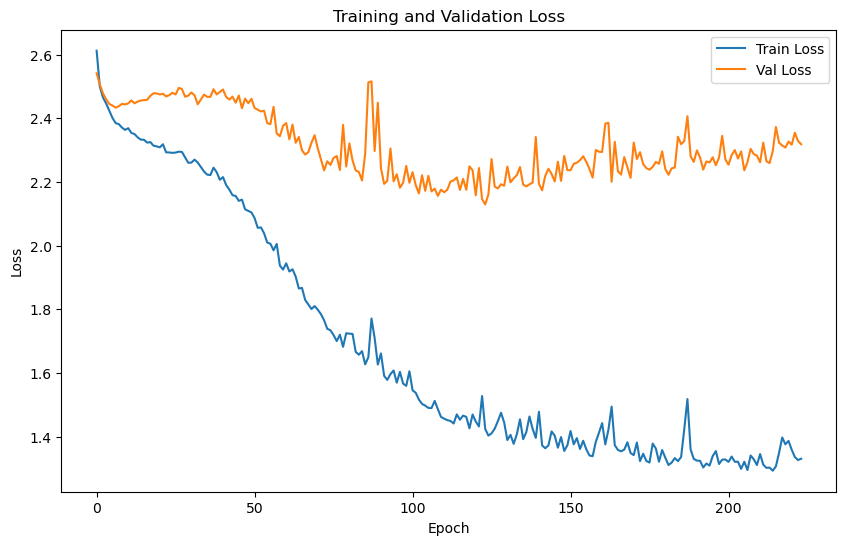

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.9415 | Test Accuracy: 40.96%


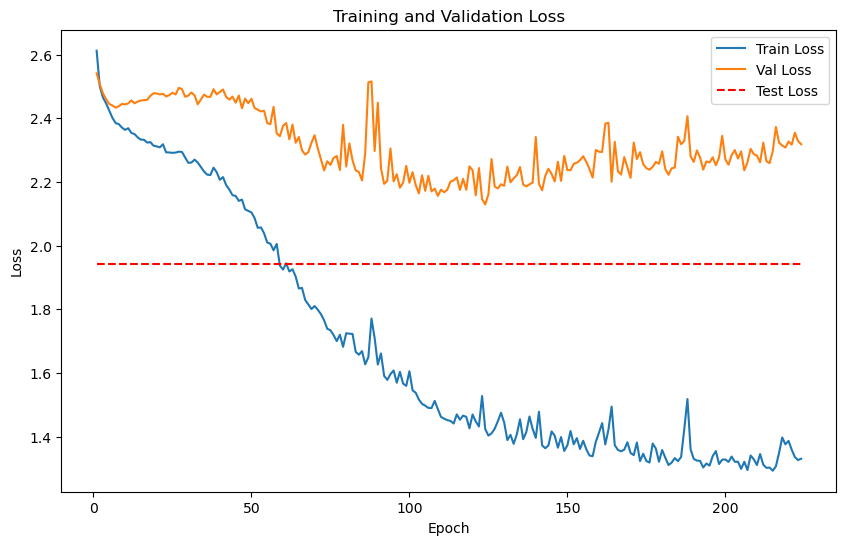

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)


Train embeddings shape: (520, 64), 
Train labels shape: (520,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4626, 64), 
Test labels shape: (4626,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 8.1960
    Batch [2/2], Train Loss: 8.0699
Epoch [1/2000], Avg Train Loss: 8.1329
Epoch [1/2000], Avg Val Loss: 6.0265
Validation loss improved from inf to 6.0265. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 7.9519
    Batch [2/2], Train Loss: 7.7999
Epoch [2/2000], Avg Train Loss: 7.8759
Epoch [2/2000], Avg Val Loss: 5.9686
Validation loss improved from 6.0265 to 5.9686. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.9482
    Batch [2/2], Train Loss: 8.0816
Epoch [3/2000], Avg Train Loss: 8.0149
Epoch [3/2000], Avg Val Loss: 5.9073
Validation loss improved from 5.9686 to 5.9073. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.9668
    Batch [2/2], Train Loss: 7.7999
Epoch [4/2000], Avg Train Loss: 7.8833
Epoch [4/2000], Avg Val Loss: 5.8419
Validation loss improved from 5.9073 to 5.8419. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss

    Batch [2/2], Train Loss: 7.2283
Epoch [9/2000], Avg Train Loss: 7.2943
Epoch [9/2000], Avg Val Loss: 5.5104
Validation loss improved from 5.5771 to 5.5104. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 7.2381
    Batch [2/2], Train Loss: 7.2700
Epoch [10/2000], Avg Train Loss: 7.2540
Epoch [10/2000], Avg Val Loss: 5.4434
Validation loss improved from 5.5104 to 5.4434. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 7.0849
    Batch [2/2], Train Loss: 7.1118
Epoch [11/2000], Avg Train Loss: 7.0983
Epoch [11/2000], Avg Val Loss: 5.3769
Validation loss improved from 5.4434 to 5.3769. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 7.0864
    Batch [2/2], Train Loss: 7.0643
Epoch [12/2000], Avg Train Loss: 7.0753
Epoch [12/2000], Avg Val Loss: 5.3108
Validation loss improved from 5.3769 to 5.3108. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.9448
    Batch [2/2

    Batch [1/2], Train Loss: 6.9432
    Batch [2/2], Train Loss: 6.7931
Epoch [14/2000], Avg Train Loss: 6.8681
Epoch [14/2000], Avg Val Loss: 5.1789
Validation loss improved from 5.2443 to 5.1789. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.8777
    Batch [2/2], Train Loss: 6.7318
Epoch [15/2000], Avg Train Loss: 6.8047
Epoch [15/2000], Avg Val Loss: 5.1148
Validation loss improved from 5.1789 to 5.1148. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 6.7841
    Batch [2/2], Train Loss: 6.6672
Epoch [16/2000], Avg Train Loss: 6.7257
Epoch [16/2000], Avg Val Loss: 5.0521
Validation loss improved from 5.1148 to 5.0521. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 6.7374
    Batch [2/2], Train Loss: 6.6610
Epoch [17/2000], Avg Train Loss: 6.6992
Epoch [17/2000], Avg Val Loss: 4.9910
Validation loss improved from 5.0521 to 4.9910. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 6.4108
    Batch [2/2], Train Loss: 6.3481
Epoch [22/2000], Avg Train Loss: 6.3795
Epoch [22/2000], Avg Val Loss: 4.7105
Validation loss improved from 4.7619 to 4.7105. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 6.3742
    Batch [2/2], Train Loss: 6.3761
Epoch [23/2000], Avg Train Loss: 6.3751
Epoch [23/2000], Avg Val Loss: 4.6609
Validation loss improved from 4.7105 to 4.6609. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 6.3332
    Batch [2/2], Train Loss: 6.2857
Epoch [24/2000], Avg Train Loss: 6.3094
Epoch [24/2000], Avg Val Loss: 4.6138
Validation loss improved from 4.6609 to 4.6138. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 6.3688
    Batch [2/2], Train Loss: 6.2280
Epoch [25/2000], Avg Train Loss: 6.2984
Epoch [25/2000], Avg Val Loss: 4.5688
Validation loss improved from 4.6138 to 4.5688. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 6.0710
Epoch [31/2000], Avg Train Loss: 6.0128
Epoch [31/2000], Avg Val Loss: 4.3578
Validation loss improved from 4.3871 to 4.3578. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 6.1035
    Batch [2/2], Train Loss: 6.0231
Epoch [32/2000], Avg Train Loss: 6.0633
Epoch [32/2000], Avg Val Loss: 4.3293
Validation loss improved from 4.3578 to 4.3293. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 5.9398
    Batch [2/2], Train Loss: 5.9600
Epoch [33/2000], Avg Train Loss: 5.9499
Epoch [33/2000], Avg Val Loss: 4.3025
Validation loss improved from 4.3293 to 4.3025. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.9472
    Batch [2/2], Train Loss: 5.9530
Epoch [34/2000], Avg Train Loss: 5.9501
Epoch [34/2000], Avg Val Loss: 4.2778
Validation loss improved from 4.3025 to 4.2778. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.9003
    Batch [2

Epoch [35/2000], Avg Val Loss: 4.2548
Validation loss improved from 4.2778 to 4.2548. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.9558
    Batch [2/2], Train Loss: 5.8288
Epoch [36/2000], Avg Train Loss: 5.8923
Epoch [36/2000], Avg Val Loss: 4.2334
Validation loss improved from 4.2548 to 4.2334. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.9091
    Batch [2/2], Train Loss: 5.7595
Epoch [37/2000], Avg Train Loss: 5.8343
Epoch [37/2000], Avg Val Loss: 4.2136
Validation loss improved from 4.2334 to 4.2136. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 5.8648
    Batch [2/2], Train Loss: 5.8139
Epoch [38/2000], Avg Train Loss: 5.8393
Epoch [38/2000], Avg Val Loss: 4.1954
Validation loss improved from 4.2136 to 4.1954. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 5.8518
    Batch [2/2], Train Loss: 5.8355
Epoch [39/2000], Avg Train Loss: 5.8437
Epoch [39/20

    Batch [2/2], Train Loss: 5.8031
Epoch [44/2000], Avg Train Loss: 5.7485
Epoch [44/2000], Avg Val Loss: 4.1049
Validation loss improved from 4.1179 to 4.1049. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 5.7716
    Batch [2/2], Train Loss: 5.6629
Epoch [45/2000], Avg Train Loss: 5.7173
Epoch [45/2000], Avg Val Loss: 4.0927
Validation loss improved from 4.1049 to 4.0927. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 5.6913
    Batch [2/2], Train Loss: 5.6949
Epoch [46/2000], Avg Train Loss: 5.6931
Epoch [46/2000], Avg Val Loss: 4.0817
Validation loss improved from 4.0927 to 4.0817. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 5.6895
    Batch [2/2], Train Loss: 5.6915
Epoch [47/2000], Avg Train Loss: 5.6905
Epoch [47/2000], Avg Val Loss: 4.0713
Validation loss improved from 4.0817 to 4.0713. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 5.6873
    Batch [2

    Batch [2/2], Train Loss: 5.5908
Epoch [54/2000], Avg Train Loss: 5.5968
Epoch [54/2000], Avg Val Loss: 4.0091
Validation loss improved from 4.0172 to 4.0091. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 5.6395
    Batch [2/2], Train Loss: 5.5521
Epoch [55/2000], Avg Train Loss: 5.5958
Epoch [55/2000], Avg Val Loss: 4.0011
Validation loss improved from 4.0091 to 4.0011. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 5.5940
    Batch [2/2], Train Loss: 5.6037
Epoch [56/2000], Avg Train Loss: 5.5989
Epoch [56/2000], Avg Val Loss: 3.9936
Validation loss improved from 4.0011 to 3.9936. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 5.5499
    Batch [2/2], Train Loss: 5.5606
Epoch [57/2000], Avg Train Loss: 5.5552
Epoch [57/2000], Avg Val Loss: 3.9864
Validation loss improved from 3.9936 to 3.9864. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 5.5727
    Batch [2

    Batch [2/2], Train Loss: 5.5720
Epoch [59/2000], Avg Train Loss: 5.5818
Epoch [59/2000], Avg Val Loss: 3.9730
Validation loss improved from 3.9796 to 3.9730. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 5.5278
    Batch [2/2], Train Loss: 5.5127
Epoch [60/2000], Avg Train Loss: 5.5202
Epoch [60/2000], Avg Val Loss: 3.9669
Validation loss improved from 3.9730 to 3.9669. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 5.5346
    Batch [2/2], Train Loss: 5.4960
Epoch [61/2000], Avg Train Loss: 5.5153
Epoch [61/2000], Avg Val Loss: 3.9610
Validation loss improved from 3.9669 to 3.9610. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 5.5050
    Batch [2/2], Train Loss: 5.5062
Epoch [62/2000], Avg Train Loss: 5.5056
Epoch [62/2000], Avg Val Loss: 3.9552
Validation loss improved from 3.9610 to 3.9552. Saving model...

LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 5.4916
    Batch [2

    Batch [1/2], Train Loss: 5.4923
    Batch [2/2], Train Loss: 5.4604
Epoch [67/2000], Avg Train Loss: 5.4764
Epoch [67/2000], Avg Val Loss: 3.9279
Validation loss improved from 3.9332 to 3.9279. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 5.4675
    Batch [2/2], Train Loss: 5.4512
Epoch [68/2000], Avg Train Loss: 5.4594
Epoch [68/2000], Avg Val Loss: 3.9226
Validation loss improved from 3.9279 to 3.9226. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 5.4330
    Batch [2/2], Train Loss: 5.4832
Epoch [69/2000], Avg Train Loss: 5.4581
Epoch [69/2000], Avg Val Loss: 3.9176
Validation loss improved from 3.9226 to 3.9176. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 5.4690
    Batch [2/2], Train Loss: 5.3845
Epoch [70/2000], Avg Train Loss: 5.4267
Epoch [70/2000], Avg Val Loss: 3.9129
Validation loss improved from 3.9176 to 3.9129. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.3984
Epoch [74/2000], Avg Train Loss: 5.4108
Epoch [74/2000], Avg Val Loss: 3.8960
Validation loss improved from 3.9000 to 3.8960. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 5.4109
    Batch [2/2], Train Loss: 5.3774
Epoch [75/2000], Avg Train Loss: 5.3941
Epoch [75/2000], Avg Val Loss: 3.8920
Validation loss improved from 3.8960 to 3.8920. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 5.4460
    Batch [2/2], Train Loss: 5.4162
Epoch [76/2000], Avg Train Loss: 5.4311
Epoch [76/2000], Avg Val Loss: 3.8879
Validation loss improved from 3.8920 to 3.8879. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 5.3874
    Batch [2/2], Train Loss: 5.4164
Epoch [77/2000], Avg Train Loss: 5.4019
Epoch [77/2000], Avg Val Loss: 3.8840
Validation loss improved from 3.8879 to 3.8840. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 5.3423
    Batch [2

    Batch [2/2], Train Loss: 5.3331
Epoch [80/2000], Avg Train Loss: 5.3611
Epoch [80/2000], Avg Val Loss: 3.8737
Validation loss improved from 3.8770 to 3.8737. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 5.3764
    Batch [2/2], Train Loss: 5.3232
Epoch [81/2000], Avg Train Loss: 5.3498
Epoch [81/2000], Avg Val Loss: 3.8708
Validation loss improved from 3.8737 to 3.8708. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 5.3477
    Batch [2/2], Train Loss: 5.3776
Epoch [82/2000], Avg Train Loss: 5.3626
Epoch [82/2000], Avg Val Loss: 3.8678
Validation loss improved from 3.8708 to 3.8678. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 5.2980
    Batch [2/2], Train Loss: 5.3062
Epoch [83/2000], Avg Train Loss: 5.3021
Epoch [83/2000], Avg Val Loss: 3.8650
Validation loss improved from 3.8678 to 3.8650. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 5.3096
    Batch [2

    Batch [2/2], Train Loss: 5.3345
Epoch [88/2000], Avg Train Loss: 5.3303
Epoch [88/2000], Avg Val Loss: 3.8531
Validation loss improved from 3.8553 to 3.8531. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 5.2917
    Batch [2/2], Train Loss: 5.2872
Epoch [89/2000], Avg Train Loss: 5.2895
Epoch [89/2000], Avg Val Loss: 3.8511
Validation loss improved from 3.8531 to 3.8511. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 5.2743
    Batch [2/2], Train Loss: 5.2366
Epoch [90/2000], Avg Train Loss: 5.2555
Epoch [90/2000], Avg Val Loss: 3.8496
Validation loss improved from 3.8511 to 3.8496. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 5.3380
    Batch [2/2], Train Loss: 5.3342
Epoch [91/2000], Avg Train Loss: 5.3361
Epoch [91/2000], Avg Val Loss: 3.8480
Validation loss improved from 3.8496 to 3.8480. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 5.3170
    Batch [2

    Batch [1/2], Train Loss: 5.2791
    Batch [2/2], Train Loss: 5.2694
Epoch [96/2000], Avg Train Loss: 5.2742
Epoch [96/2000], Avg Val Loss: 3.8402
Validation loss improved from 3.8419 to 3.8402. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 5.2841
    Batch [2/2], Train Loss: 5.2941
Epoch [97/2000], Avg Train Loss: 5.2891
Epoch [97/2000], Avg Val Loss: 3.8385
Validation loss improved from 3.8402 to 3.8385. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 5.3110
    Batch [2/2], Train Loss: 5.2879
Epoch [98/2000], Avg Train Loss: 5.2995
Epoch [98/2000], Avg Val Loss: 3.8367
Validation loss improved from 3.8385 to 3.8367. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 5.2772
    Batch [2/2], Train Loss: 5.2205
Epoch [99/2000], Avg Train Loss: 5.2489
Epoch [99/2000], Avg Val Loss: 3.8350
Validation loss improved from 3.8367 to 3.8350. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [

    Batch [1/2], Train Loss: 5.2415
    Batch [2/2], Train Loss: 5.2342
Epoch [102/2000], Avg Train Loss: 5.2378
Epoch [102/2000], Avg Val Loss: 3.8318
Validation loss improved from 3.8327 to 3.8318. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 5.2541
    Batch [2/2], Train Loss: 5.2829
Epoch [103/2000], Avg Train Loss: 5.2685
Epoch [103/2000], Avg Val Loss: 3.8310
Validation loss improved from 3.8318 to 3.8310. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 5.2393
    Batch [2/2], Train Loss: 5.2155
Epoch [104/2000], Avg Train Loss: 5.2274
Epoch [104/2000], Avg Val Loss: 3.8298
Validation loss improved from 3.8310 to 3.8298. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 5.2669
    Batch [2/2], Train Loss: 5.2690
Epoch [105/2000], Avg Train Loss: 5.2679
Epoch [105/2000], Avg Val Loss: 3.8285
Validation loss improved from 3.8298 to 3.8285. Saving model...

LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 5.2461
    Batch [2/2], Train Loss: 5.2423
Epoch [112/2000], Avg Train Loss: 5.2442
Epoch [112/2000], Avg Val Loss: 3.8194
Validation loss improved from 3.8206 to 3.8194. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 5.2285
    Batch [2/2], Train Loss: 5.2518
Epoch [113/2000], Avg Train Loss: 5.2402
Epoch [113/2000], Avg Val Loss: 3.8181
Validation loss improved from 3.8194 to 3.8181. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 5.1341
    Batch [2/2], Train Loss: 5.2041
Epoch [114/2000], Avg Train Loss: 5.1691
Epoch [114/2000], Avg Val Loss: 3.8170
Validation loss improved from 3.8181 to 3.8170. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 5.2387
    Batch [2/2], Train Loss: 5.2525
Epoch [115/2000], Avg Train Loss: 5.2456
Epoch [115/2000], Avg Val Loss: 3.8155
Validation loss improved from 3.8170 to 3.8155. Saving model...

LOG: Epoch [116/2000] - Training


    Batch [2/2], Train Loss: 5.1777
Epoch [119/2000], Avg Train Loss: 5.1683
Epoch [119/2000], Avg Val Loss: 3.8077
Validation loss improved from 3.8096 to 3.8077. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 5.1147
    Batch [2/2], Train Loss: 5.1490
Epoch [120/2000], Avg Train Loss: 5.1319
Epoch [120/2000], Avg Val Loss: 3.8062
Validation loss improved from 3.8077 to 3.8062. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 5.1878
    Batch [2/2], Train Loss: 5.2210
Epoch [121/2000], Avg Train Loss: 5.2044
Epoch [121/2000], Avg Val Loss: 3.8049
Validation loss improved from 3.8062 to 3.8049. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 5.1589
    Batch [2/2], Train Loss: 5.1620
Epoch [122/2000], Avg Train Loss: 5.1604
Epoch [122/2000], Avg Val Loss: 3.8037
Validation loss improved from 3.8049 to 3.8037. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 5.2030


    Batch [2/2], Train Loss: 5.1025
Epoch [124/2000], Avg Train Loss: 5.1444
Epoch [124/2000], Avg Val Loss: 3.8003
Validation loss improved from 3.8021 to 3.8003. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 5.2464
    Batch [2/2], Train Loss: 5.2173
Epoch [125/2000], Avg Train Loss: 5.2319
Epoch [125/2000], Avg Val Loss: 3.7987
Validation loss improved from 3.8003 to 3.7987. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 5.1386
    Batch [2/2], Train Loss: 5.2416
Epoch [126/2000], Avg Train Loss: 5.1901
Epoch [126/2000], Avg Val Loss: 3.7971
Validation loss improved from 3.7987 to 3.7971. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 5.1623
    Batch [2/2], Train Loss: 5.2012
Epoch [127/2000], Avg Train Loss: 5.1817
Epoch [127/2000], Avg Val Loss: 3.7956
Validation loss improved from 3.7971 to 3.7956. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 5.2022


    Batch [2/2], Train Loss: 5.1614
Epoch [133/2000], Avg Train Loss: 5.1487
Epoch [133/2000], Avg Val Loss: 3.7857
Validation loss improved from 3.7871 to 3.7857. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 5.1675
    Batch [2/2], Train Loss: 5.1675
Epoch [134/2000], Avg Train Loss: 5.1675
Epoch [134/2000], Avg Val Loss: 3.7842
Validation loss improved from 3.7857 to 3.7842. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 5.1537
    Batch [2/2], Train Loss: 5.1784
Epoch [135/2000], Avg Train Loss: 5.1660
Epoch [135/2000], Avg Val Loss: 3.7829
Validation loss improved from 3.7842 to 3.7829. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 5.1926
    Batch [2/2], Train Loss: 5.1352
Epoch [136/2000], Avg Train Loss: 5.1639
Epoch [136/2000], Avg Val Loss: 3.7813
Validation loss improved from 3.7829 to 3.7813. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 5.1323


    Batch [1/2], Train Loss: 5.1834
    Batch [2/2], Train Loss: 5.0997
Epoch [141/2000], Avg Train Loss: 5.1416
Epoch [141/2000], Avg Val Loss: 3.7754
Validation loss improved from 3.7766 to 3.7754. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 5.1971
    Batch [2/2], Train Loss: 5.1463
Epoch [142/2000], Avg Train Loss: 5.1717
Epoch [142/2000], Avg Val Loss: 3.7742
Validation loss improved from 3.7754 to 3.7742. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 5.1308
    Batch [2/2], Train Loss: 5.1524
Epoch [143/2000], Avg Train Loss: 5.1416
Epoch [143/2000], Avg Val Loss: 3.7726
Validation loss improved from 3.7742 to 3.7726. Saving model...

LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 5.1150
    Batch [2/2], Train Loss: 5.1363
Epoch [144/2000], Avg Train Loss: 5.1256
Epoch [144/2000], Avg Val Loss: 3.7709
Validation loss improved from 3.7726 to 3.7709. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 5.0941
    Batch [2/2], Train Loss: 5.1400
Epoch [145/2000], Avg Train Loss: 5.1170
Epoch [145/2000], Avg Val Loss: 3.7691
Validation loss improved from 3.7709 to 3.7691. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 5.1161
    Batch [2/2], Train Loss: 5.1183
Epoch [146/2000], Avg Train Loss: 5.1172
Epoch [146/2000], Avg Val Loss: 3.7676
Validation loss improved from 3.7691 to 3.7676. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 5.0545
    Batch [2/2], Train Loss: 5.0440
Epoch [147/2000], Avg Train Loss: 5.0492
Epoch [147/2000], Avg Val Loss: 3.7665
Validation loss improved from 3.7676 to 3.7665. Saving model...

LOG: Epoch [148/2000] - Training


    Batch [2/2], Train Loss: 5.0730
Epoch [154/2000], Avg Train Loss: 5.1002
Epoch [154/2000], Avg Val Loss: 3.7589
Validation loss improved from 3.7601 to 3.7589. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 5.1172
    Batch [2/2], Train Loss: 5.1182
Epoch [155/2000], Avg Train Loss: 5.1177
Epoch [155/2000], Avg Val Loss: 3.7577
Validation loss improved from 3.7589 to 3.7577. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 5.1340
    Batch [2/2], Train Loss: 5.1074
Epoch [156/2000], Avg Train Loss: 5.1207
Epoch [156/2000], Avg Val Loss: 3.7559
Validation loss improved from 3.7577 to 3.7559. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 5.1639
    Batch [2/2], Train Loss: 5.1045
Epoch [157/2000], Avg Train Loss: 5.1342
Epoch [157/2000], Avg Val Loss: 3.7540
Validation loss improved from 3.7559 to 3.7540. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 5.0889


    Batch [1/2], Train Loss: 5.0829
    Batch [2/2], Train Loss: 5.0522
Epoch [163/2000], Avg Train Loss: 5.0675
Epoch [163/2000], Avg Val Loss: 3.7438
Validation loss improved from 3.7455 to 3.7438. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 5.0613
    Batch [2/2], Train Loss: 5.0861
Epoch [164/2000], Avg Train Loss: 5.0737
Epoch [164/2000], Avg Val Loss: 3.7425
Validation loss improved from 3.7438 to 3.7425. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 5.1040
    Batch [2/2], Train Loss: 5.1213
Epoch [165/2000], Avg Train Loss: 5.1127
Epoch [165/2000], Avg Val Loss: 3.7410
Validation loss improved from 3.7425 to 3.7410. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 5.0566
    Batch [2/2], Train Loss: 5.0766
Epoch [166/2000], Avg Train Loss: 5.0666
Epoch [166/2000], Avg Val Loss: 3.7395
Validation loss improved from 3.7410 to 3.7395. Saving model...

LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 5.0528
    Batch [2/2], Train Loss: 5.1252
Epoch [178/2000], Avg Train Loss: 5.0890
Epoch [178/2000], Avg Val Loss: 3.7156
Validation loss improved from 3.7178 to 3.7156. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 5.0277
    Batch [2/2], Train Loss: 5.0398
Epoch [179/2000], Avg Train Loss: 5.0338
Epoch [179/2000], Avg Val Loss: 3.7137
Validation loss improved from 3.7156 to 3.7137. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 5.0727
    Batch [2/2], Train Loss: 5.0564
Epoch [180/2000], Avg Train Loss: 5.0645
Epoch [180/2000], Avg Val Loss: 3.7116
Validation loss improved from 3.7137 to 3.7116. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 5.0554
    Batch [2/2], Train Loss: 5.0728
Epoch [181/2000], Avg Train Loss: 5.0641
Epoch [181/2000], Avg Val Loss: 3.7093
Validation loss improved from 3.7116 to 3.7093. Saving model...

LOG: Epoch [182/2000] - Training


    Batch [2/2], Train Loss: 5.0078
Epoch [184/2000], Avg Train Loss: 5.0087
Epoch [184/2000], Avg Val Loss: 3.7047
Validation loss improved from 3.7058 to 3.7047. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 5.0110
    Batch [2/2], Train Loss: 5.0119
Epoch [185/2000], Avg Train Loss: 5.0114
Epoch [185/2000], Avg Val Loss: 3.7034
Validation loss improved from 3.7047 to 3.7034. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 5.0048
    Batch [2/2], Train Loss: 5.0137
Epoch [186/2000], Avg Train Loss: 5.0092
Epoch [186/2000], Avg Val Loss: 3.7019
Validation loss improved from 3.7034 to 3.7019. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 5.0236
    Batch [2/2], Train Loss: 5.0520
Epoch [187/2000], Avg Train Loss: 5.0378
Epoch [187/2000], Avg Val Loss: 3.7000
Validation loss improved from 3.7019 to 3.7000. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 5.0576


Epoch [200/2000], Avg Val Loss: 3.6817
Validation loss improved from 3.6840 to 3.6817. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 5.0207
    Batch [2/2], Train Loss: 5.0521
Epoch [201/2000], Avg Train Loss: 5.0364
Epoch [201/2000], Avg Val Loss: 3.6786
Validation loss improved from 3.6817 to 3.6786. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 5.0097
    Batch [2/2], Train Loss: 5.0248
Epoch [202/2000], Avg Train Loss: 5.0172
Epoch [202/2000], Avg Val Loss: 3.6757
Validation loss improved from 3.6786 to 3.6757. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 5.0027
    Batch [2/2], Train Loss: 4.9723
Epoch [203/2000], Avg Train Loss: 4.9875
Epoch [203/2000], Avg Val Loss: 3.6728
Validation loss improved from 3.6757 to 3.6728. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 4.9862
    Batch [2/2], Train Loss: 5.0711
Epoch [204/2000], Avg Train Loss: 5.0287


    Batch [2/2], Train Loss: 4.9412
Epoch [206/2000], Avg Train Loss: 4.9630
Epoch [206/2000], Avg Val Loss: 3.6653
Validation loss improved from 3.6674 to 3.6653. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 5.0393
    Batch [2/2], Train Loss: 5.0018
Epoch [207/2000], Avg Train Loss: 5.0206
Epoch [207/2000], Avg Val Loss: 3.6635
Validation loss improved from 3.6653 to 3.6635. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 4.9739
    Batch [2/2], Train Loss: 4.9872
Epoch [208/2000], Avg Train Loss: 4.9805
Epoch [208/2000], Avg Val Loss: 3.6621
Validation loss improved from 3.6635 to 3.6621. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 4.9634
    Batch [2/2], Train Loss: 5.0077
Epoch [209/2000], Avg Train Loss: 4.9855
Epoch [209/2000], Avg Val Loss: 3.6605
Validation loss improved from 3.6621 to 3.6605. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 4.9604


    Batch [1/2], Train Loss: 4.9765
    Batch [2/2], Train Loss: 4.9269
Epoch [222/2000], Avg Train Loss: 4.9517
Epoch [222/2000], Avg Val Loss: 3.6394
Validation loss improved from 3.6404 to 3.6394. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 4.9762
    Batch [2/2], Train Loss: 4.9567
Epoch [223/2000], Avg Train Loss: 4.9664
Epoch [223/2000], Avg Val Loss: 3.6392
Validation loss improved from 3.6394 to 3.6392. Saving model...

LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 4.9526
    Batch [2/2], Train Loss: 4.9583
Epoch [224/2000], Avg Train Loss: 4.9554
Epoch [224/2000], Avg Val Loss: 3.6388
Validation loss improved from 3.6392 to 3.6388. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 4.9245
    Batch [2/2], Train Loss: 4.9540
Epoch [225/2000], Avg Train Loss: 4.9393
Epoch [225/2000], Avg Val Loss: 3.6377
Validation loss improved from 3.6388 to 3.6377. Saving model...

LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 4.9582
    Batch [2/2], Train Loss: 5.0331
Epoch [230/2000], Avg Train Loss: 4.9957
Epoch [230/2000], Avg Val Loss: 3.6282
Validation loss improved from 3.6307 to 3.6282. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 4.8962
    Batch [2/2], Train Loss: 4.9275
Epoch [231/2000], Avg Train Loss: 4.9118
Epoch [231/2000], Avg Val Loss: 3.6254
Validation loss improved from 3.6282 to 3.6254. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 4.9568
    Batch [2/2], Train Loss: 4.8679
Epoch [232/2000], Avg Train Loss: 4.9123
Epoch [232/2000], Avg Val Loss: 3.6221
Validation loss improved from 3.6254 to 3.6221. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 4.9828
    Batch [2/2], Train Loss: 4.9415
Epoch [233/2000], Avg Train Loss: 4.9621
Epoch [233/2000], Avg Val Loss: 3.6192
Validation loss improved from 3.6221 to 3.6192. Saving model...

LOG: Epoch [234/2000] - Training


    Batch [2/2], Train Loss: 4.9421
Epoch [244/2000], Avg Train Loss: 4.9509
Epoch [244/2000], Avg Val Loss: 3.6036
Validation loss improved from 3.6049 to 3.6036. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 4.9483
    Batch [2/2], Train Loss: 4.9424
Epoch [245/2000], Avg Train Loss: 4.9454
Epoch [245/2000], Avg Val Loss: 3.6021
Validation loss improved from 3.6036 to 3.6021. Saving model...

LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 4.8634
    Batch [2/2], Train Loss: 4.9223
Epoch [246/2000], Avg Train Loss: 4.8929
Epoch [246/2000], Avg Val Loss: 3.6015
Validation loss improved from 3.6021 to 3.6015. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 4.8971
    Batch [2/2], Train Loss: 4.9240
Epoch [247/2000], Avg Train Loss: 4.9105
Epoch [247/2000], Avg Val Loss: 3.6008
Validation loss improved from 3.6015 to 3.6008. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 4.9841


    Batch [1/2], Train Loss: 4.9234
    Batch [2/2], Train Loss: 4.8518
Epoch [252/2000], Avg Train Loss: 4.8876
Epoch [252/2000], Avg Val Loss: 3.5942
Validation loss improved from 3.5948 to 3.5942. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 4.9061
    Batch [2/2], Train Loss: 4.9575
Epoch [253/2000], Avg Train Loss: 4.9318
Epoch [253/2000], Avg Val Loss: 3.5938
Validation loss improved from 3.5942 to 3.5938. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 4.9230
    Batch [2/2], Train Loss: 4.9479
Epoch [254/2000], Avg Train Loss: 4.9355
Epoch [254/2000], Avg Val Loss: 3.5925
Validation loss improved from 3.5938 to 3.5925. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 4.8938
    Batch [2/2], Train Loss: 4.9144
Epoch [255/2000], Avg Train Loss: 4.9041
Epoch [255/2000], Avg Val Loss: 3.5906
Validation loss improved from 3.5925 to 3.5906. Saving model...

LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 4.8675
    Batch [2/2], Train Loss: 4.8986
Epoch [266/2000], Avg Train Loss: 4.8831
Epoch [266/2000], Avg Val Loss: 3.5783
Validation loss improved from 3.5793 to 3.5783. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 4.8748
    Batch [2/2], Train Loss: 4.9608
Epoch [267/2000], Avg Train Loss: 4.9178
Epoch [267/2000], Avg Val Loss: 3.5763
Validation loss improved from 3.5783 to 3.5763. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 4.8512
    Batch [2/2], Train Loss: 4.9493
Epoch [268/2000], Avg Train Loss: 4.9002
Epoch [268/2000], Avg Val Loss: 3.5744
Validation loss improved from 3.5763 to 3.5744. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 4.8014
    Batch [2/2], Train Loss: 4.8817
Epoch [269/2000], Avg Train Loss: 4.8416
Epoch [269/2000], Avg Val Loss: 3.5729
Validation loss improved from 3.5744 to 3.5729. Saving model...

LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 4.8256
    Batch [2/2], Train Loss: 4.8473
Epoch [275/2000], Avg Train Loss: 4.8364
Epoch [275/2000], Avg Val Loss: 3.5605
Validation loss improved from 3.5620 to 3.5605. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 4.8819
    Batch [2/2], Train Loss: 4.8773
Epoch [276/2000], Avg Train Loss: 4.8796
Epoch [276/2000], Avg Val Loss: 3.5587
Validation loss improved from 3.5605 to 3.5587. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 4.8254
    Batch [2/2], Train Loss: 4.8375
Epoch [277/2000], Avg Train Loss: 4.8314
Epoch [277/2000], Avg Val Loss: 3.5569
Validation loss improved from 3.5587 to 3.5569. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 4.8399
    Batch [2/2], Train Loss: 4.8554
Epoch [278/2000], Avg Train Loss: 4.8476
Epoch [278/2000], Avg Val Loss: 3.5552
Validation loss improved from 3.5569 to 3.5552. Saving model...

LOG: Epoch [279/2000] - Training


    Batch [2/2], Train Loss: 4.8288
Epoch [287/2000], Avg Train Loss: 4.8447
Epoch [287/2000], Avg Val Loss: 3.5478
Validation loss improved from 3.5479 to 3.5478. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 4.8824
    Batch [2/2], Train Loss: 4.8180
Epoch [288/2000], Avg Train Loss: 4.8502
Epoch [288/2000], Avg Val Loss: 3.5471
Validation loss improved from 3.5478 to 3.5471. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 4.7644
    Batch [2/2], Train Loss: 4.8593
Epoch [289/2000], Avg Train Loss: 4.8118
Epoch [289/2000], Avg Val Loss: 3.5470
Validation loss improved from 3.5471 to 3.5470. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 4.8664
    Batch [2/2], Train Loss: 4.7856
Epoch [290/2000], Avg Train Loss: 4.8260
Epoch [290/2000], Avg Val Loss: 3.5463
Validation loss improved from 3.5470 to 3.5463. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 4.8206


    Batch [1/2], Train Loss: 4.8072
    Batch [2/2], Train Loss: 4.8523
Epoch [298/2000], Avg Train Loss: 4.8297
Epoch [298/2000], Avg Val Loss: 3.5363
Validation loss improved from 3.5373 to 3.5363. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 4.8589
    Batch [2/2], Train Loss: 4.8524
Epoch [299/2000], Avg Train Loss: 4.8557
Epoch [299/2000], Avg Val Loss: 3.5355
Validation loss improved from 3.5363 to 3.5355. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 4.8355
    Batch [2/2], Train Loss: 4.8646
Epoch [300/2000], Avg Train Loss: 4.8500
Epoch [300/2000], Avg Val Loss: 3.5344
Validation loss improved from 3.5355 to 3.5344. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 4.7452
    Batch [2/2], Train Loss: 4.7502
Epoch [301/2000], Avg Train Loss: 4.7477
Epoch [301/2000], Avg Val Loss: 3.5339
Validation loss improved from 3.5344 to 3.5339. Saving model...

LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 4.8969
    Batch [2/2], Train Loss: 4.7771
Epoch [308/2000], Avg Train Loss: 4.8370
Epoch [308/2000], Avg Val Loss: 3.5238
Validation loss improved from 3.5244 to 3.5238. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 4.7740
    Batch [2/2], Train Loss: 4.9286
Epoch [309/2000], Avg Train Loss: 4.8513
Epoch [309/2000], Avg Val Loss: 3.5243
Validation loss did not improve. Patience: 1/100

LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 4.8062
    Batch [2/2], Train Loss: 4.7901
Epoch [310/2000], Avg Train Loss: 4.7981
Epoch [310/2000], Avg Val Loss: 3.5244
Validation loss did not improve. Patience: 2/100

LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 4.8202
    Batch [2/2], Train Loss: 4.8915
Epoch [311/2000], Avg Train Loss: 4.8558
Epoch [311/2000], Avg Val Loss: 3.5247
Validation loss did not improve. Patience: 3/100

LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 4.8974
    Batch

    Batch [1/2], Train Loss: 4.8532
    Batch [2/2], Train Loss: 4.7809
Epoch [320/2000], Avg Train Loss: 4.8170
Epoch [320/2000], Avg Val Loss: 3.5242
Validation loss did not improve. Patience: 12/100

LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 4.7310
    Batch [2/2], Train Loss: 4.7820
Epoch [321/2000], Avg Train Loss: 4.7565
Epoch [321/2000], Avg Val Loss: 3.5222
Validation loss improved from 3.5238 to 3.5222. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 4.8045
    Batch [2/2], Train Loss: 4.8386
Epoch [322/2000], Avg Train Loss: 4.8216
Epoch [322/2000], Avg Val Loss: 3.5201
Validation loss improved from 3.5222 to 3.5201. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 4.7661
    Batch [2/2], Train Loss: 4.8107
Epoch [323/2000], Avg Train Loss: 4.7884
Epoch [323/2000], Avg Val Loss: 3.5176
Validation loss improved from 3.5201 to 3.5176. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/2

Epoch [330/2000], Avg Val Loss: 3.5113
Validation loss improved from 3.5117 to 3.5113. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 4.8211
    Batch [2/2], Train Loss: 4.7757
Epoch [331/2000], Avg Train Loss: 4.7984
Epoch [331/2000], Avg Val Loss: 3.5115
Validation loss did not improve. Patience: 1/100

LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 4.8212
    Batch [2/2], Train Loss: 4.7645
Epoch [332/2000], Avg Train Loss: 4.7929
Epoch [332/2000], Avg Val Loss: 3.5103
Validation loss improved from 3.5113 to 3.5103. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 4.8809
    Batch [2/2], Train Loss: 4.7921
Epoch [333/2000], Avg Train Loss: 4.8365
Epoch [333/2000], Avg Val Loss: 3.5094
Validation loss improved from 3.5103 to 3.5094. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 4.8100
    Batch [2/2], Train Loss: 4.7684
Epoch [334/2000], Avg Train Loss: 4.7892
Epoch [334/2000

    Batch [1/2], Train Loss: 4.7643
    Batch [2/2], Train Loss: 4.7883
Epoch [342/2000], Avg Train Loss: 4.7763
Epoch [342/2000], Avg Val Loss: 3.5006
Validation loss improved from 3.5015 to 3.5006. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 4.7800
    Batch [2/2], Train Loss: 4.7892
Epoch [343/2000], Avg Train Loss: 4.7846
Epoch [343/2000], Avg Val Loss: 3.5001
Validation loss improved from 3.5006 to 3.5001. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 4.8520
    Batch [2/2], Train Loss: 4.8587
Epoch [344/2000], Avg Train Loss: 4.8554
Epoch [344/2000], Avg Val Loss: 3.4999
Validation loss improved from 3.5001 to 3.4999. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 4.8024
    Batch [2/2], Train Loss: 4.7471
Epoch [345/2000], Avg Train Loss: 4.7748
Epoch [345/2000], Avg Val Loss: 3.5001
Validation loss did not improve. Patience: 1/100

LOG: Epoch [346/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 4.8606
Epoch [353/2000], Avg Train Loss: 4.8241
Epoch [353/2000], Avg Val Loss: 3.4942
Validation loss improved from 3.4952 to 3.4942. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 4.7667
    Batch [2/2], Train Loss: 4.7576
Epoch [354/2000], Avg Train Loss: 4.7621
Epoch [354/2000], Avg Val Loss: 3.4935
Validation loss improved from 3.4942 to 3.4935. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 4.7935
    Batch [2/2], Train Loss: 4.7702
Epoch [355/2000], Avg Train Loss: 4.7818
Epoch [355/2000], Avg Val Loss: 3.4920
Validation loss improved from 3.4935 to 3.4920. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 4.8693
    Batch [2/2], Train Loss: 4.7925
Epoch [356/2000], Avg Train Loss: 4.8309
Epoch [356/2000], Avg Val Loss: 3.4897
Validation loss improved from 3.4920 to 3.4897. Saving model...

LOG: Epoch [357/2000] - Training
    Batch [1/2], Train Loss: 4.7430


    Batch [2/2], Train Loss: 4.8100
Epoch [365/2000], Avg Train Loss: 4.7750
Epoch [365/2000], Avg Val Loss: 3.4774
Validation loss improved from 3.4780 to 3.4774. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 4.8377
    Batch [2/2], Train Loss: 4.8298
Epoch [366/2000], Avg Train Loss: 4.8338
Epoch [366/2000], Avg Val Loss: 3.4774
Validation loss did not improve. Patience: 1/100

LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 4.7702
    Batch [2/2], Train Loss: 4.8229
Epoch [367/2000], Avg Train Loss: 4.7966
Epoch [367/2000], Avg Val Loss: 3.4786
Validation loss did not improve. Patience: 2/100

LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 4.8249
    Batch [2/2], Train Loss: 4.7867
Epoch [368/2000], Avg Train Loss: 4.8058
Epoch [368/2000], Avg Val Loss: 3.4795
Validation loss did not improve. Patience: 3/100

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 4.8808
    Batch [2/2], Train Loss: 4.8425
Epoch [36

    Batch [1/2], Train Loss: 4.8341
    Batch [2/2], Train Loss: 4.7398
Epoch [377/2000], Avg Train Loss: 4.7869
Epoch [377/2000], Avg Val Loss: 3.4793
Validation loss did not improve. Patience: 12/100

LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 4.8569
    Batch [2/2], Train Loss: 4.8478
Epoch [378/2000], Avg Train Loss: 4.8523
Epoch [378/2000], Avg Val Loss: 3.4749
Validation loss improved from 3.4774 to 3.4749. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 4.7822
    Batch [2/2], Train Loss: 4.7890
Epoch [379/2000], Avg Train Loss: 4.7856
Epoch [379/2000], Avg Val Loss: 3.4708
Validation loss improved from 3.4749 to 3.4708. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 4.7430
    Batch [2/2], Train Loss: 4.8353
Epoch [380/2000], Avg Train Loss: 4.7892
Epoch [380/2000], Avg Val Loss: 3.4674
Validation loss improved from 3.4708 to 3.4674. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/2

    Batch [2/2], Train Loss: 4.7439
Epoch [387/2000], Avg Train Loss: 4.7538
Epoch [387/2000], Avg Val Loss: 3.4631
Validation loss did not improve. Patience: 2/100

LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 4.6886
    Batch [2/2], Train Loss: 4.7079
Epoch [388/2000], Avg Train Loss: 4.6983
Epoch [388/2000], Avg Val Loss: 3.4634
Validation loss did not improve. Patience: 3/100

LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 4.7227
    Batch [2/2], Train Loss: 4.7856
Epoch [389/2000], Avg Train Loss: 4.7542
Epoch [389/2000], Avg Val Loss: 3.4638
Validation loss did not improve. Patience: 4/100

LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 4.8260
    Batch [2/2], Train Loss: 4.7640
Epoch [390/2000], Avg Train Loss: 4.7950
Epoch [390/2000], Avg Val Loss: 3.4645
Validation loss did not improve. Patience: 5/100

LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 4.7698
    Batch [2/2], Train Loss: 4.7803
Epoch [391/2000], Avg Tr

    Batch [2/2], Train Loss: 4.6714
Epoch [398/2000], Avg Train Loss: 4.7324
Epoch [398/2000], Avg Val Loss: 3.4544
Validation loss improved from 3.4550 to 3.4544. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 4.7846
    Batch [2/2], Train Loss: 4.7558
Epoch [399/2000], Avg Train Loss: 4.7702
Epoch [399/2000], Avg Val Loss: 3.4543
Validation loss improved from 3.4544 to 3.4543. Saving model...

LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 4.7642
    Batch [2/2], Train Loss: 4.7482
Epoch [400/2000], Avg Train Loss: 4.7562
Epoch [400/2000], Avg Val Loss: 3.4541
Validation loss improved from 3.4543 to 3.4541. Saving model...

LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 4.7480
    Batch [2/2], Train Loss: 4.8330
Epoch [401/2000], Avg Train Loss: 4.7905
Epoch [401/2000], Avg Val Loss: 3.4532
Validation loss improved from 3.4541 to 3.4532. Saving model...

LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 4.8041


    Batch [1/2], Train Loss: 4.7410
    Batch [2/2], Train Loss: 4.7314
Epoch [408/2000], Avg Train Loss: 4.7362
Epoch [408/2000], Avg Val Loss: 3.4551
Validation loss did not improve. Patience: 5/100

LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 4.6696
    Batch [2/2], Train Loss: 4.6329
Epoch [409/2000], Avg Train Loss: 4.6513
Epoch [409/2000], Avg Val Loss: 3.4537
Validation loss did not improve. Patience: 6/100

LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 4.7393
    Batch [2/2], Train Loss: 4.7181
Epoch [410/2000], Avg Train Loss: 4.7287
Epoch [410/2000], Avg Val Loss: 3.4520
Validation loss improved from 3.4525 to 3.4520. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 4.8040
    Batch [2/2], Train Loss: 4.7196
Epoch [411/2000], Avg Train Loss: 4.7618
Epoch [411/2000], Avg Val Loss: 3.4506
Validation loss improved from 3.4520 to 3.4506. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 4

    Batch [2/2], Train Loss: 4.7069
Epoch [420/2000], Avg Train Loss: 4.7178
Epoch [420/2000], Avg Val Loss: 3.4451
Validation loss improved from 3.4469 to 3.4451. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 4.7502
    Batch [2/2], Train Loss: 4.6915
Epoch [421/2000], Avg Train Loss: 4.7209
Epoch [421/2000], Avg Val Loss: 3.4437
Validation loss improved from 3.4451 to 3.4437. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 4.7310
    Batch [2/2], Train Loss: 4.7724
Epoch [422/2000], Avg Train Loss: 4.7517
Epoch [422/2000], Avg Val Loss: 3.4428
Validation loss improved from 3.4437 to 3.4428. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 4.6563
    Batch [2/2], Train Loss: 4.7112
Epoch [423/2000], Avg Train Loss: 4.6837
Epoch [423/2000], Avg Val Loss: 3.4418
Validation loss improved from 3.4428 to 3.4418. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 4.7241


    Batch [2/2], Train Loss: 4.6934
Epoch [430/2000], Avg Train Loss: 4.6772
Epoch [430/2000], Avg Val Loss: 3.4395
Validation loss did not improve. Patience: 2/100

LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 4.7017
    Batch [2/2], Train Loss: 4.7442
Epoch [431/2000], Avg Train Loss: 4.7230
Epoch [431/2000], Avg Val Loss: 3.4389
Validation loss did not improve. Patience: 3/100

LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 4.7574
    Batch [2/2], Train Loss: 4.7273
Epoch [432/2000], Avg Train Loss: 4.7423
Epoch [432/2000], Avg Val Loss: 3.4378
Validation loss improved from 3.4386 to 3.4378. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 4.7377
    Batch [2/2], Train Loss: 4.7021
Epoch [433/2000], Avg Train Loss: 4.7199
Epoch [433/2000], Avg Val Loss: 3.4370
Validation loss improved from 3.4378 to 3.4370. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 4.7474
    Batch [2/2], Train Loss: 4

    Batch [1/2], Train Loss: 4.7434
    Batch [2/2], Train Loss: 4.6851
Epoch [443/2000], Avg Train Loss: 4.7143
Epoch [443/2000], Avg Val Loss: 3.4279
Validation loss improved from 3.4280 to 3.4279. Saving model...

LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 4.7770
    Batch [2/2], Train Loss: 4.6317
Epoch [444/2000], Avg Train Loss: 4.7044
Epoch [444/2000], Avg Val Loss: 3.4279
Validation loss improved from 3.4279 to 3.4279. Saving model...

LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 4.6852
    Batch [2/2], Train Loss: 4.6695
Epoch [445/2000], Avg Train Loss: 4.6774
Epoch [445/2000], Avg Val Loss: 3.4273
Validation loss improved from 3.4279 to 3.4273. Saving model...

LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 4.7690
    Batch [2/2], Train Loss: 4.6523
Epoch [446/2000], Avg Train Loss: 4.7106
Epoch [446/2000], Avg Val Loss: 3.4262
Validation loss improved from 3.4273 to 3.4262. Saving model...

LOG: Epoch [447/2000] - Training


    Batch [2/2], Train Loss: 4.7381
Epoch [451/2000], Avg Train Loss: 4.7318
Epoch [451/2000], Avg Val Loss: 3.4215
Validation loss improved from 3.4231 to 3.4215. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 4.8302
    Batch [2/2], Train Loss: 4.6940
Epoch [452/2000], Avg Train Loss: 4.7621
Epoch [452/2000], Avg Val Loss: 3.4209
Validation loss improved from 3.4215 to 3.4209. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 4.7353
    Batch [2/2], Train Loss: 4.7725
Epoch [453/2000], Avg Train Loss: 4.7539
Epoch [453/2000], Avg Val Loss: 3.4204
Validation loss improved from 3.4209 to 3.4204. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 4.6386
    Batch [2/2], Train Loss: 4.6583
Epoch [454/2000], Avg Train Loss: 4.6485
Epoch [454/2000], Avg Val Loss: 3.4203
Validation loss improved from 3.4204 to 3.4203. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 4.7268


    Batch [1/2], Train Loss: 4.6519
    Batch [2/2], Train Loss: 4.6279
Epoch [467/2000], Avg Train Loss: 4.6399
Epoch [467/2000], Avg Val Loss: 3.4109
Validation loss did not improve. Patience: 1/100

LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 4.7073
    Batch [2/2], Train Loss: 4.7816
Epoch [468/2000], Avg Train Loss: 4.7444
Epoch [468/2000], Avg Val Loss: 3.4102
Validation loss improved from 3.4104 to 3.4102. Saving model...

LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 4.7233
    Batch [2/2], Train Loss: 4.6886
Epoch [469/2000], Avg Train Loss: 4.7059
Epoch [469/2000], Avg Val Loss: 3.4098
Validation loss improved from 3.4102 to 3.4098. Saving model...

LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 4.7148
    Batch [2/2], Train Loss: 4.7065
Epoch [470/2000], Avg Train Loss: 4.7107
Epoch [470/2000], Avg Val Loss: 3.4094
Validation loss improved from 3.4098 to 3.4094. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/2]

    Batch [1/2], Train Loss: 4.6787
    Batch [2/2], Train Loss: 4.6706
Epoch [475/2000], Avg Train Loss: 4.6746
Epoch [475/2000], Avg Val Loss: 3.4060
Validation loss improved from 3.4069 to 3.4060. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 4.7269
    Batch [2/2], Train Loss: 4.7194
Epoch [476/2000], Avg Train Loss: 4.7232
Epoch [476/2000], Avg Val Loss: 3.4051
Validation loss improved from 3.4060 to 3.4051. Saving model...

LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 4.7376
    Batch [2/2], Train Loss: 4.6859
Epoch [477/2000], Avg Train Loss: 4.7118
Epoch [477/2000], Avg Val Loss: 3.4042
Validation loss improved from 3.4051 to 3.4042. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 4.6346
    Batch [2/2], Train Loss: 4.7109
Epoch [478/2000], Avg Train Loss: 4.6728
Epoch [478/2000], Avg Val Loss: 3.4028
Validation loss improved from 3.4042 to 3.4028. Saving model...

LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 4.6202
    Batch [2/2], Train Loss: 4.6243
Epoch [490/2000], Avg Train Loss: 4.6223
Epoch [490/2000], Avg Val Loss: 3.4052
Validation loss did not improve. Patience: 7/100

LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 4.6645
    Batch [2/2], Train Loss: 4.7705
Epoch [491/2000], Avg Train Loss: 4.7175
Epoch [491/2000], Avg Val Loss: 3.4037
Validation loss did not improve. Patience: 8/100

LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 4.6888
    Batch [2/2], Train Loss: 4.7504
Epoch [492/2000], Avg Train Loss: 4.7196
Epoch [492/2000], Avg Val Loss: 3.4015
Validation loss did not improve. Patience: 9/100

LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 4.5891
    Batch [2/2], Train Loss: 4.7065
Epoch [493/2000], Avg Train Loss: 4.6478
Epoch [493/2000], Avg Val Loss: 3.3987
Validation loss improved from 3.4001 to 3.3987. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 4.6110
    Batch

Epoch [497/2000], Avg Val Loss: 3.3935
Validation loss improved from 3.3937 to 3.3935. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 4.7307
    Batch [2/2], Train Loss: 4.6737
Epoch [498/2000], Avg Train Loss: 4.7022
Epoch [498/2000], Avg Val Loss: 3.3936
Validation loss did not improve. Patience: 1/100

LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 4.6098
    Batch [2/2], Train Loss: 4.7039
Epoch [499/2000], Avg Train Loss: 4.6569
Epoch [499/2000], Avg Val Loss: 3.3946
Validation loss did not improve. Patience: 2/100

LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 4.7153
    Batch [2/2], Train Loss: 4.7175
Epoch [500/2000], Avg Train Loss: 4.7164
Epoch [500/2000], Avg Val Loss: 3.3955
Validation loss did not improve. Patience: 3/100

LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 4.6907
    Batch [2/2], Train Loss: 4.7006
Epoch [501/2000], Avg Train Loss: 4.6956
Epoch [501/2000], Avg Val Loss: 3.3958
Valida

    Batch [2/2], Train Loss: 4.6496
Epoch [509/2000], Avg Train Loss: 4.6657
Epoch [509/2000], Avg Val Loss: 3.3921
Validation loss improved from 3.3929 to 3.3921. Saving model...

LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 4.6724
    Batch [2/2], Train Loss: 4.6899
Epoch [510/2000], Avg Train Loss: 4.6812
Epoch [510/2000], Avg Val Loss: 3.3919
Validation loss improved from 3.3921 to 3.3919. Saving model...

LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 4.6640
    Batch [2/2], Train Loss: 4.6011
Epoch [511/2000], Avg Train Loss: 4.6326
Epoch [511/2000], Avg Val Loss: 3.3921
Validation loss did not improve. Patience: 1/100

LOG: Epoch [512/2000] - Training
    Batch [1/2], Train Loss: 4.7199
    Batch [2/2], Train Loss: 4.6712
Epoch [512/2000], Avg Train Loss: 4.6955
Epoch [512/2000], Avg Val Loss: 3.3923
Validation loss did not improve. Patience: 2/100

LOG: Epoch [513/2000] - Training
    Batch [1/2], Train Loss: 4.6980
    Batch [2/2], Train Loss: 4

    Batch [2/2], Train Loss: 4.6488
Epoch [533/2000], Avg Train Loss: 4.6513
Epoch [533/2000], Avg Val Loss: 3.3773
Validation loss improved from 3.3773 to 3.3773. Saving model...

LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 4.6373
    Batch [2/2], Train Loss: 4.6563
Epoch [534/2000], Avg Train Loss: 4.6468
Epoch [534/2000], Avg Val Loss: 3.3790
Validation loss did not improve. Patience: 1/100

LOG: Epoch [535/2000] - Training
    Batch [1/2], Train Loss: 4.5868
    Batch [2/2], Train Loss: 4.5886
Epoch [535/2000], Avg Train Loss: 4.5877
Epoch [535/2000], Avg Val Loss: 3.3809
Validation loss did not improve. Patience: 2/100

LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 4.6974
    Batch [2/2], Train Loss: 4.5983
Epoch [536/2000], Avg Train Loss: 4.6479
Epoch [536/2000], Avg Val Loss: 3.3834
Validation loss did not improve. Patience: 3/100

LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 4.6269
    Batch [2/2], Train Loss: 4.6024
Epoch [53

    Batch [2/2], Train Loss: 4.6452
Epoch [555/2000], Avg Train Loss: 4.6157
Epoch [555/2000], Avg Val Loss: 3.3728
Validation loss did not improve. Patience: 8/100

LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 4.5616
    Batch [2/2], Train Loss: 4.6393
Epoch [556/2000], Avg Train Loss: 4.6004
Epoch [556/2000], Avg Val Loss: 3.3732
Validation loss did not improve. Patience: 9/100

LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 4.6487
    Batch [2/2], Train Loss: 4.6252
Epoch [557/2000], Avg Train Loss: 4.6370
Epoch [557/2000], Avg Val Loss: 3.3723
Validation loss did not improve. Patience: 10/100

LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 4.5950
    Batch [2/2], Train Loss: 4.5903
Epoch [558/2000], Avg Train Loss: 4.5926
Epoch [558/2000], Avg Val Loss: 3.3711
Validation loss did not improve. Patience: 11/100

LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 4.6712
    Batch [2/2], Train Loss: 4.7058
Epoch [559/2000], Avg 

    Batch [1/2], Train Loss: 4.5518
    Batch [2/2], Train Loss: 4.6330
Epoch [578/2000], Avg Train Loss: 4.5924
Epoch [578/2000], Avg Val Loss: 3.3564
Validation loss improved from 3.3591 to 3.3564. Saving model...

LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 4.5933
    Batch [2/2], Train Loss: 4.6066
Epoch [579/2000], Avg Train Loss: 4.6000
Epoch [579/2000], Avg Val Loss: 3.3527
Validation loss improved from 3.3564 to 3.3527. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/2], Train Loss: 4.6619
    Batch [2/2], Train Loss: 4.6798
Epoch [580/2000], Avg Train Loss: 4.6709
Epoch [580/2000], Avg Val Loss: 3.3497
Validation loss improved from 3.3527 to 3.3497. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/2], Train Loss: 4.6880
    Batch [2/2], Train Loss: 4.5925
Epoch [581/2000], Avg Train Loss: 4.6402
Epoch [581/2000], Avg Val Loss: 3.3473
Validation loss improved from 3.3497 to 3.3473. Saving model...

LOG: Epoch [582/2000] - Training


    Batch [1/2], Train Loss: 4.5769
    Batch [2/2], Train Loss: 4.6408
Epoch [601/2000], Avg Train Loss: 4.6089
Epoch [601/2000], Avg Val Loss: 3.3436
Validation loss improved from 3.3463 to 3.3436. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/2], Train Loss: 4.5756
    Batch [2/2], Train Loss: 4.5519
Epoch [602/2000], Avg Train Loss: 4.5638
Epoch [602/2000], Avg Val Loss: 3.3419
Validation loss improved from 3.3436 to 3.3419. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/2], Train Loss: 4.6411
    Batch [2/2], Train Loss: 4.6443
Epoch [603/2000], Avg Train Loss: 4.6427
Epoch [603/2000], Avg Val Loss: 3.3406
Validation loss improved from 3.3419 to 3.3406. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/2], Train Loss: 4.6227
    Batch [2/2], Train Loss: 4.5473
Epoch [604/2000], Avg Train Loss: 4.5850
Epoch [604/2000], Avg Val Loss: 3.3390
Validation loss improved from 3.3406 to 3.3390. Saving model...

LOG: Epoch [605/2000] - Training


    Batch [2/2], Train Loss: 4.6663
Epoch [623/2000], Avg Train Loss: 4.5922
Epoch [623/2000], Avg Val Loss: 3.3310
Validation loss did not improve. Patience: 7/100

LOG: Epoch [624/2000] - Training
    Batch [1/2], Train Loss: 4.5592
    Batch [2/2], Train Loss: 4.5326
Epoch [624/2000], Avg Train Loss: 4.5459
Epoch [624/2000], Avg Val Loss: 3.3290
Validation loss improved from 3.3294 to 3.3290. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 4.5687
    Batch [2/2], Train Loss: 4.4851
Epoch [625/2000], Avg Train Loss: 4.5269
Epoch [625/2000], Avg Val Loss: 3.3282
Validation loss improved from 3.3290 to 3.3282. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 4.6274
    Batch [2/2], Train Loss: 4.6627
Epoch [626/2000], Avg Train Loss: 4.6451
Epoch [626/2000], Avg Val Loss: 3.3287
Validation loss did not improve. Patience: 1/100

LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 4.6605
    Batch [2/2], Train Loss: 4

    Batch [2/2], Train Loss: 4.5012
Epoch [646/2000], Avg Train Loss: 4.5142
Epoch [646/2000], Avg Val Loss: 3.3192
Validation loss improved from 3.3219 to 3.3192. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/2], Train Loss: 4.5409
    Batch [2/2], Train Loss: 4.6432
Epoch [647/2000], Avg Train Loss: 4.5920
Epoch [647/2000], Avg Val Loss: 3.3176
Validation loss improved from 3.3192 to 3.3176. Saving model...

LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 4.5278
    Batch [2/2], Train Loss: 4.5402
Epoch [648/2000], Avg Train Loss: 4.5340
Epoch [648/2000], Avg Val Loss: 3.3162
Validation loss improved from 3.3176 to 3.3162. Saving model...

LOG: Epoch [649/2000] - Training
    Batch [1/2], Train Loss: 4.6173
    Batch [2/2], Train Loss: 4.5693
Epoch [649/2000], Avg Train Loss: 4.5933
Epoch [649/2000], Avg Val Loss: 3.3168
Validation loss did not improve. Patience: 1/100

LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 4.5859
    Batch [2/2]

    Batch [2/2], Train Loss: 4.5837
Epoch [668/2000], Avg Train Loss: 4.6254
Epoch [668/2000], Avg Val Loss: 3.3252
Validation loss did not improve. Patience: 20/100

LOG: Epoch [669/2000] - Training
    Batch [1/2], Train Loss: 4.5843
    Batch [2/2], Train Loss: 4.5808
Epoch [669/2000], Avg Train Loss: 4.5825
Epoch [669/2000], Avg Val Loss: 3.3224
Validation loss did not improve. Patience: 21/100

LOG: Epoch [670/2000] - Training
    Batch [1/2], Train Loss: 4.5586
    Batch [2/2], Train Loss: 4.5912
Epoch [670/2000], Avg Train Loss: 4.5749
Epoch [670/2000], Avg Val Loss: 3.3196
Validation loss did not improve. Patience: 22/100

LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 4.5401
    Batch [2/2], Train Loss: 4.6105
Epoch [671/2000], Avg Train Loss: 4.5753
Epoch [671/2000], Avg Val Loss: 3.3180
Validation loss did not improve. Patience: 23/100

LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 4.5877
    Batch [2/2], Train Loss: 4.5749
Epoch [672/2000], Av

    Batch [2/2], Train Loss: 4.5398
Epoch [690/2000], Avg Train Loss: 4.5056
Epoch [690/2000], Avg Val Loss: 3.3084
Validation loss did not improve. Patience: 7/100

LOG: Epoch [691/2000] - Training
    Batch [1/2], Train Loss: 4.4321
    Batch [2/2], Train Loss: 4.5854
Epoch [691/2000], Avg Train Loss: 4.5087
Epoch [691/2000], Avg Val Loss: 3.3087
Validation loss did not improve. Patience: 8/100

LOG: Epoch [692/2000] - Training
    Batch [1/2], Train Loss: 4.5197
    Batch [2/2], Train Loss: 4.5188
Epoch [692/2000], Avg Train Loss: 4.5192
Epoch [692/2000], Avg Val Loss: 3.3087
Validation loss did not improve. Patience: 9/100

LOG: Epoch [693/2000] - Training
    Batch [1/2], Train Loss: 4.4543
    Batch [2/2], Train Loss: 4.5830
Epoch [693/2000], Avg Train Loss: 4.5187
Epoch [693/2000], Avg Val Loss: 3.3081
Validation loss did not improve. Patience: 10/100

LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 4.5610
    Batch [2/2], Train Loss: 4.4451
Epoch [694/2000], Avg T

    Batch [1/2], Train Loss: 4.5132
    Batch [2/2], Train Loss: 4.4979
Epoch [712/2000], Avg Train Loss: 4.5055
Epoch [712/2000], Avg Val Loss: 3.2930
Validation loss did not improve. Patience: 2/100

LOG: Epoch [713/2000] - Training
    Batch [1/2], Train Loss: 4.5347
    Batch [2/2], Train Loss: 4.5677
Epoch [713/2000], Avg Train Loss: 4.5512
Epoch [713/2000], Avg Val Loss: 3.2955
Validation loss did not improve. Patience: 3/100

LOG: Epoch [714/2000] - Training
    Batch [1/2], Train Loss: 4.5631
    Batch [2/2], Train Loss: 4.5412
Epoch [714/2000], Avg Train Loss: 4.5521
Epoch [714/2000], Avg Val Loss: 3.2980
Validation loss did not improve. Patience: 4/100

LOG: Epoch [715/2000] - Training
    Batch [1/2], Train Loss: 4.5759
    Batch [2/2], Train Loss: 4.5575
Epoch [715/2000], Avg Train Loss: 4.5667
Epoch [715/2000], Avg Val Loss: 3.3000
Validation loss did not improve. Patience: 5/100

LOG: Epoch [716/2000] - Training
    Batch [1/2], Train Loss: 4.5720
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 4.5260
Epoch [735/2000], Avg Train Loss: 4.4987
Epoch [735/2000], Avg Val Loss: 3.3052
Validation loss did not improve. Patience: 25/100

LOG: Epoch [736/2000] - Training
    Batch [1/2], Train Loss: 4.5734
    Batch [2/2], Train Loss: 4.5664
Epoch [736/2000], Avg Train Loss: 4.5699
Epoch [736/2000], Avg Val Loss: 3.3043
Validation loss did not improve. Patience: 26/100

LOG: Epoch [737/2000] - Training
    Batch [1/2], Train Loss: 4.5840
    Batch [2/2], Train Loss: 4.5247
Epoch [737/2000], Avg Train Loss: 4.5543
Epoch [737/2000], Avg Val Loss: 3.3019
Validation loss did not improve. Patience: 27/100

LOG: Epoch [738/2000] - Training
    Batch [1/2], Train Loss: 4.5823
    Batch [2/2], Train Loss: 4.5032
Epoch [738/2000], Avg Train Loss: 4.5428
Epoch [738/2000], Avg Val Loss: 3.2992
Validation loss did not improve. Patience: 28/100

LOG: Epoch [739/2000] - Training
    Batch [1/2], Train Loss: 4.5458
    Batch [2/2], Train Loss: 4.5629
Epoch [739/2000], Av

    Batch [1/2], Train Loss: 4.4931
    Batch [2/2], Train Loss: 4.6157
Epoch [759/2000], Avg Train Loss: 4.5544
Epoch [759/2000], Avg Val Loss: 3.3000
Validation loss did not improve. Patience: 4/100

LOG: Epoch [760/2000] - Training
    Batch [1/2], Train Loss: 4.4185
    Batch [2/2], Train Loss: 4.5345
Epoch [760/2000], Avg Train Loss: 4.4765
Epoch [760/2000], Avg Val Loss: 3.3010
Validation loss did not improve. Patience: 5/100

LOG: Epoch [761/2000] - Training
    Batch [1/2], Train Loss: 4.5130
    Batch [2/2], Train Loss: 4.4755
Epoch [761/2000], Avg Train Loss: 4.4942
Epoch [761/2000], Avg Val Loss: 3.3004
Validation loss did not improve. Patience: 6/100

LOG: Epoch [762/2000] - Training
    Batch [1/2], Train Loss: 4.3958
    Batch [2/2], Train Loss: 4.4476
Epoch [762/2000], Avg Train Loss: 4.4217
Epoch [762/2000], Avg Val Loss: 3.2996
Validation loss did not improve. Patience: 7/100

LOG: Epoch [763/2000] - Training
    Batch [1/2], Train Loss: 4.4273
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 4.4869
Epoch [781/2000], Avg Train Loss: 4.4989
Epoch [781/2000], Avg Val Loss: 3.2915
Validation loss did not improve. Patience: 26/100

LOG: Epoch [782/2000] - Training
    Batch [1/2], Train Loss: 4.6107
    Batch [2/2], Train Loss: 4.5213
Epoch [782/2000], Avg Train Loss: 4.5660
Epoch [782/2000], Avg Val Loss: 3.2903
Validation loss did not improve. Patience: 27/100

LOG: Epoch [783/2000] - Training
    Batch [1/2], Train Loss: 4.5768
    Batch [2/2], Train Loss: 4.4679
Epoch [783/2000], Avg Train Loss: 4.5224
Epoch [783/2000], Avg Val Loss: 3.2894
Validation loss did not improve. Patience: 28/100

LOG: Epoch [784/2000] - Training
    Batch [1/2], Train Loss: 4.5356
    Batch [2/2], Train Loss: 4.5063
Epoch [784/2000], Avg Train Loss: 4.5210
Epoch [784/2000], Avg Val Loss: 3.2893
Validation loss did not improve. Patience: 29/100

LOG: Epoch [785/2000] - Training
    Batch [1/2], Train Loss: 4.5177
    Batch [2/2], Train Loss: 4.5457
Epoch [785/2000], Av

    Batch [1/2], Train Loss: 4.4821
    Batch [2/2], Train Loss: 4.4602
Epoch [804/2000], Avg Train Loss: 4.4711
Epoch [804/2000], Avg Val Loss: 3.2813
Validation loss improved from 3.2837 to 3.2813. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/2], Train Loss: 4.4301
    Batch [2/2], Train Loss: 4.4977
Epoch [805/2000], Avg Train Loss: 4.4639
Epoch [805/2000], Avg Val Loss: 3.2781
Validation loss improved from 3.2813 to 3.2781. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/2], Train Loss: 4.5053
    Batch [2/2], Train Loss: 4.5354
Epoch [806/2000], Avg Train Loss: 4.5203
Epoch [806/2000], Avg Val Loss: 3.2756
Validation loss improved from 3.2781 to 3.2756. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/2], Train Loss: 4.5303
    Batch [2/2], Train Loss: 4.5109
Epoch [807/2000], Avg Train Loss: 4.5206
Epoch [807/2000], Avg Val Loss: 3.2753
Validation loss improved from 3.2756 to 3.2753. Saving model...

LOG: Epoch [808/2000] - Training


    Batch [1/2], Train Loss: 4.4788
    Batch [2/2], Train Loss: 4.5082
Epoch [827/2000], Avg Train Loss: 4.4935
Epoch [827/2000], Avg Val Loss: 3.2684
Validation loss did not improve. Patience: 1/100

LOG: Epoch [828/2000] - Training
    Batch [1/2], Train Loss: 4.5163
    Batch [2/2], Train Loss: 4.4750
Epoch [828/2000], Avg Train Loss: 4.4957
Epoch [828/2000], Avg Val Loss: 3.2725
Validation loss did not improve. Patience: 2/100

LOG: Epoch [829/2000] - Training
    Batch [1/2], Train Loss: 4.4940
    Batch [2/2], Train Loss: 4.5075
Epoch [829/2000], Avg Train Loss: 4.5008
Epoch [829/2000], Avg Val Loss: 3.2759
Validation loss did not improve. Patience: 3/100

LOG: Epoch [830/2000] - Training
    Batch [1/2], Train Loss: 4.4965
    Batch [2/2], Train Loss: 4.5370
Epoch [830/2000], Avg Train Loss: 4.5167
Epoch [830/2000], Avg Val Loss: 3.2761
Validation loss did not improve. Patience: 4/100

LOG: Epoch [831/2000] - Training
    Batch [1/2], Train Loss: 4.5024
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 4.5005
Epoch [849/2000], Avg Train Loss: 4.4903
Epoch [849/2000], Avg Val Loss: 3.2577
Validation loss did not improve. Patience: 1/100

LOG: Epoch [850/2000] - Training
    Batch [1/2], Train Loss: 4.4711
    Batch [2/2], Train Loss: 4.4962
Epoch [850/2000], Avg Train Loss: 4.4837
Epoch [850/2000], Avg Val Loss: 3.2584
Validation loss did not improve. Patience: 2/100

LOG: Epoch [851/2000] - Training
    Batch [1/2], Train Loss: 4.4763
    Batch [2/2], Train Loss: 4.5055
Epoch [851/2000], Avg Train Loss: 4.4909
Epoch [851/2000], Avg Val Loss: 3.2609
Validation loss did not improve. Patience: 3/100

LOG: Epoch [852/2000] - Training
    Batch [1/2], Train Loss: 4.5073
    Batch [2/2], Train Loss: 4.4733
Epoch [852/2000], Avg Train Loss: 4.4903
Epoch [852/2000], Avg Val Loss: 3.2639
Validation loss did not improve. Patience: 4/100

LOG: Epoch [853/2000] - Training
    Batch [1/2], Train Loss: 4.5615
    Batch [2/2], Train Loss: 4.5256
Epoch [853/2000], Avg Tr

    Batch [2/2], Train Loss: 4.4401
Epoch [872/2000], Avg Train Loss: 4.4693
Epoch [872/2000], Avg Val Loss: 3.2602
Validation loss did not improve. Patience: 9/100

LOG: Epoch [873/2000] - Training
    Batch [1/2], Train Loss: 4.4622
    Batch [2/2], Train Loss: 4.4124
Epoch [873/2000], Avg Train Loss: 4.4373
Epoch [873/2000], Avg Val Loss: 3.2599
Validation loss did not improve. Patience: 10/100

LOG: Epoch [874/2000] - Training
    Batch [1/2], Train Loss: 4.4227
    Batch [2/2], Train Loss: 4.4655
Epoch [874/2000], Avg Train Loss: 4.4441
Epoch [874/2000], Avg Val Loss: 3.2580
Validation loss did not improve. Patience: 11/100

LOG: Epoch [875/2000] - Training
    Batch [1/2], Train Loss: 4.4480
    Batch [2/2], Train Loss: 4.4808
Epoch [875/2000], Avg Train Loss: 4.4644
Epoch [875/2000], Avg Val Loss: 3.2562
Validation loss did not improve. Patience: 12/100

LOG: Epoch [876/2000] - Training
    Batch [1/2], Train Loss: 4.4538
    Batch [2/2], Train Loss: 4.4401
Epoch [876/2000], Avg

    Batch [2/2], Train Loss: 4.4219
Epoch [893/2000], Avg Train Loss: 4.4537
Epoch [893/2000], Avg Val Loss: 3.2592
Validation loss did not improve. Patience: 30/100

LOG: Epoch [894/2000] - Training
    Batch [1/2], Train Loss: 4.4592
    Batch [2/2], Train Loss: 4.4710
Epoch [894/2000], Avg Train Loss: 4.4651
Epoch [894/2000], Avg Val Loss: 3.2573
Validation loss did not improve. Patience: 31/100

LOG: Epoch [895/2000] - Training
    Batch [1/2], Train Loss: 4.4457
    Batch [2/2], Train Loss: 4.4653
Epoch [895/2000], Avg Train Loss: 4.4555
Epoch [895/2000], Avg Val Loss: 3.2540
Validation loss did not improve. Patience: 32/100

LOG: Epoch [896/2000] - Training
    Batch [1/2], Train Loss: 4.4043
    Batch [2/2], Train Loss: 4.4508
Epoch [896/2000], Avg Train Loss: 4.4275
Epoch [896/2000], Avg Val Loss: 3.2513
Validation loss improved from 3.2527 to 3.2513. Saving model...

LOG: Epoch [897/2000] - Training
    Batch [1/2], Train Loss: 4.5153
    Batch [2/2], Train Loss: 4.4473
Epoch 

    Batch [1/2], Train Loss: 4.4280
    Batch [2/2], Train Loss: 4.3937
Epoch [916/2000], Avg Train Loss: 4.4108
Epoch [916/2000], Avg Val Loss: 3.2534
Validation loss did not improve. Patience: 19/100

LOG: Epoch [917/2000] - Training
    Batch [1/2], Train Loss: 4.4526
    Batch [2/2], Train Loss: 4.4103
Epoch [917/2000], Avg Train Loss: 4.4314
Epoch [917/2000], Avg Val Loss: 3.2541
Validation loss did not improve. Patience: 20/100

LOG: Epoch [918/2000] - Training
    Batch [1/2], Train Loss: 4.4578
    Batch [2/2], Train Loss: 4.3939
Epoch [918/2000], Avg Train Loss: 4.4258
Epoch [918/2000], Avg Val Loss: 3.2554
Validation loss did not improve. Patience: 21/100

LOG: Epoch [919/2000] - Training
    Batch [1/2], Train Loss: 4.3980
    Batch [2/2], Train Loss: 4.4496
Epoch [919/2000], Avg Train Loss: 4.4238
Epoch [919/2000], Avg Val Loss: 3.2566
Validation loss did not improve. Patience: 22/100

LOG: Epoch [920/2000] - Training
    Batch [1/2], Train Loss: 4.3910
    Batch [2/2], Tra

Epoch [939/2000], Avg Val Loss: 3.2550
Validation loss did not improve. Patience: 42/100

LOG: Epoch [940/2000] - Training
    Batch [1/2], Train Loss: 4.4211
    Batch [2/2], Train Loss: 4.4929
Epoch [940/2000], Avg Train Loss: 4.4570
Epoch [940/2000], Avg Val Loss: 3.2560
Validation loss did not improve. Patience: 43/100

LOG: Epoch [941/2000] - Training
    Batch [1/2], Train Loss: 4.4701
    Batch [2/2], Train Loss: 4.4806
Epoch [941/2000], Avg Train Loss: 4.4753
Epoch [941/2000], Avg Val Loss: 3.2560
Validation loss did not improve. Patience: 44/100

LOG: Epoch [942/2000] - Training
    Batch [1/2], Train Loss: 4.4288
    Batch [2/2], Train Loss: 4.4665
Epoch [942/2000], Avg Train Loss: 4.4477
Epoch [942/2000], Avg Val Loss: 3.2564
Validation loss did not improve. Patience: 45/100

LOG: Epoch [943/2000] - Training
    Batch [1/2], Train Loss: 4.3674
    Batch [2/2], Train Loss: 4.2928
Epoch [943/2000], Avg Train Loss: 4.3301
Epoch [943/2000], Avg Val Loss: 3.2580
Validation loss d

    Batch [2/2], Train Loss: 4.4299
Epoch [963/2000], Avg Train Loss: 4.3601
Epoch [963/2000], Avg Val Loss: 3.2562
Validation loss did not improve. Patience: 12/100

LOG: Epoch [964/2000] - Training
    Batch [1/2], Train Loss: 4.4101
    Batch [2/2], Train Loss: 4.3823
Epoch [964/2000], Avg Train Loss: 4.3962
Epoch [964/2000], Avg Val Loss: 3.2574
Validation loss did not improve. Patience: 13/100

LOG: Epoch [965/2000] - Training
    Batch [1/2], Train Loss: 4.4019
    Batch [2/2], Train Loss: 4.3850
Epoch [965/2000], Avg Train Loss: 4.3934
Epoch [965/2000], Avg Val Loss: 3.2574
Validation loss did not improve. Patience: 14/100

LOG: Epoch [966/2000] - Training
    Batch [1/2], Train Loss: 4.4845
    Batch [2/2], Train Loss: 4.3711
Epoch [966/2000], Avg Train Loss: 4.4278
Epoch [966/2000], Avg Val Loss: 3.2584
Validation loss did not improve. Patience: 15/100

LOG: Epoch [967/2000] - Training
    Batch [1/2], Train Loss: 4.3666
    Batch [2/2], Train Loss: 4.3491
Epoch [967/2000], Av

    Batch [1/2], Train Loss: 4.3646
    Batch [2/2], Train Loss: 4.4536
Epoch [987/2000], Avg Train Loss: 4.4091
Epoch [987/2000], Avg Val Loss: 3.2391
Validation loss did not improve. Patience: 2/100

LOG: Epoch [988/2000] - Training
    Batch [1/2], Train Loss: 4.4299
    Batch [2/2], Train Loss: 4.3255
Epoch [988/2000], Avg Train Loss: 4.3777
Epoch [988/2000], Avg Val Loss: 3.2416
Validation loss did not improve. Patience: 3/100

LOG: Epoch [989/2000] - Training
    Batch [1/2], Train Loss: 4.3385
    Batch [2/2], Train Loss: 4.4585
Epoch [989/2000], Avg Train Loss: 4.3985
Epoch [989/2000], Avg Val Loss: 3.2443
Validation loss did not improve. Patience: 4/100

LOG: Epoch [990/2000] - Training
    Batch [1/2], Train Loss: 4.3218
    Batch [2/2], Train Loss: 4.3707
Epoch [990/2000], Avg Train Loss: 4.3463
Epoch [990/2000], Avg Val Loss: 3.2462
Validation loss did not improve. Patience: 5/100

LOG: Epoch [991/2000] - Training
    Batch [1/2], Train Loss: 4.2890
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 4.4915
    Batch [2/2], Train Loss: 4.3763
Epoch [1010/2000], Avg Train Loss: 4.4339
Epoch [1010/2000], Avg Val Loss: 3.2439
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1011/2000] - Training
    Batch [1/2], Train Loss: 4.4163
    Batch [2/2], Train Loss: 4.3785
Epoch [1011/2000], Avg Train Loss: 4.3974
Epoch [1011/2000], Avg Val Loss: 3.2450
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1012/2000] - Training
    Batch [1/2], Train Loss: 4.3725
    Batch [2/2], Train Loss: 4.4304
Epoch [1012/2000], Avg Train Loss: 4.4015
Epoch [1012/2000], Avg Val Loss: 3.2446
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1013/2000] - Training
    Batch [1/2], Train Loss: 4.3870
    Batch [2/2], Train Loss: 4.3787
Epoch [1013/2000], Avg Train Loss: 4.3828
Epoch [1013/2000], Avg Val Loss: 3.2450
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1014/2000] - Training
    Batch [1/2], Train Loss: 4.3775
    Batc

    Batch [2/2], Train Loss: 4.3379
Epoch [1034/2000], Avg Train Loss: 4.2933
Epoch [1034/2000], Avg Val Loss: 3.2524
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1035/2000] - Training
    Batch [1/2], Train Loss: 4.4181
    Batch [2/2], Train Loss: 4.3561
Epoch [1035/2000], Avg Train Loss: 4.3871
Epoch [1035/2000], Avg Val Loss: 3.2552
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1036/2000] - Training
    Batch [1/2], Train Loss: 4.3932
    Batch [2/2], Train Loss: 4.3712
Epoch [1036/2000], Avg Train Loss: 4.3822
Epoch [1036/2000], Avg Val Loss: 3.2559
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1037/2000] - Training
    Batch [1/2], Train Loss: 4.3239
    Batch [2/2], Train Loss: 4.3731
Epoch [1037/2000], Avg Train Loss: 4.3485
Epoch [1037/2000], Avg Val Loss: 3.2558
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1038/2000] - Training
    Batch [1/2], Train Loss: 4.3760
    Batch [2/2], Train Loss: 4.2965
Epoch [1

    Batch [2/2], Train Loss: 4.3379
Epoch [1058/2000], Avg Train Loss: 4.3696
Epoch [1058/2000], Avg Val Loss: 3.2460
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1059/2000] - Training
    Batch [1/2], Train Loss: 4.3358
    Batch [2/2], Train Loss: 4.4164
Epoch [1059/2000], Avg Train Loss: 4.3761
Epoch [1059/2000], Avg Val Loss: 3.2432
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1060/2000] - Training
    Batch [1/2], Train Loss: 4.4184
    Batch [2/2], Train Loss: 4.3651
Epoch [1060/2000], Avg Train Loss: 4.3917
Epoch [1060/2000], Avg Val Loss: 3.2382
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1061/2000] - Training
    Batch [1/2], Train Loss: 4.4136
    Batch [2/2], Train Loss: 4.3293
Epoch [1061/2000], Avg Train Loss: 4.3714
Epoch [1061/2000], Avg Val Loss: 3.2336
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1062/2000] - Training
    Batch [1/2], Train Loss: 4.3647
    Batch [2/2], Train Loss: 4.4023
Epoch [1

    Batch [2/2], Train Loss: 4.2954
Epoch [1082/2000], Avg Train Loss: 4.3361
Epoch [1082/2000], Avg Val Loss: 3.2392
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1083/2000] - Training
    Batch [1/2], Train Loss: 4.3661
    Batch [2/2], Train Loss: 4.4221
Epoch [1083/2000], Avg Train Loss: 4.3941
Epoch [1083/2000], Avg Val Loss: 3.2394
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1084/2000] - Training
    Batch [1/2], Train Loss: 4.2574
    Batch [2/2], Train Loss: 4.3634
Epoch [1084/2000], Avg Train Loss: 4.3104
Epoch [1084/2000], Avg Val Loss: 3.2387
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1085/2000] - Training
    Batch [1/2], Train Loss: 4.3475
    Batch [2/2], Train Loss: 4.3472
Epoch [1085/2000], Avg Train Loss: 4.3473
Epoch [1085/2000], Avg Val Loss: 3.2375
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1086/2000] - Training
    Batch [1/2], Train Loss: 4.3986
    Batch [2/2], Train Loss: 4.4525
Epoch [1

    Batch [2/2], Train Loss: 4.2837
Epoch [1104/2000], Avg Train Loss: 4.3478
Epoch [1104/2000], Avg Val Loss: 3.2352
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1105/2000] - Training
    Batch [1/2], Train Loss: 4.3447
    Batch [2/2], Train Loss: 4.3098
Epoch [1105/2000], Avg Train Loss: 4.3273
Epoch [1105/2000], Avg Val Loss: 3.2329
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1106/2000] - Training
    Batch [1/2], Train Loss: 4.4115
    Batch [2/2], Train Loss: 4.3543
Epoch [1106/2000], Avg Train Loss: 4.3829
Epoch [1106/2000], Avg Val Loss: 3.2320
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1107/2000] - Training
    Batch [1/2], Train Loss: 4.3417
    Batch [2/2], Train Loss: 4.3587
Epoch [1107/2000], Avg Train Loss: 4.3502
Epoch [1107/2000], Avg Val Loss: 3.2319
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1108/2000] - Training
    Batch [1/2], Train Loss: 4.3606
    Batch [2/2], Train Loss: 4.2903
Epoch [1

    Batch [2/2], Train Loss: 4.3251
Epoch [1127/2000], Avg Train Loss: 4.3129
Epoch [1127/2000], Avg Val Loss: 3.2401
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1128/2000] - Training
    Batch [1/2], Train Loss: 4.3579
    Batch [2/2], Train Loss: 4.3128
Epoch [1128/2000], Avg Train Loss: 4.3354
Epoch [1128/2000], Avg Val Loss: 3.2399
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1129/2000] - Training
    Batch [1/2], Train Loss: 4.3640
    Batch [2/2], Train Loss: 4.2902
Epoch [1129/2000], Avg Train Loss: 4.3271
Epoch [1129/2000], Avg Val Loss: 3.2394
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1130/2000] - Training
    Batch [1/2], Train Loss: 4.3633
    Batch [2/2], Train Loss: 4.3542
Epoch [1130/2000], Avg Train Loss: 4.3587
Epoch [1130/2000], Avg Val Loss: 3.2397
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1131/2000] - Training
    Batch [1/2], Train Loss: 4.3525
    Batch [2/2], Train Loss: 4.3122
Epoch [1

    Batch [2/2], Train Loss: 4.2343
Epoch [1148/2000], Avg Train Loss: 4.2886
Epoch [1148/2000], Avg Val Loss: 3.2352
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1149/2000] - Training
    Batch [1/2], Train Loss: 4.2990
    Batch [2/2], Train Loss: 4.2750
Epoch [1149/2000], Avg Train Loss: 4.2870
Epoch [1149/2000], Avg Val Loss: 3.2343
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1150/2000] - Training
    Batch [1/2], Train Loss: 4.3131
    Batch [2/2], Train Loss: 4.2521
Epoch [1150/2000], Avg Train Loss: 4.2826
Epoch [1150/2000], Avg Val Loss: 3.2357
Validation loss did not improve. Patience: 59/100

LOG: Epoch [1151/2000] - Training
    Batch [1/2], Train Loss: 4.3819
    Batch [2/2], Train Loss: 4.3495
Epoch [1151/2000], Avg Train Loss: 4.3657
Epoch [1151/2000], Avg Val Loss: 3.2360
Validation loss did not improve. Patience: 60/100

LOG: Epoch [1152/2000] - Training
    Batch [1/2], Train Loss: 4.3116
    Batch [2/2], Train Loss: 4.3100
Epoch [1

    Batch [2/2], Train Loss: 4.2849
Epoch [1171/2000], Avg Train Loss: 4.3237
Epoch [1171/2000], Avg Val Loss: 3.2422
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1172/2000] - Training
    Batch [1/2], Train Loss: 4.2678
    Batch [2/2], Train Loss: 4.3326
Epoch [1172/2000], Avg Train Loss: 4.3002
Epoch [1172/2000], Avg Val Loss: 3.2435
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1173/2000] - Training
    Batch [1/2], Train Loss: 4.2866
    Batch [2/2], Train Loss: 4.3363
Epoch [1173/2000], Avg Train Loss: 4.3115
Epoch [1173/2000], Avg Val Loss: 3.2454
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1174/2000] - Training
    Batch [1/2], Train Loss: 4.3457
    Batch [2/2], Train Loss: 4.3378
Epoch [1174/2000], Avg Train Loss: 4.3418
Epoch [1174/2000], Avg Val Loss: 3.2461
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1175/2000] - Training
    Batch [1/2], Train Loss: 4.3298
    Batch [2/2], Train Loss: 4.2892
Epoch [1

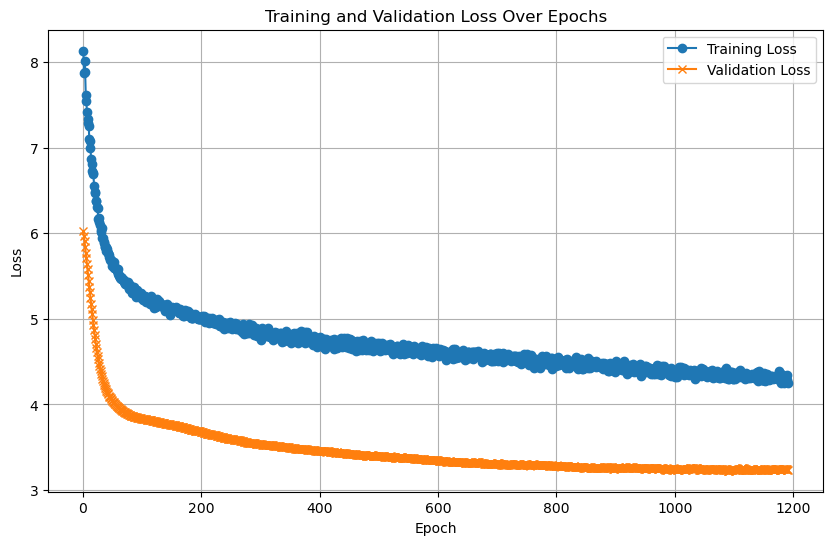

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/19], Loss: 5.2885

Test Loss: 4.8868


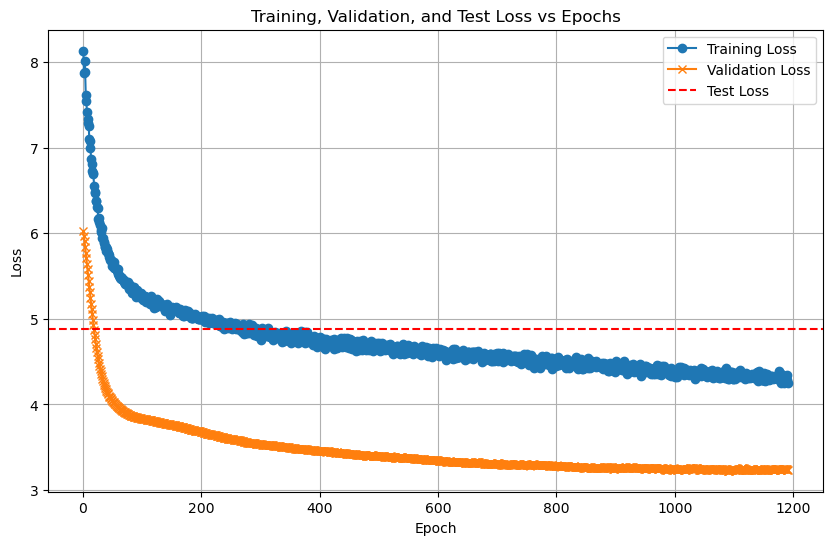

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/19 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 47.69%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.33      0.20      0.25         5
           2       0.40      0.40      0.40         5
           3       0.00      0.00      0.00         5
           4       0.83      1.00      0.91         5
           5       0.50      0.80      0.62         5
           6       0.25      0.40      0.31         5
           7       0.22      0.40      0.29         5
           8       0.71      1.00      0.83         5
           9       0.00      0.00      0.00         5
          10       1.00      1.00      1.00         5
          11       0.00      0.00      0.00         5
          12       0.80      0.80      0.80         5

    accuracy         

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7117  |  Val Loss: 2.6838
Validation loss improved from inf to 2.6838.
[Epoch 2/1000] Train Loss: 2.6443  |  Val Loss: 2.6541
Validation loss improved from 2.6838 to 2.6541.
[Epoch 3/1000] Train Loss: 2.5996  |  Val Loss: 2.6272
Validation loss improved from 2.6541 to 2.6272.


[Epoch 4/1000] Train Loss: 2.5626  |  Val Loss: 2.6058
Validation loss improved from 2.6272 to 2.6058.
[Epoch 5/1000] Train Loss: 2.5344  |  Val Loss: 2.5886
Validation loss improved from 2.6058 to 2.5886.
[Epoch 6/1000] Train Loss: 2.5137  |  Val Loss: 2.5732
Validation loss improved from 2.5886 to 2.5732.
[Epoch 7/1000] Train Loss: 2.4953  |  Val Loss: 2.5630
Validation loss improved from 2.5732 to 2.5630.
[Epoch 8/1000] Train Loss: 2.4823  |  Val Loss: 2.5540
Validation loss improved from 2.5630 to 2.5540.
[Epoch 9/1000] Train Loss: 2.4719  |  Val Loss: 2.5471
Validation loss improved from 2.5540 to 2.5471.
[Epoch 10/1000] Train Loss: 2.4626  |  Val Loss: 2.5411
Validation loss improved from 2.5471 to 2.5411.


[Epoch 11/1000] Train Loss: 2.4551  |  Val Loss: 2.5356
Validation loss improved from 2.5411 to 2.5356.
[Epoch 12/1000] Train Loss: 2.4477  |  Val Loss: 2.5298
Validation loss improved from 2.5356 to 2.5298.
[Epoch 13/1000] Train Loss: 2.4409  |  Val Loss: 2.5252
Validation loss improved from 2.5298 to 2.5252.


[Epoch 14/1000] Train Loss: 2.4337  |  Val Loss: 2.5199
Validation loss improved from 2.5252 to 2.5199.


[Epoch 15/1000] Train Loss: 2.4271  |  Val Loss: 2.5145
Validation loss improved from 2.5199 to 2.5145.
[Epoch 16/1000] Train Loss: 2.4209  |  Val Loss: 2.5099
Validation loss improved from 2.5145 to 2.5099.
[Epoch 17/1000] Train Loss: 2.4148  |  Val Loss: 2.5063
Validation loss improved from 2.5099 to 2.5063.
[Epoch 18/1000] Train Loss: 2.4086  |  Val Loss: 2.5031
Validation loss improved from 2.5063 to 2.5031.
[Epoch 19/1000] Train Loss: 2.4031  |  Val Loss: 2.4996
Validation loss improved from 2.5031 to 2.4996.
[Epoch 20/1000] Train Loss: 2.3975  |  Val Loss: 2.4978
Validation loss improved from 2.4996 to 2.4978.
[Epoch 21/1000] Train Loss: 2.3923  |  Val Loss: 2.4952
Validation loss improved from 2.4978 to 2.4952.


[Epoch 22/1000] Train Loss: 2.3862  |  Val Loss: 2.4903
Validation loss improved from 2.4952 to 2.4903.
[Epoch 23/1000] Train Loss: 2.3827  |  Val Loss: 2.4834
Validation loss improved from 2.4903 to 2.4834.
[Epoch 24/1000] Train Loss: 2.3788  |  Val Loss: 2.4797
Validation loss improved from 2.4834 to 2.4797.


[Epoch 25/1000] Train Loss: 2.3730  |  Val Loss: 2.4773
Validation loss improved from 2.4797 to 2.4773.
[Epoch 26/1000] Train Loss: 2.3657  |  Val Loss: 2.4755
Validation loss improved from 2.4773 to 2.4755.
[Epoch 27/1000] Train Loss: 2.3603  |  Val Loss: 2.4721
Validation loss improved from 2.4755 to 2.4721.
[Epoch 28/1000] Train Loss: 2.3550  |  Val Loss: 2.4674
Validation loss improved from 2.4721 to 2.4674.
[Epoch 29/1000] Train Loss: 2.3485  |  Val Loss: 2.4638
Validation loss improved from 2.4674 to 2.4638.
[Epoch 30/1000] Train Loss: 2.3415  |  Val Loss: 2.4595
Validation loss improved from 2.4638 to 2.4595.
[Epoch 31/1000] Train Loss: 2.3344  |  Val Loss: 2.4543
Validation loss improved from 2.4595 to 2.4543.
[Epoch 32/1000] Train Loss: 2.3263  |  Val Loss: 2.4508
Validation loss improved from 2.4543 to 2.4508.


[Epoch 33/1000] Train Loss: 2.3188  |  Val Loss: 2.4470
Validation loss improved from 2.4508 to 2.4470.
[Epoch 34/1000] Train Loss: 2.3110  |  Val Loss: 2.4402
Validation loss improved from 2.4470 to 2.4402.


[Epoch 35/1000] Train Loss: 2.3045  |  Val Loss: 2.4352
Validation loss improved from 2.4402 to 2.4352.
[Epoch 36/1000] Train Loss: 2.2975  |  Val Loss: 2.4309
Validation loss improved from 2.4352 to 2.4309.
[Epoch 37/1000] Train Loss: 2.2913  |  Val Loss: 2.4312
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 2.2848  |  Val Loss: 2.4293
Validation loss improved from 2.4309 to 2.4293.
[Epoch 39/1000] Train Loss: 2.2777  |  Val Loss: 2.4272
Validation loss improved from 2.4293 to 2.4272.
[Epoch 40/1000] Train Loss: 2.2703  |  Val Loss: 2.4250
Validation loss improved from 2.4272 to 2.4250.
[Epoch 41/1000] Train Loss: 2.2644  |  Val Loss: 2.4230
Validation loss improved from 2.4250 to 2.4230.
[Epoch 42/1000] Train Loss: 2.2577  |  Val Loss: 2.4196
Validation loss improved from 2.4230 to 2.4196.


[Epoch 43/1000] Train Loss: 2.2511  |  Val Loss: 2.4144
Validation loss improved from 2.4196 to 2.4144.
[Epoch 44/1000] Train Loss: 2.2433  |  Val Loss: 2.4088
Validation loss improved from 2.4144 to 2.4088.
[Epoch 45/1000] Train Loss: 2.2361  |  Val Loss: 2.4010
Validation loss improved from 2.4088 to 2.4010.


[Epoch 46/1000] Train Loss: 2.2287  |  Val Loss: 2.3966
Validation loss improved from 2.4010 to 2.3966.
[Epoch 47/1000] Train Loss: 2.2217  |  Val Loss: 2.3930
Validation loss improved from 2.3966 to 2.3930.
[Epoch 48/1000] Train Loss: 2.2137  |  Val Loss: 2.3889
Validation loss improved from 2.3930 to 2.3889.
[Epoch 49/1000] Train Loss: 2.2068  |  Val Loss: 2.3858
Validation loss improved from 2.3889 to 2.3858.
[Epoch 50/1000] Train Loss: 2.1991  |  Val Loss: 2.3814
Validation loss improved from 2.3858 to 2.3814.
[Epoch 51/1000] Train Loss: 2.1914  |  Val Loss: 2.3760
Validation loss improved from 2.3814 to 2.3760.
[Epoch 52/1000] Train Loss: 2.1834  |  Val Loss: 2.3718
Validation loss improved from 2.3760 to 2.3718.
[Epoch 53/1000] Train Loss: 2.1750  |  Val Loss: 2.3671
Validation loss improved from 2.3718 to 2.3671.
[Epoch 54/1000] Train Loss: 2.1669  |  Val Loss: 2.3625
Validation loss improved from 2.3671 to 2.3625.


[Epoch 55/1000] Train Loss: 2.1587  |  Val Loss: 2.3598
Validation loss improved from 2.3625 to 2.3598.
[Epoch 56/1000] Train Loss: 2.1503  |  Val Loss: 2.3562
Validation loss improved from 2.3598 to 2.3562.
[Epoch 57/1000] Train Loss: 2.1420  |  Val Loss: 2.3550
Validation loss improved from 2.3562 to 2.3550.


[Epoch 58/1000] Train Loss: 2.1333  |  Val Loss: 2.3517
Validation loss improved from 2.3550 to 2.3517.
[Epoch 59/1000] Train Loss: 2.1250  |  Val Loss: 2.3502
Validation loss improved from 2.3517 to 2.3502.
[Epoch 60/1000] Train Loss: 2.1162  |  Val Loss: 2.3481
Validation loss improved from 2.3502 to 2.3481.
[Epoch 61/1000] Train Loss: 2.1074  |  Val Loss: 2.3504
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 2.0994  |  Val Loss: 2.3479
Validation loss improved from 2.3481 to 2.3479.
[Epoch 63/1000] Train Loss: 2.0901  |  Val Loss: 2.3425
Validation loss improved from 2.3479 to 2.3425.
[Epoch 64/1000] Train Loss: 2.0801  |  Val Loss: 2.3369
Validation loss improved from 2.3425 to 2.3369.
[Epoch 65/1000] Train Loss: 2.0711  |  Val Loss: 2.3321
Validation loss improved from 2.3369 to 2.3321.
[Epoch 66/1000] Train Loss: 2.0623  |  Val Loss: 2.3277
Validation loss improved from 2.3321 to 2.3277.
[Epoch 67/1000] Train Loss: 2.0532  |  Val Loss: 2.3258
Va

[Epoch 68/1000] Train Loss: 2.0441  |  Val Loss: 2.3261
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 69/1000] Train Loss: 2.0362  |  Val Loss: 2.3215
Validation loss improved from 2.3258 to 2.3215.
[Epoch 70/1000] Train Loss: 2.0283  |  Val Loss: 2.3113
Validation loss improved from 2.3215 to 2.3113.
[Epoch 71/1000] Train Loss: 2.0190  |  Val Loss: 2.3100
Validation loss improved from 2.3113 to 2.3100.
[Epoch 72/1000] Train Loss: 2.0096  |  Val Loss: 2.3157
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 2.0001  |  Val Loss: 2.3108
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 1.9901  |  Val Loss: 2.3030
Validation loss improved from 2.3100 to 2.3030.
[Epoch 75/1000] Train Loss: 1.9806  |  Val Loss: 2.3009
Validation loss improved from 2.3030 to 2.3009.
[Epoch 76/1000] Train Loss: 1.9712  |  Val Loss: 2.2979
Validation loss improved from 2.3009 to 2.2979.
[Epoch 77/1000] Train Loss: 1.9615  |  Val Loss: 2.2946
Validation loss improved from 2.2979 to 2.2946.
[Epoch 78/1000] Train Loss: 1.9514  |  Val Loss: 2.2

[Epoch 79/1000] Train Loss: 1.9416  |  Val Loss: 2.2875
Validation loss improved from 2.2926 to 2.2875.
[Epoch 80/1000] Train Loss: 1.9317  |  Val Loss: 2.2855
Validation loss improved from 2.2875 to 2.2855.
[Epoch 81/1000] Train Loss: 1.9222  |  Val Loss: 2.2815
Validation loss improved from 2.2855 to 2.2815.
[Epoch 82/1000] Train Loss: 1.9123  |  Val Loss: 2.2763
Validation loss improved from 2.2815 to 2.2763.
[Epoch 83/1000] Train Loss: 1.9023  |  Val Loss: 2.2711
Validation loss improved from 2.2763 to 2.2711.
[Epoch 84/1000] Train Loss: 1.8925  |  Val Loss: 2.2733
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 85/1000] Train Loss: 1.8829  |  Val Loss: 2.2697
Validation loss improved from 2.2711 to 2.2697.
[Epoch 86/1000] Train Loss: 1.8726  |  Val Loss: 2.2603
Validation loss improved from 2.2697 to 2.2603.
[Epoch 87/1000] Train Loss: 1.8613  |  Val Loss: 2.2548
Validation loss improved from 2.2603 to 2.2548.
[Epoch 88/1000] Train Loss: 1.8514  |  Val Loss: 2.2504
Va

[Epoch 89/1000] Train Loss: 1.8418  |  Val Loss: 2.2497
Validation loss improved from 2.2504 to 2.2497.
[Epoch 90/1000] Train Loss: 1.8326  |  Val Loss: 2.2445
Validation loss improved from 2.2497 to 2.2445.
[Epoch 91/1000] Train Loss: 1.8226  |  Val Loss: 2.2423
Validation loss improved from 2.2445 to 2.2423.
[Epoch 92/1000] Train Loss: 1.8127  |  Val Loss: 2.2428
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 93/1000] Train Loss: 1.8037  |  Val Loss: 2.2328
Validation loss improved from 2.2423 to 2.2328.
[Epoch 94/1000] Train Loss: 1.7938  |  Val Loss: 2.2263
Validation loss improved from 2.2328 to 2.2263.
[Epoch 95/1000] Train Loss: 1.7844  |  Val Loss: 2.2245
Validation loss improved from 2.2263 to 2.2245.
[Epoch 96/1000] Train Loss: 1.7757  |  Val Loss: 2.2308
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 97/1000] Train Loss: 1.7668  |  Val Loss: 2.2261
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 98/1000] Train Loss: 1.7574  |  Val Los

[Epoch 101/1000] Train Loss: 1.7299  |  Val Loss: 2.2120
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 1.7211  |  Val Loss: 2.2122
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 1.7114  |  Val Loss: 2.2051
Validation loss improved from 2.2101 to 2.2051.
[Epoch 104/1000] Train Loss: 1.7021  |  Val Loss: 2.2034
Validation loss improved from 2.2051 to 2.2034.
[Epoch 105/1000] Train Loss: 1.6930  |  Val Loss: 2.2004
Validation loss improved from 2.2034 to 2.2004.
[Epoch 106/1000] Train Loss: 1.6842  |  Val Loss: 2.1982
Validation loss improved from 2.2004 to 2.1982.
[Epoch 107/1000] Train Loss: 1.6749  |  Val Loss: 2.1942
Validation loss improved from 2.1982 to 2.1942.
[Epoch 108/1000] Train Loss: 1.6657  |  Val Loss: 2.1912
Validation loss improved from 2.1942 to 2.1912.
[Epoch 109/1000] Train Loss: 1.6568  |  Val Loss: 2.1896
Validation loss improved from 2.1912 to 2.1896.
[Epoch 110/1000] Train Loss: 1.6494  |  Val

[Epoch 114/1000] Train Loss: 1.6124  |  Val Loss: 2.1751
Validation loss improved from 2.1782 to 2.1751.
[Epoch 115/1000] Train Loss: 1.6037  |  Val Loss: 2.1758
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 116/1000] Train Loss: 1.5952  |  Val Loss: 2.1716
Validation loss improved from 2.1751 to 2.1716.
[Epoch 117/1000] Train Loss: 1.5860  |  Val Loss: 2.1678
Validation loss improved from 2.1716 to 2.1678.
[Epoch 118/1000] Train Loss: 1.5775  |  Val Loss: 2.1621
Validation loss improved from 2.1678 to 2.1621.
[Epoch 119/1000] Train Loss: 1.5692  |  Val Loss: 2.1638
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 120/1000] Train Loss: 1.5602  |  Val Loss: 2.1599
Validation loss improved from 2.1621 to 2.1599.
[Epoch 121/1000] Train Loss: 1.5509  |  Val Loss: 2.1571
Validation loss improved from 2.1599 to 2.1571.
[Epoch 122/1000] Train Loss: 1.5424  |  Val Loss: 2.1561
Validation loss improved from 2.1571 to 2.1561.
[Epoch 123/1000] Train Loss: 1.5336  |  Val

[Epoch 125/1000] Train Loss: 1.5166  |  Val Loss: 2.1519
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 126/1000] Train Loss: 1.5090  |  Val Loss: 2.1676
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 127/1000] Train Loss: 1.5011  |  Val Loss: 2.1621
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 128/1000] Train Loss: 1.4920  |  Val Loss: 2.1575
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 129/1000] Train Loss: 1.4834  |  Val Loss: 2.1512
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 130/1000] Train Loss: 1.4743  |  Val Loss: 2.1443
Validation loss improved from 2.1505 to 2.1443.
[Epoch 131/1000] Train Loss: 1.4651  |  Val Loss: 2.1422
Validation loss improved from 2.1443 to 2.1422.
[Epoch 132/1000] Train Loss: 1.4564  |  Val Loss: 2.1432
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 133/1000] Train Loss: 1.4478  |  Val Loss: 2.1419
Validation loss improved from 2.1422 to 2.1419.
[Epoch 134/1000] Tr

[Epoch 135/1000] Train Loss: 1.4322  |  Val Loss: 2.1468
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 136/1000] Train Loss: 1.4242  |  Val Loss: 2.1418
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 137/1000] Train Loss: 1.4146  |  Val Loss: 2.1383
Validation loss improved from 2.1401 to 2.1383.
[Epoch 138/1000] Train Loss: 1.4066  |  Val Loss: 2.1322
Validation loss improved from 2.1383 to 2.1322.
[Epoch 139/1000] Train Loss: 1.3980  |  Val Loss: 2.1308
Validation loss improved from 2.1322 to 2.1308.
[Epoch 140/1000] Train Loss: 1.3906  |  Val Loss: 2.1297
Validation loss improved from 2.1308 to 2.1297.
[Epoch 141/1000] Train Loss: 1.3812  |  Val Loss: 2.1274
Validation loss improved from 2.1297 to 2.1274.
[Epoch 142/1000] Train Loss: 1.3733  |  Val Loss: 2.1238
Validation loss improved from 2.1274 to 2.1238.
[Epoch 143/1000] Train Loss: 1.3649  |  Val Loss: 2.1209
Validation loss improved from 2.1238 to 2.1209.
[Epoch 144/1000] Train Loss: 1.3609  |  Val

[Epoch 146/1000] Train Loss: 1.3459  |  Val Loss: 2.1155
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 147/1000] Train Loss: 1.3374  |  Val Loss: 2.1216
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 148/1000] Train Loss: 1.3307  |  Val Loss: 2.1157
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 149/1000] Train Loss: 1.3205  |  Val Loss: 2.1169
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 150/1000] Train Loss: 1.3134  |  Val Loss: 2.1185
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 151/1000] Train Loss: 1.3054  |  Val Loss: 2.1235
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 152/1000] Train Loss: 1.2983  |  Val Loss: 2.1273
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 153/1000] Train Loss: 1.2910  |  Val Loss: 2.1309
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 154/1000] Train Loss: 1.2837  |  Val Loss: 2.1492
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 158/1000] Train Loss: 1.2576  |  Val Loss: 2.1325
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 159/1000] Train Loss: 1.2506  |  Val Loss: 2.1336
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 160/1000] Train Loss: 1.2461  |  Val Loss: 2.1343
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 161/1000] Train Loss: 1.2400  |  Val Loss: 2.1313
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 162/1000] Train Loss: 1.2326  |  Val Loss: 2.1278
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 163/1000] Train Loss: 1.2263  |  Val Loss: 2.1217
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 164/1000] Train Loss: 1.2183  |  Val Loss: 2.1342
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 165/1000] Train Loss: 1.2117  |  Val Loss: 2.1341
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 166/1000] Train Loss: 1.2052  |  Val Loss: 2.1328
!! Validation loss did NOT improve !! Patience:

[Epoch 171/1000] Train Loss: 1.1766  |  Val Loss: 2.1364
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 172/1000] Train Loss: 1.1690  |  Val Loss: 2.1421
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 173/1000] Train Loss: 1.1629  |  Val Loss: 2.1487
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 174/1000] Train Loss: 1.1578  |  Val Loss: 2.1530
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 175/1000] Train Loss: 1.1521  |  Val Loss: 2.1433
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 176/1000] Train Loss: 1.1466  |  Val Loss: 2.1502
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 177/1000] Train Loss: 1.1412  |  Val Loss: 2.1591
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 178/1000] Train Loss: 1.1346  |  Val Loss: 2.1594
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 179/1000] Train Loss: 1.1299  |  Val Loss: 2.1603
!! Validation loss did NOT improve !! Patience:

[Epoch 184/1000] Train Loss: 1.1031  |  Val Loss: 2.1794
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 185/1000] Train Loss: 1.0984  |  Val Loss: 2.1778
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 186/1000] Train Loss: 1.0934  |  Val Loss: 2.1795
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 187/1000] Train Loss: 1.0885  |  Val Loss: 2.1835
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 188/1000] Train Loss: 1.0830  |  Val Loss: 2.1877
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 189/1000] Train Loss: 1.0790  |  Val Loss: 2.1887
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 190/1000] Train Loss: 1.0738  |  Val Loss: 2.1977
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 191/1000] Train Loss: 1.0700  |  Val Loss: 2.1941
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 192/1000] Train Loss: 1.0652  |  Val Loss: 2.1875
!! Validation loss did NOT improve !! Patience:

[Epoch 196/1000] Train Loss: 1.0469  |  Val Loss: 2.2223
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 197/1000] Train Loss: 1.0424  |  Val Loss: 2.2325
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 198/1000] Train Loss: 1.0387  |  Val Loss: 2.2359
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 199/1000] Train Loss: 1.0360  |  Val Loss: 2.2430
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 200/1000] Train Loss: 1.0312  |  Val Loss: 2.2284
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 201/1000] Train Loss: 1.0276  |  Val Loss: 2.2287
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 202/1000] Train Loss: 1.0221  |  Val Loss: 2.2404
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 203/1000] Train Loss: 1.0184  |  Val Loss: 2.2437
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 204/1000] Train Loss: 1.0144  |  Val Loss: 2.2475
!! Validation loss did NOT improve !! Patience:

[Epoch 206/1000] Train Loss: 1.0071  |  Val Loss: 2.2464
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 207/1000] Train Loss: 1.0023  |  Val Loss: 2.2603
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 208/1000] Train Loss: 0.9989  |  Val Loss: 2.2582
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 209/1000] Train Loss: 0.9944  |  Val Loss: 2.2621
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 210/1000] Train Loss: 0.9913  |  Val Loss: 2.2614
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 211/1000] Train Loss: 0.9871  |  Val Loss: 2.2712
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 212/1000] Train Loss: 0.9832  |  Val Loss: 2.2779
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 213/1000] Train Loss: 0.9799  |  Val Loss: 2.2771
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 214/1000] Train Loss: 0.9763  |  Val Loss: 2.2764
!! Validation loss did NOT improve !! Patience:

[Epoch 218/1000] Train Loss: 0.9621  |  Val Loss: 2.3001
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 219/1000] Train Loss: 0.9576  |  Val Loss: 2.3061
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 220/1000] Train Loss: 0.9579  |  Val Loss: 2.3124
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 221/1000] Train Loss: 0.9566  |  Val Loss: 2.3035
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 222/1000] Train Loss: 0.9501  |  Val Loss: 2.3024
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 223/1000] Train Loss: 0.9487  |  Val Loss: 2.2912
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 224/1000] Train Loss: 0.9464  |  Val Loss: 2.2993
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 225/1000] Train Loss: 0.9449  |  Val Loss: 2.2990
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 226/1000] Train Loss: 0.9388  |  Val Loss: 2.2998
!! Validation loss did NOT improve !! Patience:

[Epoch 230/1000] Train Loss: 0.9241  |  Val Loss: 2.3256
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 231/1000] Train Loss: 0.9208  |  Val Loss: 2.3294
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 232/1000] Train Loss: 0.9184  |  Val Loss: 2.3333
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 233/1000] Train Loss: 0.9140  |  Val Loss: 2.3441
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 234/1000] Train Loss: 0.9133  |  Val Loss: 2.3503
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 235/1000] Train Loss: 0.9106  |  Val Loss: 2.3446
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 236/1000] Train Loss: 0.9059  |  Val Loss: 2.3403
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 237/1000] Train Loss: 0.9043  |  Val Loss: 2.3311
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 238/1000] Train Loss: 0.9032  |  Val Loss: 2.3521
!! Validation loss did NOT improve !! Patience:

[Epoch 242/1000] Train Loss: 0.8888  |  Val Loss: 2.3744
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 243/1000] Train Loss: 0.8871  |  Val Loss: 2.3788
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 244/1000] Train Loss: 0.8854  |  Val Loss: 2.3953
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 245/1000] Train Loss: 0.8819  |  Val Loss: 2.4030
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 245 !!
No improvement for 100 epochs.


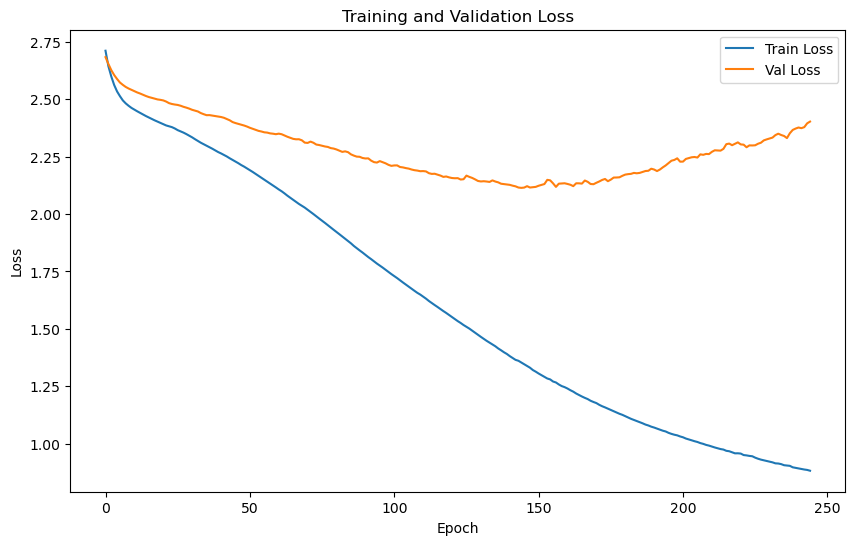

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.1110 | Test Accuracy: 56.16%


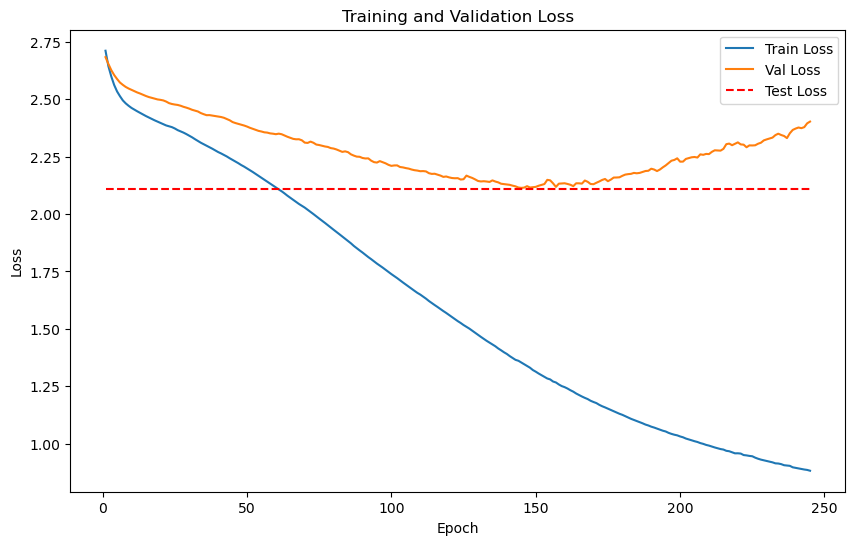

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)


Train embeddings shape: (520, 64), 
Train labels shape: (520,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4626, 64), 
Test labels shape: (4626,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.5354
    Batch [2/2], Train Loss: 0.5300
LOG: Epoch [1/2000] - Validation


    Batch [1/2], Val Loss: 0.6037
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5327, Avg Val Loss: 0.5519

Validation loss improved from inf to 0.5519. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.5306


    Batch [2/2], Train Loss: 0.5416
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.6026
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5361, Avg Val Loss: 0.5513

Validation loss improved from 0.5519 to 0.5513. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.5256
    Batch [2/2], Train Loss: 0.5277
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.6011
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5266, Avg Val Loss: 0.5506

Validation loss improved from 0.5513 to 0.5506. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.5365
    Batch [2/2], Train Loss: 0.5279
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5978
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5322, Avg Val Loss: 0.5489

Validation loss improved from 0.5506 to 0.5489. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.5324
    Batch [2/2], Train Loss: 0.5251
LOG: Epoch [5/2000] - Validation


    Batch [1/2], Val Loss: 0.5956
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5287, Avg Val Loss: 0.5478

Validation loss improved from 0.5489 to 0.5478. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.5259


    Batch [2/2], Train Loss: 0.5258
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5923
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5259, Avg Val Loss: 0.5462

Validation loss improved from 0.5478 to 0.5462. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.5153


    Batch [2/2], Train Loss: 0.5264
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5872
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5209, Avg Val Loss: 0.5436

Validation loss improved from 0.5462 to 0.5436. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/2], Train Loss: 0.5226
    Batch [2/2], Train Loss: 0.5225
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5822
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5225, Avg Val Loss: 0.5411

Validation loss improved from 0.5436 to 0.5411. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/2], Train Loss: 0.5222
    Batch [2/2], Train Loss: 0.5192
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5761
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5207, Avg Val Loss: 0.5381

Validation loss improved from 0.5411 to 0.5381. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.5202
    Batch [2/2], Train Loss: 0.5207
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5700
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5204, Avg Val Loss: 0.5350

Validation loss improved from 0.5381 to 0.5350. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/2], Train Loss: 0.5227
    Batch [2/2], Train Loss: 0.5179
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5620
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5203, Avg Val Loss: 0.5310

Validation loss improved from 0.5350 to 0.5310. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/2], Train Loss: 0.5210
    Batch [2/2], Train Loss: 0.5173
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5544
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5192, Avg Val Loss: 0.5272

Validation loss improved from 0.5310 to 0.5272. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.5154
    Batch [2/2], Train Loss: 0.5158
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5450
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5156, Avg Val Loss: 0.5225

Validation loss improved from 0.5272 to 0.5225. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.5170
    Batch [2/2], Train Loss: 0.5183
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5369
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5177, Avg Val Loss: 0.5184

Validation loss improved from 0.5225 to 0.5184. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/2], Train Loss: 0.5171
    Batch [2/2], Train Loss: 0.5164
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5294
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5168, Avg Val Loss: 0.5147

Validation loss improved from 0.5184 to 0.5147. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 0.5143
    Batch [2/2], Train Loss: 0.5128
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5222
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5136, Avg Val Loss: 0.5111

Validation loss improved from 0.5147 to 0.5111. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.5164
    Batch [2/2], Train Loss: 0.5035
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5152
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5100, Avg Val Loss: 0.5076

Validation loss improved from 0.5111 to 0.5076. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.5107
    Batch [2/2], Train Loss: 0.5081
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.5096
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5094, Avg Val Loss: 0.5048

Validation loss improved from 0.5076 to 0.5048. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.5139


    Batch [2/2], Train Loss: 0.5116
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5058
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5127, Avg Val Loss: 0.5029

Validation loss improved from 0.5048 to 0.5029. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/2], Train Loss: 0.5116


    Batch [2/2], Train Loss: 0.5069
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5092, Avg Val Loss: 0.5012

Validation loss improved from 0.5029 to 0.5012. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.5070
    Batch [2/2], Train Loss: 0.5091
LOG: Epoch [21/2000] - Validation


    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5081, Avg Val Loss: 0.4998

Validation loss improved from 0.5012 to 0.4998. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.5092


    Batch [2/2], Train Loss: 0.5063
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4970
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5077, Avg Val Loss: 0.4985

Validation loss improved from 0.4998 to 0.4985. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.5065


    Batch [2/2], Train Loss: 0.5069
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5067, Avg Val Loss: 0.4973

Validation loss improved from 0.4985 to 0.4973. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.5059


    Batch [2/2], Train Loss: 0.5064
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5061, Avg Val Loss: 0.4961

Validation loss improved from 0.4973 to 0.4961. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.5078


    Batch [2/2], Train Loss: 0.5076
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4902
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5077, Avg Val Loss: 0.4951

Validation loss improved from 0.4961 to 0.4951. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.5029


    Batch [2/2], Train Loss: 0.5060
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5045, Avg Val Loss: 0.4938

Validation loss improved from 0.4951 to 0.4938. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/2], Train Loss: 0.5038
    Batch [2/2], Train Loss: 0.5066
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5052, Avg Val Loss: 0.4929

Validation loss improved from 0.4938 to 0.4929. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.5010
    Batch [2/2], Train Loss: 0.5030
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5020, Avg Val Loss: 0.4920

Validation loss improved from 0.4929 to 0.4920. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/2], Train Loss: 0.5018
    Batch [2/2], Train Loss: 0.5061
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.4819
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5039, Avg Val Loss: 0.4909

Validation loss improved from 0.4920 to 0.4909. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.5061


    Batch [2/2], Train Loss: 0.4999
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5030, Avg Val Loss: 0.4900

Validation loss improved from 0.4909 to 0.4900. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.5018
    Batch [2/2], Train Loss: 0.5033
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.4890

Validation loss improved from 0.4900 to 0.4890. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.5005
    Batch [2/2], Train Loss: 0.5049
LOG: Epoch [32/2000] - Validation


    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5027, Avg Val Loss: 0.4881

Validation loss improved from 0.4890 to 0.4881. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.5025


    Batch [2/2], Train Loss: 0.5034
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5029, Avg Val Loss: 0.4873

Validation loss improved from 0.4881 to 0.4873. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 0.5010


    Batch [2/2], Train Loss: 0.5003
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.4867

Validation loss improved from 0.4873 to 0.4867. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/2], Train Loss: 0.5029
    Batch [2/2], Train Loss: 0.5041
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.4863

Validation loss improved from 0.4867 to 0.4863. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/2], Train Loss: 0.5030
    Batch [2/2], Train Loss: 0.4990
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4719
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5010, Avg Val Loss: 0.4859

Validation loss improved from 0.4863 to 0.4859. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.4965
    Batch [2/2], Train Loss: 0.4969
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4708
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.4854

Validation loss improved from 0.4859 to 0.4854. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/2], Train Loss: 0.4967
    Batch [2/2], Train Loss: 0.4975
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.4852

Validation loss improved from 0.4854 to 0.4852. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4985
    Batch [2/2], Train Loss: 0.5005
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.4995, Avg Val Loss: 0.4848

Validation loss improved from 0.4852 to 0.4848. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.5010
    Batch [2/2], Train Loss: 0.4996
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.4846

Validation loss improved from 0.4848 to 0.4846. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.4971
    Batch [2/2], Train Loss: 0.5040
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5006, Avg Val Loss: 0.4844

Validation loss improved from 0.4846 to 0.4844. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.4977
    Batch [2/2], Train Loss: 0.4953
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.4841

Validation loss improved from 0.4844 to 0.4841. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.4983
    Batch [2/2], Train Loss: 0.4946
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.4965
    Batch [2/2], Train Loss: 0.4997
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.5000


Epoch [44/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.4999


    Batch [2/2], Train Loss: 0.4981
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.4990, Avg Val Loss: 0.4839

Validation loss improved from 0.4841 to 0.4839. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 0.4918


    Batch [2/2], Train Loss: 0.4991
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.4833

Validation loss improved from 0.4839 to 0.4833. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.4972


    Batch [2/2], Train Loss: 0.5005
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.4831

Validation loss improved from 0.4833 to 0.4831. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/2], Train Loss: 0.4956
    Batch [2/2], Train Loss: 0.4979
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4651
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.4968, Avg Val Loss: 0.4825

Validation loss improved from 0.4831 to 0.4825. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/2], Train Loss: 0.4932
    Batch [2/2], Train Loss: 0.4983
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.4824

Validation loss improved from 0.4825 to 0.4824. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.4962
    Batch [2/2], Train Loss: 0.4948
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.4819

Validation loss improved from 0.4824 to 0.4819. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 0.4979


    Batch [2/2], Train Loss: 0.4962
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.4815

Validation loss improved from 0.4819 to 0.4815. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.5008


    Batch [2/2], Train Loss: 0.4945
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.4811

Validation loss improved from 0.4815 to 0.4811. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.4982


    Batch [2/2], Train Loss: 0.4922
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.4806

Validation loss improved from 0.4811 to 0.4806. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 0.4980


    Batch [2/2], Train Loss: 0.4946
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.4799

Validation loss improved from 0.4806 to 0.4799. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.4949


    Batch [2/2], Train Loss: 0.4895
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4794

Validation loss improved from 0.4799 to 0.4794. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.4950


    Batch [2/2], Train Loss: 0.4932
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.4796

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.4935


    Batch [2/2], Train Loss: 0.4975
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.4796

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 0.4946


    Batch [2/2], Train Loss: 0.4936
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.4797

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.4950


    Batch [2/2], Train Loss: 0.4939
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.4945, Avg Val Loss: 0.4794

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 0.4887


    Batch [2/2], Train Loss: 0.4916
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4789

Validation loss improved from 0.4794 to 0.4789. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 0.4974


    Batch [2/2], Train Loss: 0.4936
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4578
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.4789

Validation loss improved from 0.4789 to 0.4789. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.4867


    Batch [2/2], Train Loss: 0.4878
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4785

Validation loss improved from 0.4789 to 0.4785. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.4878


    Batch [2/2], Train Loss: 0.4948
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4561
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4781

Validation loss improved from 0.4785 to 0.4781. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.4902


    Batch [2/2], Train Loss: 0.4905
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4553
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4776

Validation loss improved from 0.4781 to 0.4776. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.4869


    Batch [2/2], Train Loss: 0.4945
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.4776

Validation loss improved from 0.4776 to 0.4776. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.4940


    Batch [2/2], Train Loss: 0.4938
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4550
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.4775

Validation loss improved from 0.4776 to 0.4775. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 0.4919


    Batch [2/2], Train Loss: 0.4915
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4559
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.4779

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.4952
    Batch [2/2], Train Loss: 0.4941
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4570
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.4785

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [69/2000] - Training


    Batch [1/2], Train Loss: 0.4914
    Batch [2/2], Train Loss: 0.4906
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4576
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4788

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.4955
    Batch [2/2], Train Loss: 0.4900
LOG: Epoch [70/2000] - Validation


    Batch [1/2], Val Loss: 0.4575
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.4908


    Batch [2/2], Train Loss: 0.4929
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4573
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4786

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.4884
    Batch [2/2], Train Loss: 0.4891
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.4787

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [73/2000] - Training


    Batch [1/2], Train Loss: 0.4887
    Batch [2/2], Train Loss: 0.4863
LOG: Epoch [73/2000] - Validation


    Batch [1/2], Val Loss: 0.4560
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4780

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 0.4885


    Batch [2/2], Train Loss: 0.4924
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4775

Validation loss improved from 0.4775 to 0.4775. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.4931


    Batch [2/2], Train Loss: 0.4988
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.4773

Validation loss improved from 0.4775 to 0.4773. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 0.4904


    Batch [2/2], Train Loss: 0.4862
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4544
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4772

Validation loss improved from 0.4773 to 0.4772. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.4901


    Batch [2/2], Train Loss: 0.4866
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4542
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4771

Validation loss improved from 0.4772 to 0.4771. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.4880
    Batch [2/2], Train Loss: 0.4927
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4540
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4770

Validation loss improved from 0.4771 to 0.4770. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.4928
    Batch [2/2], Train Loss: 0.4862
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4530
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.4765

Validation loss improved from 0.4770 to 0.4765. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.4899
    Batch [2/2], Train Loss: 0.4896
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.4759

Validation loss improved from 0.4765 to 0.4759. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/2], Train Loss: 0.4923
    Batch [2/2], Train Loss: 0.4843
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4883, Avg Val Loss: 0.4757

Validation loss improved from 0.4759 to 0.4757. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.4836
    Batch [2/2], Train Loss: 0.4882
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4521
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.4859, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.4920
    Batch [2/2], Train Loss: 0.4861
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.4879
    Batch [2/2], Train Loss: 0.4864
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4514
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4757

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [85/2000] - Training


    Batch [1/2], Train Loss: 0.4873
    Batch [2/2], Train Loss: 0.4898
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.4759

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.4885
    Batch [2/2], Train Loss: 0.4865
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4526
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4763

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.4862
    Batch [2/2], Train Loss: 0.4868
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4532
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.4766

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [88/2000] - Training


    Batch [1/2], Train Loss: 0.4876
    Batch [2/2], Train Loss: 0.4882
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4528
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4764

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.4877
    Batch [2/2], Train Loss: 0.4879
LOG: Epoch [89/2000] - Validation


    Batch [1/2], Val Loss: 0.4517
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4758

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.4834


    Batch [2/2], Train Loss: 0.4895
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4751

Validation loss improved from 0.4757 to 0.4751. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.4881


    Batch [2/2], Train Loss: 0.4798
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4492
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.4746

Validation loss improved from 0.4751 to 0.4746. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/2], Train Loss: 0.4849
    Batch [2/2], Train Loss: 0.4865
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4476
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4738

Validation loss improved from 0.4746 to 0.4738. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.4783
    Batch [2/2], Train Loss: 0.4865
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4459
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4730

Validation loss improved from 0.4738 to 0.4730. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.4839
    Batch [2/2], Train Loss: 0.4911
LOG: Epoch [94/2000] - Validation


    Batch [1/2], Val Loss: 0.4454
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.4727

Validation loss improved from 0.4730 to 0.4727. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 0.4894


    Batch [2/2], Train Loss: 0.4864
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4457
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.4729

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 0.4845


    Batch [2/2], Train Loss: 0.4854
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4459
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4730

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [97/2000] - Training


    Batch [1/2], Train Loss: 0.4882
    Batch [2/2], Train Loss: 0.4883
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4737

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [98/2000] - Training


    Batch [1/2], Train Loss: 0.4838
    Batch [2/2], Train Loss: 0.4836
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4494
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4747

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.4850
    Batch [2/2], Train Loss: 0.4873
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4515
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.4758

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [100/2000] - Training


    Batch [1/2], Train Loss: 0.4793
    Batch [2/2], Train Loss: 0.4810
LOG: Epoch [100/2000] - Validation


    Batch [1/2], Val Loss: 0.4516
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4802, Avg Val Loss: 0.4758

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.4880


    Batch [2/2], Train Loss: 0.4773
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4520
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4760

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.4881
    Batch [2/2], Train Loss: 0.4785
LOG: Epoch [102/2000] - Validation


    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4751

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 0.4806


    Batch [2/2], Train Loss: 0.4813
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4742

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.4847


    Batch [2/2], Train Loss: 0.4821
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.4737

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.4840


    Batch [2/2], Train Loss: 0.4887
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4464
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4732

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.4851
    Batch [2/2], Train Loss: 0.4853
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4455
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.4728

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [107/2000] - Training


    Batch [1/2], Train Loss: 0.4782
    Batch [2/2], Train Loss: 0.4780
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4454
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4727

Validation loss improved from 0.4727 to 0.4727. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.4876
    Batch [2/2], Train Loss: 0.4840
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4454


    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4727

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 0.4732


    Batch [2/2], Train Loss: 0.4831
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4467
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.4733

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.4835
    Batch [2/2], Train Loss: 0.4803
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.4485
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.4742

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 0.4803


    Batch [2/2], Train Loss: 0.4743
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.4737

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.4841


    Batch [2/2], Train Loss: 0.4793
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4463
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4731

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.4875


    Batch [2/2], Train Loss: 0.4814
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4453
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4727

Validation loss improved from 0.4727 to 0.4727. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.4805


    Batch [2/2], Train Loss: 0.4837
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4452
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4726

Validation loss improved from 0.4727 to 0.4726. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/2], Train Loss: 0.4758
    Batch [2/2], Train Loss: 0.4852
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.4437
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.4719

Validation loss improved from 0.4726 to 0.4719. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 0.4828


    Batch [2/2], Train Loss: 0.4786
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.4711

Validation loss improved from 0.4719 to 0.4711. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.4820
    Batch [2/2], Train Loss: 0.4799
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4401
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.4701

Validation loss improved from 0.4711 to 0.4701. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.4771
    Batch [2/2], Train Loss: 0.4721
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4386
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.4693

Validation loss improved from 0.4701 to 0.4693. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.4776
    Batch [2/2], Train Loss: 0.4820
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4369
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.4684

Validation loss improved from 0.4693 to 0.4684. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/2], Train Loss: 0.4796
    Batch [2/2], Train Loss: 0.4796
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.4368
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4684

Validation loss improved from 0.4684 to 0.4684. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.4772


    Batch [2/2], Train Loss: 0.4746
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4382
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.4691

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.4719
    Batch [2/2], Train Loss: 0.4740
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4392


    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.4696

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 0.4807


    Batch [2/2], Train Loss: 0.4853
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4403
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4702

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.4763


    Batch [2/2], Train Loss: 0.4763
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4417
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.4708

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [125/2000] - Training


    Batch [1/2], Train Loss: 0.4717
    Batch [2/2], Train Loss: 0.4718
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4422
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.4711

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.4800
    Batch [2/2], Train Loss: 0.4780
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4424
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4712

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [127/2000] - Training


    Batch [1/2], Train Loss: 0.4725
    Batch [2/2], Train Loss: 0.4757
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4413
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.4706

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.4750
    Batch [2/2], Train Loss: 0.4677
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.4400
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.4700

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.4738


    Batch [2/2], Train Loss: 0.4715
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4392
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.4696

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.4714
    Batch [2/2], Train Loss: 0.4759
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4692

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.4693
    Batch [2/2], Train Loss: 0.4740
LOG: Epoch [131/2000] - Validation


    Batch [1/2], Val Loss: 0.4376
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.4688

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.4777


    Batch [2/2], Train Loss: 0.4748
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4369
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.4684

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.4711
    Batch [2/2], Train Loss: 0.4778
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.4680

Validation loss improved from 0.4684 to 0.4680. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.4723
    Batch [2/2], Train Loss: 0.4744
LOG: Epoch [134/2000] - Validation


    Batch [1/2], Val Loss: 0.4356
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.4678

Validation loss improved from 0.4680 to 0.4678. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.4703


    Batch [2/2], Train Loss: 0.4700
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4357
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.4679

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 0.4741


    Batch [2/2], Train Loss: 0.4752
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4362
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.4681

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 0.4802


    Batch [2/2], Train Loss: 0.4740
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4355
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.4677

Validation loss improved from 0.4678 to 0.4677. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.4752
    Batch [2/2], Train Loss: 0.4789
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4342
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.4671

Validation loss improved from 0.4677 to 0.4671. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.4756
    Batch [2/2], Train Loss: 0.4766
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.4667

Validation loss improved from 0.4671 to 0.4667. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.4802
    Batch [2/2], Train Loss: 0.4722
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4326
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.4663

Validation loss improved from 0.4667 to 0.4663. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.4738
    Batch [2/2], Train Loss: 0.4768
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4338
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.4669

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.4669
    Batch [2/2], Train Loss: 0.4745
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.4680

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [143/2000] - Training


    Batch [1/2], Train Loss: 0.4752
    Batch [2/2], Train Loss: 0.4679
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.4676

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.4726
    Batch [2/2], Train Loss: 0.4647
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4333
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.4667

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.4724
    Batch [2/2], Train Loss: 0.4707
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.4317
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4659

Validation loss improved from 0.4663 to 0.4659. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.4763


    Batch [2/2], Train Loss: 0.4691
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4654

Validation loss improved from 0.4659 to 0.4654. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.4708


    Batch [2/2], Train Loss: 0.4776
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4742, Avg Val Loss: 0.4649

Validation loss improved from 0.4654 to 0.4649. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.4783
    Batch [2/2], Train Loss: 0.4667
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4648

Validation loss improved from 0.4649 to 0.4648. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.4687
    Batch [2/2], Train Loss: 0.4750
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.4652

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 0.4759
    Batch [2/2], Train Loss: 0.4702
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.4323
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.4662

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 0.4730


    Batch [2/2], Train Loss: 0.4728
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4356
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.4678

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [152/2000] - Training


    Batch [1/2], Train Loss: 0.4752
    Batch [2/2], Train Loss: 0.4786
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4372
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.4686

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.4737
    Batch [2/2], Train Loss: 0.4738
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.4354
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4677

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 0.4708


    Batch [2/2], Train Loss: 0.4703
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4337
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4706, Avg Val Loss: 0.4668

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.4657


    Batch [2/2], Train Loss: 0.4634
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4318
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4659

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 0.4725


    Batch [2/2], Train Loss: 0.4674
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4309
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4655

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 0.4604


    Batch [2/2], Train Loss: 0.4653
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4652

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.4690


    Batch [2/2], Train Loss: 0.4673
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4653

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.4671


    Batch [2/2], Train Loss: 0.4661
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4297
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.4649

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.4683
    Batch [2/2], Train Loss: 0.4690
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.4648

Validation loss improved from 0.4648 to 0.4648. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.4720


    Batch [2/2], Train Loss: 0.4594
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4289
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4644

Validation loss improved from 0.4648 to 0.4644. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.4749


    Batch [2/2], Train Loss: 0.4654
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4271
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4636

Validation loss improved from 0.4644 to 0.4636. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.4647


    Batch [2/2], Train Loss: 0.4645
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.4632

Validation loss improved from 0.4636 to 0.4632. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.4657
    Batch [2/2], Train Loss: 0.4605
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4632

Validation loss improved from 0.4632 to 0.4632. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.4715
    Batch [2/2], Train Loss: 0.4636
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4265
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.4632

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [166/2000] - Training


    Batch [1/2], Train Loss: 0.4659
    Batch [2/2], Train Loss: 0.4634
LOG: Epoch [166/2000] - Validation


    Batch [1/2], Val Loss: 0.4262
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4646, Avg Val Loss: 0.4631

Validation loss improved from 0.4632 to 0.4631. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 0.4625


    Batch [2/2], Train Loss: 0.4639
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4630

Validation loss improved from 0.4631 to 0.4630. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 0.4637


    Batch [2/2], Train Loss: 0.4663
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4270
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4635

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.4647


    Batch [2/2], Train Loss: 0.4622
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4279
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.4640

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 0.4698


    Batch [2/2], Train Loss: 0.4705
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4293
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4702, Avg Val Loss: 0.4647

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 0.4657


    Batch [2/2], Train Loss: 0.4713
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4298
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.4649

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.4773
    Batch [2/2], Train Loss: 0.4656
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4290
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4645

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [173/2000] - Training


    Batch [1/2], Train Loss: 0.4586
    Batch [2/2], Train Loss: 0.4704
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.4282
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4641

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.4639


    Batch [2/2], Train Loss: 0.4634
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4276
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4638

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.4629


    Batch [2/2], Train Loss: 0.4631
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4269
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4635

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.4703


    Batch [2/2], Train Loss: 0.4647
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.4629

Validation loss improved from 0.4630 to 0.4629. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.4552
    Batch [2/2], Train Loss: 0.4561
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4257
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4628

Validation loss improved from 0.4629 to 0.4628. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.4538
    Batch [2/2], Train Loss: 0.4584
LOG: Epoch [178/2000] - Validation


    Batch [1/2], Val Loss: 0.4260
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4630

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.4632


    Batch [2/2], Train Loss: 0.4555
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4629

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.4620


    Batch [2/2], Train Loss: 0.4713
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.4624

Validation loss improved from 0.4628 to 0.4624. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.4610


    Batch [2/2], Train Loss: 0.4576
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4617

Validation loss improved from 0.4624 to 0.4617. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.4598


    Batch [2/2], Train Loss: 0.4665
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4231
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4616

Validation loss improved from 0.4617 to 0.4616. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 0.4726


    Batch [2/2], Train Loss: 0.4623
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4617

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.4646


    Batch [2/2], Train Loss: 0.4649
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4619

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.4529


    Batch [2/2], Train Loss: 0.4556
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4622

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [186/2000] - Training


    Batch [1/2], Train Loss: 0.4599
    Batch [2/2], Train Loss: 0.4656
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4265
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4633

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.4667
    Batch [2/2], Train Loss: 0.4609
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4629

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 0.4549
    Batch [2/2], Train Loss: 0.4639
LOG: Epoch [188/2000] - Validation


    Batch [1/2], Val Loss: 0.4229
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4615

Validation loss improved from 0.4616 to 0.4615. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.4600


    Batch [2/2], Train Loss: 0.4611
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4215
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.4608

Validation loss improved from 0.4615 to 0.4608. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.4605
    Batch [2/2], Train Loss: 0.4653
LOG: Epoch [190/2000] - Validation


    Batch [1/2], Val Loss: 0.4211
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.4606

Validation loss improved from 0.4608 to 0.4606. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 0.4620


    Batch [2/2], Train Loss: 0.4686
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4222
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4611

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.4558


    Batch [2/2], Train Loss: 0.4598
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4622

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.4631
    Batch [2/2], Train Loss: 0.4511
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4263
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4631

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.4549
    Batch [2/2], Train Loss: 0.4585
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4625

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [195/2000] - Training


    Batch [1/2], Train Loss: 0.4586
    Batch [2/2], Train Loss: 0.4544
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4623

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.4580
    Batch [2/2], Train Loss: 0.4625
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4247
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4624

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.4589
    Batch [2/2], Train Loss: 0.4598
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4620

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.4556
    Batch [2/2], Train Loss: 0.4534
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4230


    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4615

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 0.4558


    Batch [2/2], Train Loss: 0.4494
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4219
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4609

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.4597


    Batch [2/2], Train Loss: 0.4544
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4215
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4608

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 0.4617


    Batch [2/2], Train Loss: 0.4492
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4214
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4607

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 0.4580


    Batch [2/2], Train Loss: 0.4530
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4207
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.4604

Validation loss improved from 0.4606 to 0.4604. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.4545


    Batch [2/2], Train Loss: 0.4546
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4598

Validation loss improved from 0.4604 to 0.4598. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 0.4512


    Batch [2/2], Train Loss: 0.4551
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4532, Avg Val Loss: 0.4599

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.4525


    Batch [2/2], Train Loss: 0.4554
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.4594

Validation loss improved from 0.4598 to 0.4594. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/2], Train Loss: 0.4478
    Batch [2/2], Train Loss: 0.4521
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4601

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 0.4569


    Batch [2/2], Train Loss: 0.4573
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4571, Avg Val Loss: 0.4602

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 0.4469


    Batch [2/2], Train Loss: 0.4609
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4210
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4605

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.4540


    Batch [2/2], Train Loss: 0.4601
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4206
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4603

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 0.4453


    Batch [2/2], Train Loss: 0.4527
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4602

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.4438


    Batch [2/2], Train Loss: 0.4552
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.4599

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 0.4541


    Batch [2/2], Train Loss: 0.4576
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.4599

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 0.4542
    Batch [2/2], Train Loss: 0.4527
LOG: Epoch [213/2000] - Validation


    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4534, Avg Val Loss: 0.4592

Validation loss improved from 0.4594 to 0.4592. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 0.4570


    Batch [2/2], Train Loss: 0.4559
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4593

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4475
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4594

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.4594


    Batch [2/2], Train Loss: 0.4575
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4194
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.4597

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.4463
    Batch [2/2], Train Loss: 0.4478
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4194
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4597

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.4555
    Batch [2/2], Train Loss: 0.4554
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.4588

Validation loss improved from 0.4592 to 0.4588. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/2], Train Loss: 0.4522
    Batch [2/2], Train Loss: 0.4458
LOG: Epoch [219/2000] - Validation


    Batch [1/2], Val Loss: 0.4166
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4583

Validation loss improved from 0.4588 to 0.4583. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4550
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4153
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4577

Validation loss improved from 0.4583 to 0.4577. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 0.4522


    Batch [2/2], Train Loss: 0.4525
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4578

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.4574


    Batch [2/2], Train Loss: 0.4441
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4584

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.4480


    Batch [2/2], Train Loss: 0.4556
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4587

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.4469


    Batch [2/2], Train Loss: 0.4514
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4586

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.4509
    Batch [2/2], Train Loss: 0.4411
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.4589

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [226/2000] - Training


    Batch [1/2], Train Loss: 0.4568
    Batch [2/2], Train Loss: 0.4537
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4586

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [227/2000] - Training


    Batch [1/2], Train Loss: 0.4543
    Batch [2/2], Train Loss: 0.4486
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4595

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.4477
    Batch [2/2], Train Loss: 0.4539
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4176
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4508, Avg Val Loss: 0.4588

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.4481
    Batch [2/2], Train Loss: 0.4473
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4586

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [230/2000] - Training


    Batch [1/2], Train Loss: 0.4442
    Batch [2/2], Train Loss: 0.4503
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.4169
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4584

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.4492


    Batch [2/2], Train Loss: 0.4562
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4583

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.4506


    Batch [2/2], Train Loss: 0.4512
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4165
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4582

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.4531


    Batch [2/2], Train Loss: 0.4506
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4172
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.4586

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.4474


    Batch [2/2], Train Loss: 0.4488
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4175
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4588

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [235/2000] - Training


    Batch [1/2], Train Loss: 0.4495
    Batch [2/2], Train Loss: 0.4483
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4585

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.4521
    Batch [2/2], Train Loss: 0.4494
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4590

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [237/2000] - Training


    Batch [1/2], Train Loss: 0.4474
    Batch [2/2], Train Loss: 0.4500
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4592

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.4529
    Batch [2/2], Train Loss: 0.4504
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4584

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [239/2000] - Training


    Batch [1/2], Train Loss: 0.4520
    Batch [2/2], Train Loss: 0.4485
LOG: Epoch [239/2000] - Validation


    Batch [1/2], Val Loss: 0.4160
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.4580

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 0.4487


    Batch [2/2], Train Loss: 0.4445
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4156
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4578

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.4515
    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4571

Validation loss improved from 0.4577 to 0.4571. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/2], Train Loss: 0.4456
    Batch [2/2], Train Loss: 0.4451
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4133
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.4566

Validation loss improved from 0.4571 to 0.4566. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.4455
    Batch [2/2], Train Loss: 0.4480
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4125
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.4563

Validation loss improved from 0.4566 to 0.4563. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/2], Train Loss: 0.4423
    Batch [2/2], Train Loss: 0.4420
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4136
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.4568

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.4534
    Batch [2/2], Train Loss: 0.4450
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.4139
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.4570

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.4424


    Batch [2/2], Train Loss: 0.4396
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4126
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.4563

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.4409
    Batch [2/2], Train Loss: 0.4472
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.4560

Validation loss improved from 0.4563 to 0.4560. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/2], Train Loss: 0.4578
    Batch [2/2], Train Loss: 0.4521
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4549, Avg Val Loss: 0.4556

Validation loss improved from 0.4560 to 0.4556. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 0.4381


    Batch [2/2], Train Loss: 0.4524
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.4559

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.4457
    Batch [2/2], Train Loss: 0.4415
LOG: Epoch [250/2000] - Validation


    Batch [1/2], Val Loss: 0.4131
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.4566

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.4361


    Batch [2/2], Train Loss: 0.4441
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4167
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.4583

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.4522
    Batch [2/2], Train Loss: 0.4483
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4601

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.4436
    Batch [2/2], Train Loss: 0.4508
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4203
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4602

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.4533
    Batch [2/2], Train Loss: 0.4448
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4595

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.4396


    Batch [2/2], Train Loss: 0.4432
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4582

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.4460
    Batch [2/2], Train Loss: 0.4538
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4571

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.4537
    Batch [2/2], Train Loss: 0.4388
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4563

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [258/2000] - Training


    Batch [1/2], Train Loss: 0.4410
    Batch [2/2], Train Loss: 0.4404
LOG: Epoch [258/2000] - Validation


    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.4539


    Batch [2/2], Train Loss: 0.4380
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.4559

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 0.4393


    Batch [2/2], Train Loss: 0.4532
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4136
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4568

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.4405


    Batch [2/2], Train Loss: 0.4423
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4155
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4578

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 0.4383


    Batch [2/2], Train Loss: 0.4490
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.4590

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [263/2000] - Training


    Batch [1/2], Train Loss: 0.4496
    Batch [2/2], Train Loss: 0.4427
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4164
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4582

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.4451
    Batch [2/2], Train Loss: 0.4420
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4148


    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.4574

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.4447


    Batch [2/2], Train Loss: 0.4523
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4143
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4571

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 0.4400


    Batch [2/2], Train Loss: 0.4396
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4141
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4571

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.4389
    Batch [2/2], Train Loss: 0.4324
LOG: Epoch [267/2000] - Validation


    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.4561

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.4453


    Batch [2/2], Train Loss: 0.4429
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.4559

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.4458


    Batch [2/2], Train Loss: 0.4337
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 0.4387


    Batch [2/2], Train Loss: 0.4262
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.4561

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.4491
    Batch [2/2], Train Loss: 0.4364
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.4564

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.4360
    Batch [2/2], Train Loss: 0.4251
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.4564

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [273/2000] - Training


    Batch [1/2], Train Loss: 0.4480
    Batch [2/2], Train Loss: 0.4445
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4560

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.4397
    Batch [2/2], Train Loss: 0.4375
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.4436
    Batch [2/2], Train Loss: 0.4365
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4104


    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.4552

Validation loss improved from 0.4556 to 0.4552. Saving model...
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.4362


    Batch [2/2], Train Loss: 0.4301
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.4553

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.4325


    Batch [2/2], Train Loss: 0.4289
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.4551

Validation loss improved from 0.4552 to 0.4551. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.4436


    Batch [2/2], Train Loss: 0.4402
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4093
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4546

Validation loss improved from 0.4551 to 0.4546. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 0.4314


    Batch [2/2], Train Loss: 0.4343
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4096
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.4548

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 0.4425


    Batch [2/2], Train Loss: 0.4388
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.4549

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 0.4442


    Batch [2/2], Train Loss: 0.4340
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4097
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4549

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 0.4358


    Batch [2/2], Train Loss: 0.4275
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4098
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.4549

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.4313
    Batch [2/2], Train Loss: 0.4564
LOG: Epoch [283/2000] - Validation


    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.4552

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.4421


    Batch [2/2], Train Loss: 0.4318
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.4553

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 0.4414


    Batch [2/2], Train Loss: 0.4406
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 0.4448


    Batch [2/2], Train Loss: 0.4338
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.4556

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.4366
    Batch [2/2], Train Loss: 0.4361
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.4552

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [288/2000] - Training


    Batch [1/2], Train Loss: 0.4385
    Batch [2/2], Train Loss: 0.4355
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.4358
    Batch [2/2], Train Loss: 0.4370
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4561

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.4363
    Batch [2/2], Train Loss: 0.4424
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.4310
    Batch [2/2], Train Loss: 0.4382
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.4422


    Batch [2/2], Train Loss: 0.4429
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.4556

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.4345


    Batch [2/2], Train Loss: 0.4345
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.4418


    Batch [2/2], Train Loss: 0.4385
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 0.4394


    Batch [2/2], Train Loss: 0.4367
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.4554

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.4441


    Batch [2/2], Train Loss: 0.4377
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.4553

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.4333
    Batch [2/2], Train Loss: 0.4398
LOG: Epoch [297/2000] - Validation


    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 0.4288


    Batch [2/2], Train Loss: 0.4342
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.4553

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.4399


    Batch [2/2], Train Loss: 0.4377
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4556

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 0.4332


    Batch [2/2], Train Loss: 0.4388
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.4556

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.4396


    Batch [2/2], Train Loss: 0.4372
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.4541
    Batch [2/2], Train Loss: 0.4397
LOG: Epoch [302/2000] - Validation


    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4552

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 0.4398


    Batch [2/2], Train Loss: 0.4479
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4552

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [304/2000] - Training


    Batch [1/2], Train Loss: 0.4338
    Batch [2/2], Train Loss: 0.4336
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.4551

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.4461


    Batch [2/2], Train Loss: 0.4322
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.4399
    Batch [2/2], Train Loss: 0.4386
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.4331
    Batch [2/2], Train Loss: 0.4460
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4115


    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [308/2000] - Training
    Batch [1/2], Train Loss: 0.4422


    Batch [2/2], Train Loss: 0.4370
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [309/2000] - Training


    Batch [1/2], Train Loss: 0.4306
    Batch [2/2], Train Loss: 0.4400
LOG: Epoch [309/2000] - Validation


    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.4472


    Batch [2/2], Train Loss: 0.4315
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.4560

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [311/2000] - Training


    Batch [1/2], Train Loss: 0.4424
    Batch [2/2], Train Loss: 0.4387
LOG: Epoch [311/2000] - Validation


    Batch [1/2], Val Loss: 0.4118
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.4559

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 0.4499


    Batch [2/2], Train Loss: 0.4330
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.4556

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.4482


    Batch [2/2], Train Loss: 0.4308
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4104
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.4552

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.4421


    Batch [2/2], Train Loss: 0.4386
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.4346
    Batch [2/2], Train Loss: 0.4375
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.4324
    Batch [2/2], Train Loss: 0.4408
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4556

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [317/2000] - Training


    Batch [1/2], Train Loss: 0.4464
    Batch [2/2], Train Loss: 0.4308
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.4554

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [318/2000] - Training


    Batch [1/2], Train Loss: 0.4305
    Batch [2/2], Train Loss: 0.4314
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.4556

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [319/2000] - Training


    Batch [1/2], Train Loss: 0.4469
    Batch [2/2], Train Loss: 0.4462
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4127
    Batch [2/2], Val Loss: 0.5000


Epoch [319/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4563

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.4405


    Batch [2/2], Train Loss: 0.4341
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4129
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.4564

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.4423


    Batch [2/2], Train Loss: 0.4418
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4132
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4566

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.4364


    Batch [2/2], Train Loss: 0.4386
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.4561

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.4398
    Batch [2/2], Train Loss: 0.4377
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4120
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4560

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.4408
    Batch [2/2], Train Loss: 0.4334
LOG: Epoch [324/2000] - Validation


    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.4562

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.4342


    Batch [2/2], Train Loss: 0.4430
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.4561

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.4467


    Batch [2/2], Train Loss: 0.4412
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4109
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.4554

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.4467


    Batch [2/2], Train Loss: 0.4336
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.4553

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.4371
    Batch [2/2], Train Loss: 0.4411
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4550

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [329/2000] - Training


    Batch [1/2], Train Loss: 0.4473
    Batch [2/2], Train Loss: 0.4399
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.4553

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [330/2000] - Training


    Batch [1/2], Train Loss: 0.4386
    Batch [2/2], Train Loss: 0.4382
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.4551

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [331/2000] - Training


    Batch [1/2], Train Loss: 0.4322
    Batch [2/2], Train Loss: 0.4259
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.4554

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.4417
    Batch [2/2], Train Loss: 0.4292
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.4551

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.4321
    Batch [2/2], Train Loss: 0.4372
LOG: Epoch [333/2000] - Validation


    Batch [1/2], Val Loss: 0.4099
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.4549

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.4339


    Batch [2/2], Train Loss: 0.4375
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4107
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.4553

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [335/2000] - Training


    Batch [1/2], Train Loss: 0.4358
    Batch [2/2], Train Loss: 0.4361
LOG: Epoch [335/2000] - Validation


    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.4556

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.4363


    Batch [2/2], Train Loss: 0.4409
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.4296
    Batch [2/2], Train Loss: 0.4394
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.4556

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [338/2000] - Training


    Batch [1/2], Train Loss: 0.4347
    Batch [2/2], Train Loss: 0.4394
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.4407
    Batch [2/2], Train Loss: 0.4326
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.4324
    Batch [2/2], Train Loss: 0.4367
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.4551

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [341/2000] - Training


    Batch [1/2], Train Loss: 0.4401
    Batch [2/2], Train Loss: 0.4382
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4103
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4552

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [342/2000] - Training


    Batch [1/2], Train Loss: 0.4386
    Batch [2/2], Train Loss: 0.4345
LOG: Epoch [342/2000] - Validation


    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.4550

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 0.4477


    Batch [2/2], Train Loss: 0.4435
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.4553

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.4333


    Batch [2/2], Train Loss: 0.4278
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.4354


    Batch [2/2], Train Loss: 0.4462
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 0.4351


    Batch [2/2], Train Loss: 0.4378
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4553

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.4360
    Batch [2/2], Train Loss: 0.4419
LOG: Epoch [347/2000] - Validation


    Batch [1/2], Val Loss: 0.4105
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.4553

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.4395


    Batch [2/2], Train Loss: 0.4360
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4101
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.4551

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.4386


    Batch [2/2], Train Loss: 0.4391
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4554

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [350/2000] - Training


    Batch [1/2], Train Loss: 0.4435
    Batch [2/2], Train Loss: 0.4409
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.4422
    Batch [2/2], Train Loss: 0.4354
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4110


    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 0.4293


    Batch [2/2], Train Loss: 0.4370
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4111
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [353/2000] - Training


    Batch [1/2], Train Loss: 0.4425
    Batch [2/2], Train Loss: 0.4439
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.4456
    Batch [2/2], Train Loss: 0.4240
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4108
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.4554

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.4333
    Batch [2/2], Train Loss: 0.4365
LOG: Epoch [355/2000] - Validation


    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.4553

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.4417


    Batch [2/2], Train Loss: 0.4412
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.4559

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.4375
    Batch [2/2], Train Loss: 0.4445
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.4559

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [358/2000] - Training


    Batch [1/2], Train Loss: 0.4330
    Batch [2/2], Train Loss: 0.4401
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.4380
    Batch [2/2], Train Loss: 0.4387
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4112
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.4556

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [360/2000] - Training


    Batch [1/2], Train Loss: 0.4423
    Batch [2/2], Train Loss: 0.4386
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.4405
    Batch [2/2], Train Loss: 0.4326
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.4423
    Batch [2/2], Train Loss: 0.4346
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.4561

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.4445
    Batch [2/2], Train Loss: 0.4334
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4113
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.4556

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [364/2000] - Training


    Batch [1/2], Train Loss: 0.4434
    Batch [2/2], Train Loss: 0.4387
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [365/2000] - Training


    Batch [1/2], Train Loss: 0.4454
    Batch [2/2], Train Loss: 0.4572
LOG: Epoch [365/2000] - Validation


    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4559

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.4335


    Batch [2/2], Train Loss: 0.4338
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.4383
    Batch [2/2], Train Loss: 0.4411
LOG: Epoch [367/2000] - Validation


    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.4559

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 0.4399


    Batch [2/2], Train Loss: 0.4315
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.4557

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.4329


    Batch [2/2], Train Loss: 0.4294
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4116
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.4321
    Batch [2/2], Train Loss: 0.4298
LOG: Epoch [370/2000] - Validation


    Batch [1/2], Val Loss: 0.4110
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.4555

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 0.4423


    Batch [2/2], Train Loss: 0.4415
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4117
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4559

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.4389


    Batch [2/2], Train Loss: 0.4425
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.4561

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.4454


    Batch [2/2], Train Loss: 0.4393
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4122
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.4561

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.4436


    Batch [2/2], Train Loss: 0.4375
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.4562

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 0.4403


    Batch [2/2], Train Loss: 0.4328
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4115
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.4558

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.4386


    Batch [2/2], Train Loss: 0.4414
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4124
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.4562

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.4333


    Batch [2/2], Train Loss: 0.4316
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4123
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.4561

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.4447
    Batch [2/2], Train Loss: 0.4282
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4119
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.4560

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 378!!
No improvement for 100 epochs


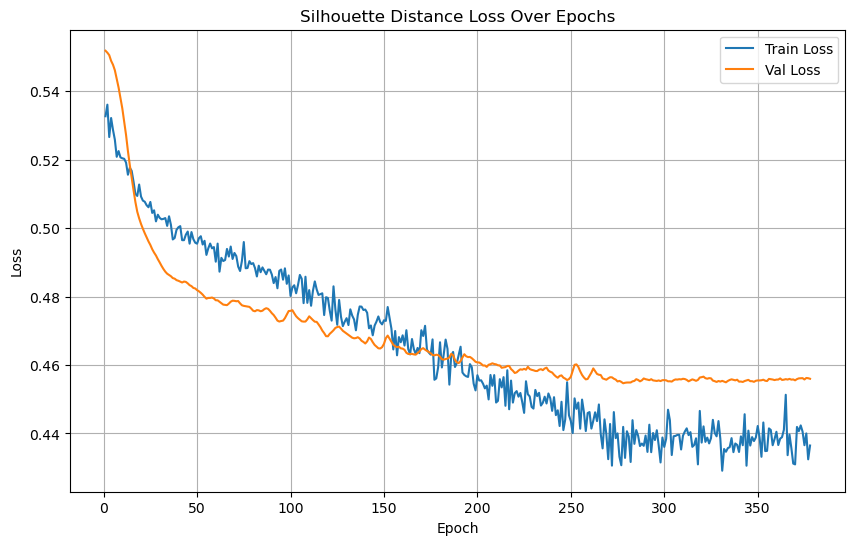

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/73], Loss: 0.3685
Test Batch [20/73], Loss: 0.1515
Test Batch [30/73], Loss: 0.2976
Test Batch [40/73], Loss: 0.5000
Test Batch [50/73], Loss: 0.4342
Test Batch [60/73], Loss: 0.4459


Test Batch [70/73], Loss: 0.3521

Test Loss: 0.3315


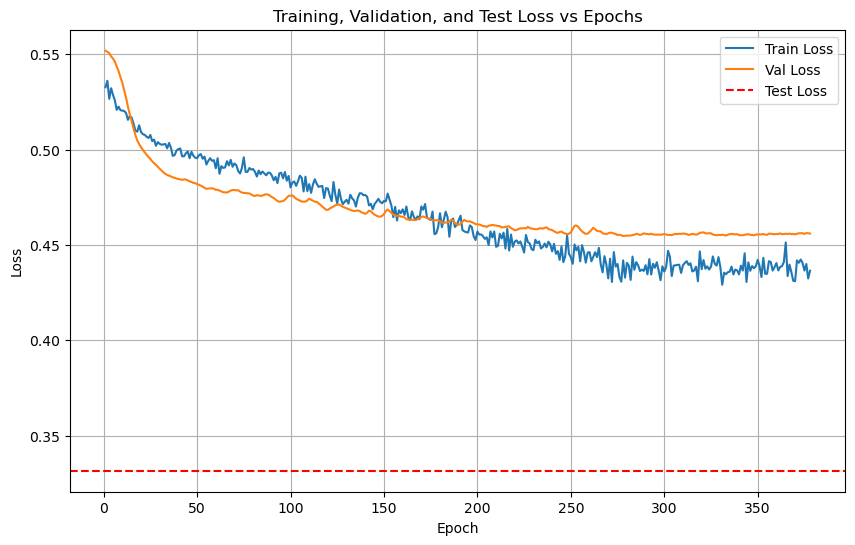

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/73 for test dataset.


  Processed batch 20/73 for test dataset.


  Processed batch 30/73 for test dataset.


  Processed batch 40/73 for test dataset.


  Processed batch 50/73 for test dataset.
  Processed batch 60/73 for test dataset.


  Processed batch 70/73 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 53.85%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.33      0.60      0.43         5
           2       0.67      0.40      0.50         5
           3       0.00      0.00      0.00         5
           4       0.67      0.80      0.73         5
           5       0.75      0.60      0.67         5
           6       0.30      0.60      0.40         5
           7       0.29      0.40      0.33         5
           8       1.00      1.00      1.00         5
           9       0.33      0.20      0.25         5
          10       0.83      1.00      0.91         5
          11       0.33      0.20      0.25         5
          12       0.80      0.80      0.80         5

    accuracy         

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5628  |  Val Loss: 2.5763
Validation loss improved from inf to 2.5763.
[Epoch 2/1000] Train Loss: 2.5401  |  Val Loss: 2.5644
Validation loss improved from 2.5763 to 2.5644.
[Epoch 3/1000] Train Loss: 2.5221  |  Val Loss: 2.5537
Validation loss improved from 2.5644 to 2.5537.
[Epoch 4/1000] Train Loss: 2.5042  |  Val Loss: 2.5442
Validation loss improved from 2.5537 to 2.5442.
[Epoch 5/1000] Train Loss: 2.4873  |  Val Loss: 2.5361
Validation loss improved from 2.5442 to 2.5361.


[Epoch 6/1000] Train Loss: 2.4713  |  Val Loss: 2.5285
Validation loss improved from 2.5361 to 2.5285.
[Epoch 7/1000] Train Loss: 2.4562  |  Val Loss: 2.5218
Validation loss improved from 2.5285 to 2.5218.
[Epoch 8/1000] Train Loss: 2.4411  |  Val Loss: 2.5146
Validation loss improved from 2.5218 to 2.5146.


[Epoch 9/1000] Train Loss: 2.4255  |  Val Loss: 2.5073
Validation loss improved from 2.5146 to 2.5073.
[Epoch 10/1000] Train Loss: 2.4097  |  Val Loss: 2.5014
Validation loss improved from 2.5073 to 2.5014.
[Epoch 11/1000] Train Loss: 2.3942  |  Val Loss: 2.4960
Validation loss improved from 2.5014 to 2.4960.


[Epoch 12/1000] Train Loss: 2.3787  |  Val Loss: 2.4896
Validation loss improved from 2.4960 to 2.4896.
[Epoch 13/1000] Train Loss: 2.3636  |  Val Loss: 2.4841
Validation loss improved from 2.4896 to 2.4841.
[Epoch 14/1000] Train Loss: 2.3489  |  Val Loss: 2.4785
Validation loss improved from 2.4841 to 2.4785.
[Epoch 15/1000] Train Loss: 2.3343  |  Val Loss: 2.4733
Validation loss improved from 2.4785 to 2.4733.
[Epoch 16/1000] Train Loss: 2.3188  |  Val Loss: 2.4666
Validation loss improved from 2.4733 to 2.4666.
[Epoch 17/1000] Train Loss: 2.3051  |  Val Loss: 2.4610
Validation loss improved from 2.4666 to 2.4610.


[Epoch 18/1000] Train Loss: 2.2900  |  Val Loss: 2.4547
Validation loss improved from 2.4610 to 2.4547.
[Epoch 19/1000] Train Loss: 2.2762  |  Val Loss: 2.4501
Validation loss improved from 2.4547 to 2.4501.
[Epoch 20/1000] Train Loss: 2.2624  |  Val Loss: 2.4448
Validation loss improved from 2.4501 to 2.4448.
[Epoch 21/1000] Train Loss: 2.2491  |  Val Loss: 2.4406
Validation loss improved from 2.4448 to 2.4406.


[Epoch 22/1000] Train Loss: 2.2360  |  Val Loss: 2.4357
Validation loss improved from 2.4406 to 2.4357.
[Epoch 23/1000] Train Loss: 2.2227  |  Val Loss: 2.4316
Validation loss improved from 2.4357 to 2.4316.
[Epoch 24/1000] Train Loss: 2.2105  |  Val Loss: 2.4293
Validation loss improved from 2.4316 to 2.4293.


[Epoch 25/1000] Train Loss: 2.1981  |  Val Loss: 2.4246
Validation loss improved from 2.4293 to 2.4246.
[Epoch 26/1000] Train Loss: 2.1858  |  Val Loss: 2.4201
Validation loss improved from 2.4246 to 2.4201.
[Epoch 27/1000] Train Loss: 2.1742  |  Val Loss: 2.4182
Validation loss improved from 2.4201 to 2.4182.
[Epoch 28/1000] Train Loss: 2.1633  |  Val Loss: 2.4153
Validation loss improved from 2.4182 to 2.4153.
[Epoch 29/1000] Train Loss: 2.1527  |  Val Loss: 2.4125
Validation loss improved from 2.4153 to 2.4125.


[Epoch 30/1000] Train Loss: 2.1417  |  Val Loss: 2.4095
Validation loss improved from 2.4125 to 2.4095.
[Epoch 31/1000] Train Loss: 2.1316  |  Val Loss: 2.4057
Validation loss improved from 2.4095 to 2.4057.
[Epoch 32/1000] Train Loss: 2.1213  |  Val Loss: 2.4025
Validation loss improved from 2.4057 to 2.4025.
[Epoch 33/1000] Train Loss: 2.1115  |  Val Loss: 2.4004
Validation loss improved from 2.4025 to 2.4004.


[Epoch 34/1000] Train Loss: 2.1016  |  Val Loss: 2.3973
Validation loss improved from 2.4004 to 2.3973.
[Epoch 35/1000] Train Loss: 2.0921  |  Val Loss: 2.3902
Validation loss improved from 2.3973 to 2.3902.
[Epoch 36/1000] Train Loss: 2.0822  |  Val Loss: 2.3846
Validation loss improved from 2.3902 to 2.3846.


[Epoch 37/1000] Train Loss: 2.0726  |  Val Loss: 2.3800
Validation loss improved from 2.3846 to 2.3800.
[Epoch 38/1000] Train Loss: 2.0632  |  Val Loss: 2.3733
Validation loss improved from 2.3800 to 2.3733.
[Epoch 39/1000] Train Loss: 2.0536  |  Val Loss: 2.3709
Validation loss improved from 2.3733 to 2.3709.


[Epoch 40/1000] Train Loss: 2.0435  |  Val Loss: 2.3685
Validation loss improved from 2.3709 to 2.3685.
[Epoch 41/1000] Train Loss: 2.0330  |  Val Loss: 2.3619
Validation loss improved from 2.3685 to 2.3619.
[Epoch 42/1000] Train Loss: 2.0228  |  Val Loss: 2.3614
Validation loss improved from 2.3619 to 2.3614.
[Epoch 43/1000] Train Loss: 2.0125  |  Val Loss: 2.3591
Validation loss improved from 2.3614 to 2.3591.
[Epoch 44/1000] Train Loss: 2.0026  |  Val Loss: 2.3562
Validation loss improved from 2.3591 to 2.3562.


[Epoch 45/1000] Train Loss: 1.9924  |  Val Loss: 2.3534
Validation loss improved from 2.3562 to 2.3534.
[Epoch 46/1000] Train Loss: 1.9822  |  Val Loss: 2.3493
Validation loss improved from 2.3534 to 2.3493.


[Epoch 47/1000] Train Loss: 1.9716  |  Val Loss: 2.3458
Validation loss improved from 2.3493 to 2.3458.
[Epoch 48/1000] Train Loss: 1.9613  |  Val Loss: 2.3438
Validation loss improved from 2.3458 to 2.3438.
[Epoch 49/1000] Train Loss: 1.9507  |  Val Loss: 2.3409
Validation loss improved from 2.3438 to 2.3409.
[Epoch 50/1000] Train Loss: 1.9409  |  Val Loss: 2.3377
Validation loss improved from 2.3409 to 2.3377.


[Epoch 51/1000] Train Loss: 1.9306  |  Val Loss: 2.3338
Validation loss improved from 2.3377 to 2.3338.
[Epoch 52/1000] Train Loss: 1.9212  |  Val Loss: 2.3299
Validation loss improved from 2.3338 to 2.3299.
[Epoch 53/1000] Train Loss: 1.9116  |  Val Loss: 2.3273
Validation loss improved from 2.3299 to 2.3273.
[Epoch 54/1000] Train Loss: 1.9019  |  Val Loss: 2.3270
Validation loss improved from 2.3273 to 2.3270.
[Epoch 55/1000] Train Loss: 1.8928  |  Val Loss: 2.3262
Validation loss improved from 2.3270 to 2.3262.
[Epoch 56/1000] Train Loss: 1.8838  |  Val Loss: 2.3268
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 57/1000] Train Loss: 1.8745  |  Val Loss: 2.3269
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 1.8658  |  Val Loss: 2.3230
Validation loss improved from 2.3262 to 2.3230.


[Epoch 59/1000] Train Loss: 1.8573  |  Val Loss: 2.3234
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 1.8489  |  Val Loss: 2.3275
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 1.8399  |  Val Loss: 2.3262
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 62/1000] Train Loss: 1.8313  |  Val Loss: 2.3183
Validation loss improved from 2.3230 to 2.3183.
[Epoch 63/1000] Train Loss: 1.8232  |  Val Loss: 2.3179
Validation loss improved from 2.3183 to 2.3179.


[Epoch 64/1000] Train Loss: 1.8140  |  Val Loss: 2.3236
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 65/1000] Train Loss: 1.8052  |  Val Loss: 2.3247
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 66/1000] Train Loss: 1.7962  |  Val Loss: 2.3272
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 67/1000] Train Loss: 1.7875  |  Val Loss: 2.3286
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 68/1000] Train Loss: 1.7788  |  Val Loss: 2.3312
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 69/1000] Train Loss: 1.7701  |  Val Loss: 2.3324
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 70/1000] Train Loss: 1.7612  |  Val Loss: 2.3357
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 71/1000] Train Loss: 1.7519  |  Val Loss: 2.3344
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 72/1000] Train Loss: 1.7427  |  Val Loss: 2.3343
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 73/1000] Train Loss: 1.7331  |  Val Loss: 2.3342
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 74/1000] Train Loss: 1.7235  |  Val Loss: 2.3304
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 75/1000] Train Loss: 1.7145  |  Val Loss: 2.3334
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 76/1000] Train Loss: 1.7049  |  Val Loss: 2.3360
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 77/1000] Train Loss: 1.6950  |  Val Loss: 2.3406
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 78/1000] Train Loss: 1.6850  |  Val Loss: 2.3461
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 79/1000] Train Loss: 1.6752  |  Val Loss: 2.3510
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 80/1000] Train Loss: 1.6652  |  Val Loss: 2.3536
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 81/1000] Train Loss: 1.6551  |  Val Loss: 2.3570
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 82/1000] Train Loss: 1.6447  |  Val Loss: 2.3656
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 83/1000] Train Loss: 1.6347  |  Val Loss: 2.3587
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 84/1000] Train Loss: 1.6248  |  Val Loss: 2.3628
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 85/1000] Train Loss: 1.6141  |  Val Loss: 2.3692
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 86/1000] Train Loss: 1.6038  |  Val Loss: 2.3887
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 87/1000] Train Loss: 1.5926  |  Val Loss: 2.3965
!! Validation loss did NOT improve !! Patience: 24/100


[Epoch 88/1000] Train Loss: 1.5817  |  Val Loss: 2.3971
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 89/1000] Train Loss: 1.5707  |  Val Loss: 2.3936
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 90/1000] Train Loss: 1.5596  |  Val Loss: 2.3978
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 91/1000] Train Loss: 1.5480  |  Val Loss: 2.4026
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 92/1000] Train Loss: 1.5373  |  Val Loss: 2.4184
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 93/1000] Train Loss: 1.5257  |  Val Loss: 2.4212
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 94/1000] Train Loss: 1.5146  |  Val Loss: 2.4253
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 95/1000] Train Loss: 1.5039  |  Val Loss: 2.4189
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 96/1000] Train Loss: 1.4931  |  Val Loss: 2.4231
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 97/1000] Train Loss: 1.4820  |  Val Loss: 2.4249
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 98/1000] Train Loss: 1.4706  |  Val Loss: 2.4390
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 99/1000] Train Loss: 1.4591  |  Val Loss: 2.4491
!! Validation loss did NOT improve !! Patience: 36/100


[Epoch 100/1000] Train Loss: 1.4477  |  Val Loss: 2.4540
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 101/1000] Train Loss: 1.4360  |  Val Loss: 2.4557
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 102/1000] Train Loss: 1.4251  |  Val Loss: 2.4583
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 103/1000] Train Loss: 1.4142  |  Val Loss: 2.4829
!! Validation loss did NOT improve !! Patience: 40/100


[Epoch 104/1000] Train Loss: 1.4030  |  Val Loss: 2.4846
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 105/1000] Train Loss: 1.3911  |  Val Loss: 2.4864
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 106/1000] Train Loss: 1.3799  |  Val Loss: 2.4818
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 107/1000] Train Loss: 1.3687  |  Val Loss: 2.4939
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 108/1000] Train Loss: 1.3575  |  Val Loss: 2.5030
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 109/1000] Train Loss: 1.3466  |  Val Loss: 2.5107
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 110/1000] Train Loss: 1.3355  |  Val Loss: 2.5233
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 111/1000] Train Loss: 1.3243  |  Val Loss: 2.5255
!! Validation loss did NOT improve !! Patience: 48/100


[Epoch 112/1000] Train Loss: 1.3135  |  Val Loss: 2.5298
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 113/1000] Train Loss: 1.3030  |  Val Loss: 2.5386
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 114/1000] Train Loss: 1.2922  |  Val Loss: 2.5442
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 115/1000] Train Loss: 1.2816  |  Val Loss: 2.5619
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 116/1000] Train Loss: 1.2724  |  Val Loss: 2.5824
!! Validation loss did NOT improve !! Patience: 53/100


[Epoch 117/1000] Train Loss: 1.2623  |  Val Loss: 2.5806
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 118/1000] Train Loss: 1.2505  |  Val Loss: 2.5642
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 119/1000] Train Loss: 1.2423  |  Val Loss: 2.5618
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 120/1000] Train Loss: 1.2319  |  Val Loss: 2.5868
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 121/1000] Train Loss: 1.2229  |  Val Loss: 2.6100
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 122/1000] Train Loss: 1.2137  |  Val Loss: 2.6265
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 123/1000] Train Loss: 1.2051  |  Val Loss: 2.6432
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 124/1000] Train Loss: 1.1963  |  Val Loss: 2.6435
!! Validation loss did NOT improve !! Patience: 61/100


[Epoch 125/1000] Train Loss: 1.1869  |  Val Loss: 2.6446
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 126/1000] Train Loss: 1.1783  |  Val Loss: 2.6497
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 127/1000] Train Loss: 1.1689  |  Val Loss: 2.6648
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 128/1000] Train Loss: 1.1605  |  Val Loss: 2.6782
!! Validation loss did NOT improve !! Patience: 65/100


[Epoch 129/1000] Train Loss: 1.1525  |  Val Loss: 2.6848
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 130/1000] Train Loss: 1.1439  |  Val Loss: 2.6924
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 131/1000] Train Loss: 1.1356  |  Val Loss: 2.6980
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 132/1000] Train Loss: 1.1276  |  Val Loss: 2.7021
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 133/1000] Train Loss: 1.1200  |  Val Loss: 2.7122
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 134/1000] Train Loss: 1.1121  |  Val Loss: 2.7293
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 135/1000] Train Loss: 1.1047  |  Val Loss: 2.7420
!! Validation loss did NOT improve !! Patience: 72/100


[Epoch 136/1000] Train Loss: 1.0967  |  Val Loss: 2.7560
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 137/1000] Train Loss: 1.0893  |  Val Loss: 2.7574
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 138/1000] Train Loss: 1.0819  |  Val Loss: 2.7446
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 139/1000] Train Loss: 1.0750  |  Val Loss: 2.7584
!! Validation loss did NOT improve !! Patience: 76/100


[Epoch 140/1000] Train Loss: 1.0680  |  Val Loss: 2.7890
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 141/1000] Train Loss: 1.0610  |  Val Loss: 2.8011
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 142/1000] Train Loss: 1.0542  |  Val Loss: 2.8199
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 143/1000] Train Loss: 1.0480  |  Val Loss: 2.8342
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 144/1000] Train Loss: 1.0416  |  Val Loss: 2.8419
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 145/1000] Train Loss: 1.0346  |  Val Loss: 2.8469
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 146/1000] Train Loss: 1.0287  |  Val Loss: 2.8475
!! Validation loss did NOT improve !! Patience: 83/100


[Epoch 147/1000] Train Loss: 1.0227  |  Val Loss: 2.8768
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 148/1000] Train Loss: 1.0163  |  Val Loss: 2.8974
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 149/1000] Train Loss: 1.0099  |  Val Loss: 2.8890
!! Validation loss did NOT improve !! Patience: 86/100


[Epoch 150/1000] Train Loss: 1.0043  |  Val Loss: 2.8913
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 151/1000] Train Loss: 0.9991  |  Val Loss: 2.9204
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 152/1000] Train Loss: 0.9931  |  Val Loss: 2.9330
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 153/1000] Train Loss: 0.9871  |  Val Loss: 2.9298
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 154/1000] Train Loss: 0.9816  |  Val Loss: 2.9463
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 155/1000] Train Loss: 0.9764  |  Val Loss: 2.9750
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 156/1000] Train Loss: 0.9727  |  Val Loss: 2.9800
!! Validation loss did NOT improve !! Patience: 93/100


[Epoch 157/1000] Train Loss: 0.9669  |  Val Loss: 2.9879
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 158/1000] Train Loss: 0.9610  |  Val Loss: 2.9802
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 159/1000] Train Loss: 0.9558  |  Val Loss: 2.9987
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 160/1000] Train Loss: 0.9505  |  Val Loss: 3.0301
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 161/1000] Train Loss: 0.9461  |  Val Loss: 3.0677
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 162/1000] Train Loss: 0.9420  |  Val Loss: 3.0737
!! Validation loss did NOT improve !! Patience: 99/100


[Epoch 163/1000] Train Loss: 0.9373  |  Val Loss: 3.0734
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 163 !!
No improvement for 100 epochs.


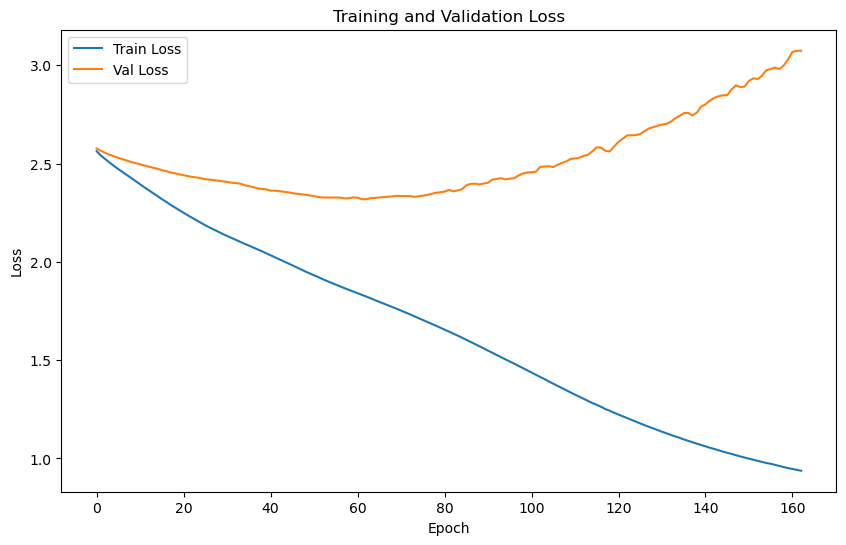

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 3.2334 | Test Accuracy: 47.97%


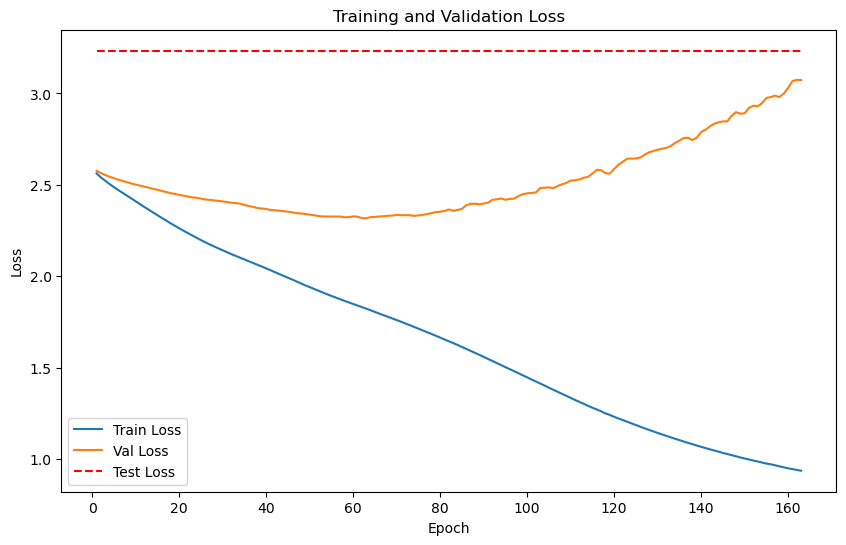

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


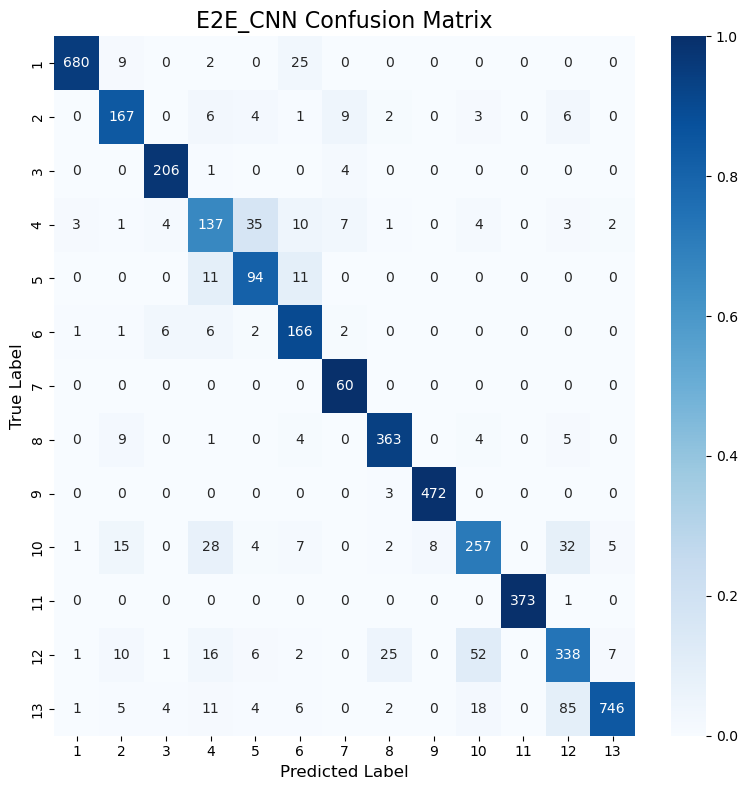

Classification Accuracy: 87.74%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


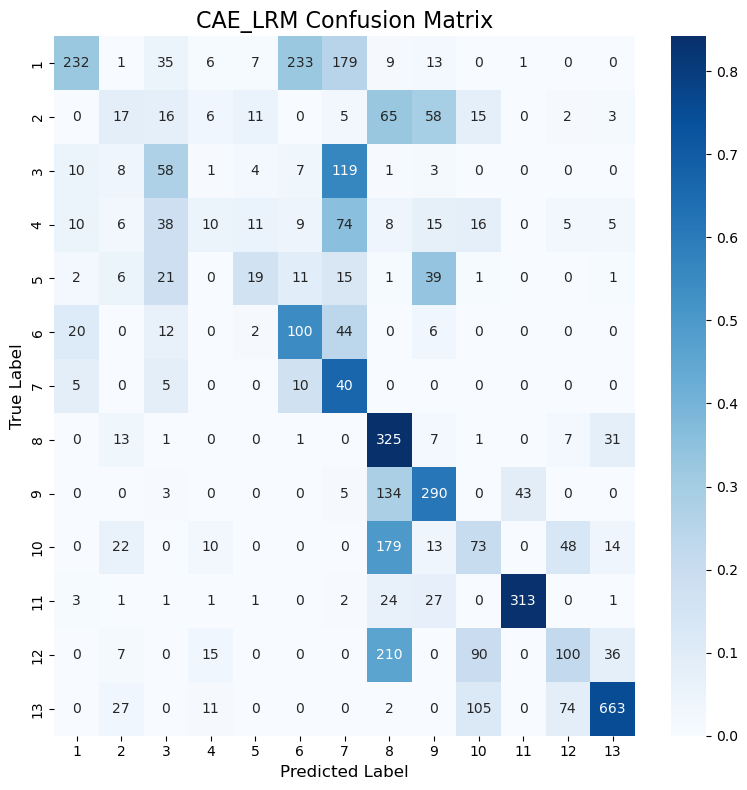

Classification Accuracy: 48.42%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


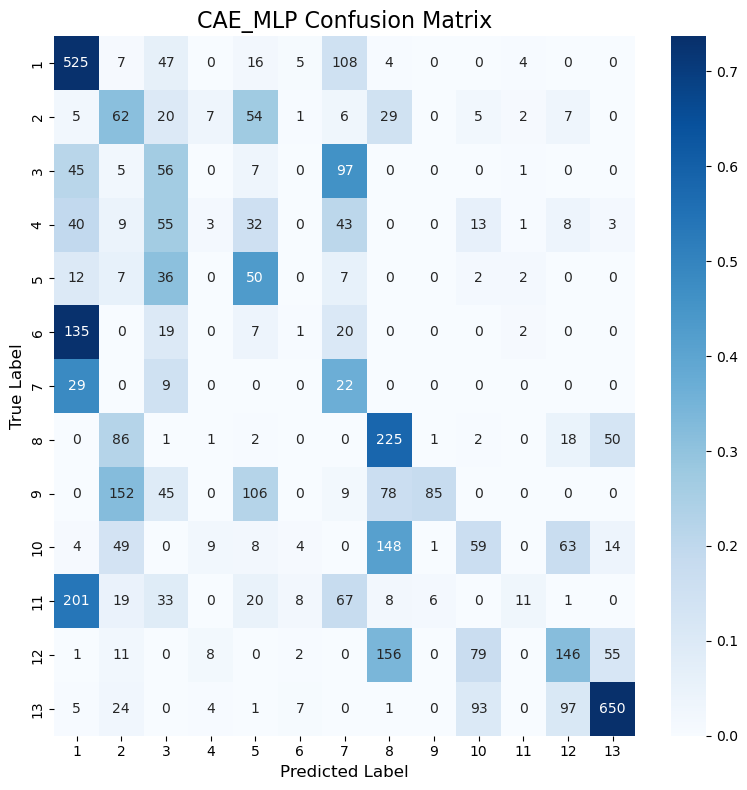

Classification Accuracy: 40.96%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


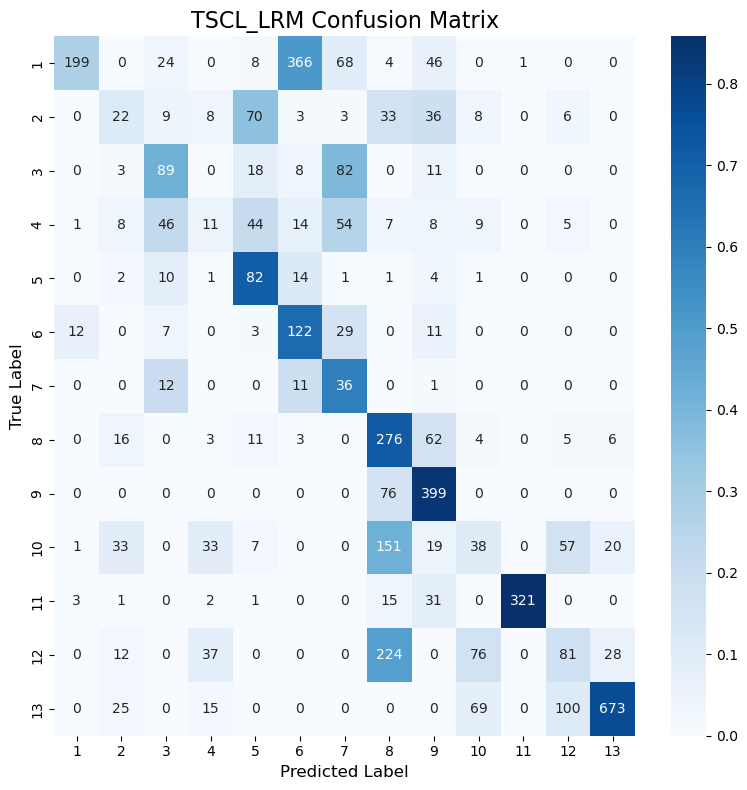

Classification Accuracy: 50.78%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


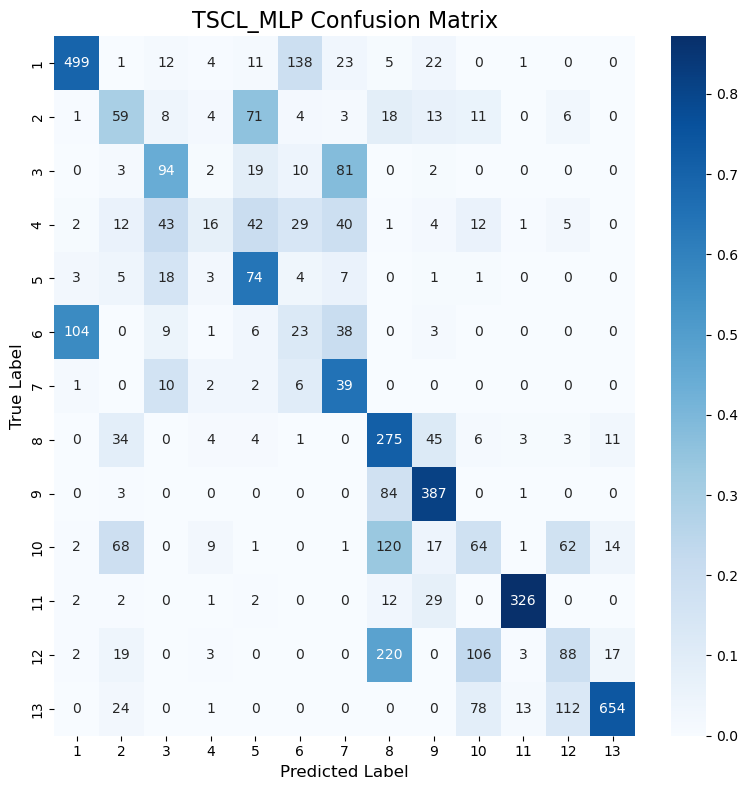

Classification Accuracy: 56.16%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


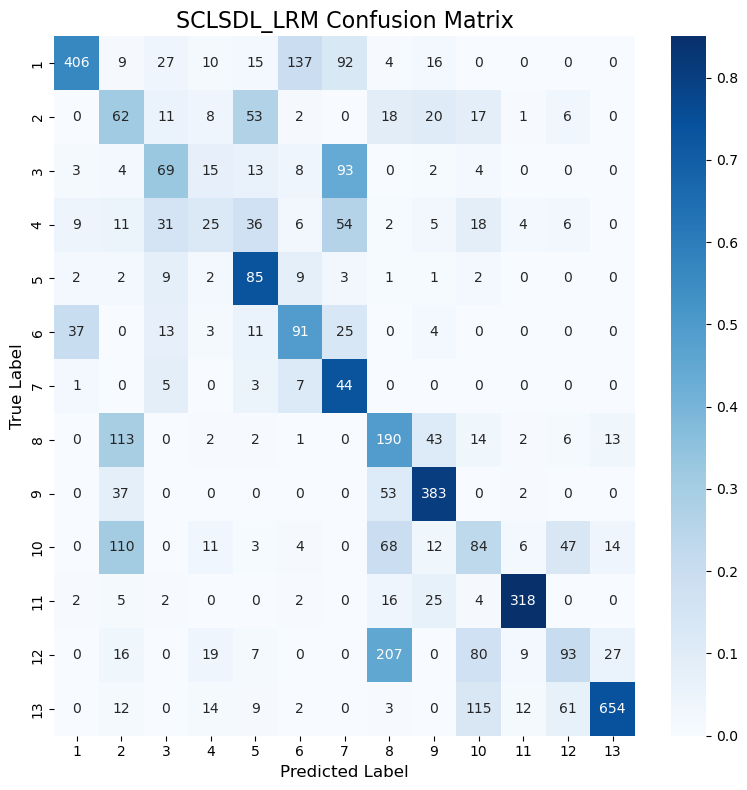

Classification Accuracy: 54.13%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


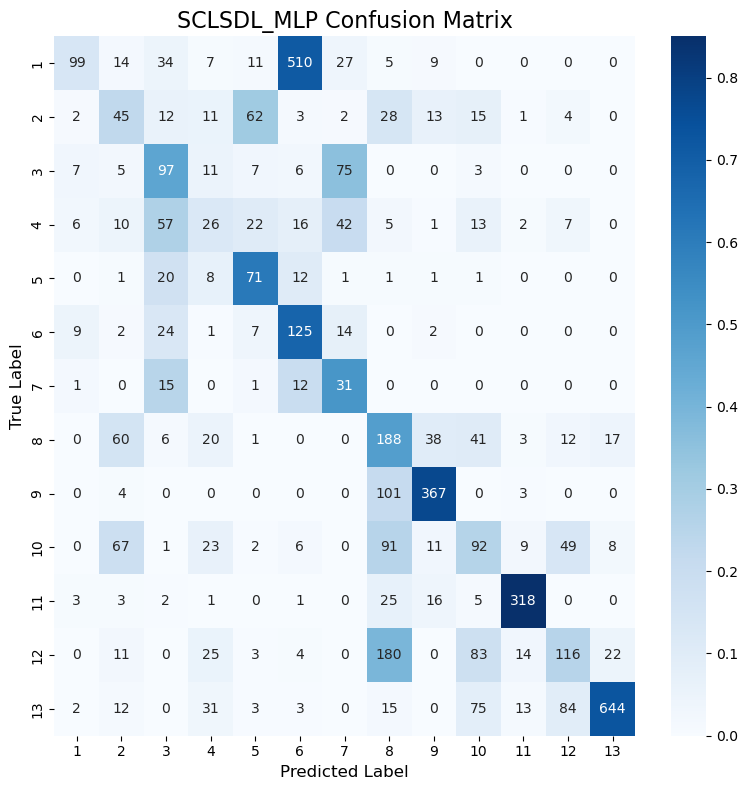

Classification Accuracy: 47.97%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          87.74
1    LRM (CAE)          48.42
2    MLP (CAE)          40.96
3     TSCL LRM          50.78
4     TSCL MLP          56.16
5  SCL_SDL LRM          54.13
6  SCL_SDL MLP          47.97

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          87.74
4     TSCL MLP          56.16
5  SCL_SDL LRM          54.13
3     TSCL LRM          50.78
1    LRM (CAE)          48.42
6  SCL_SDL MLP          47.97
2    MLP (CAE)          40.96
